# B(E2) analysis

Collect proton/neutron E2 matrix elements from runs using random samples of USDB

$ B(E2) = b^4 \left[ e_p M_p + e_n M_n \right]^2 $

Want to compute (approx) posterior distributions for oscillator length $b$, and effective charges $e_p$ and $e_n$ .

Prior assumptions:

$b^2 = 0.9 A^{1/3} + 0.7$

$P(e_p) \sim U[1,2]$

$P(e_n) \sim U[0,1]$


In [1]:
import numpy as np

import os
from glob import glob
from tqdm import tqdm
from time import time

def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)

import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

import pandas as pd
import pickle as pkl

from hepstats.modeling import bayesian_blocks

def bayesian_blocks_mod(y):
    if len(np.unique(y))==1:
        return None
    tol = np.std(y)/100
    blocks = bayesian_blocks(y)
    diffs = np.diff(blocks)
    mask = np.ones(len(blocks),dtype=bool)
    for i,d in enumerate(diffs):
        if d<tol:
            print(f'Deleting one bin: width = {d}')
            mask[i] = False
    return blocks[mask,...]

### EXAMPLE
###    blocks = bayesian_blocks_mod(y)
###    plt.hist(y, bins=blocks, density=True)

import sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [9]:
from scipy.special import factorial2

# hbarc = 197.3 #MeV fm
# hbar = 6.582E-22 #MeV s
# alpha = 1/137
# mP = 938.272 # Mev/c^2
# #muN = 3.152E-14 # MeV / T
# muN2 =  alpha*hbarc**3*2*mP**-2 # nuclear magneton squared

hbarc = 197300 #keV fm
hbar = 6.582E-19 #keV s
alpha = 1/137
mP = 938272 # kev/c^2
#muN = 3.152E-14 # MeV / T
muN2 =  alpha*hbarc**3*2*mP**-2 # nuclear magneton squared


def Thalf_width(E): #converts energy width (MeV) to Thalf in seconds
    return hbar * np.log(2)/(E/1000)

def Thalf_width_kev(E):
    if E==0.:
        return None
    return Thalf_width(E)

def times_so_far(ls):
#     counts occurences of items
#     x = [0,2,1,0,4,2,2,1,0]
#     times_so_far(x) = [1, 1, 1, 2, 1, 2, 3, 2, 3]
    out = [0]*len(ls)
    for i in range(len(ls)):
        out[i] = ls[:i+1].count(ls[i])
    return out

def j_to_twoj(x):
    if '/2' in x:
        return int(x.strip('/2'))
    else:
        return 2*int(x.strip('()'))
    
def thalf_units_to_sec(units,value):
    m=0
    if units=='PS':
        m = 10**-12
    elif units=='NS':
        m = 10**-9
    elif units=='FS':
        m = 10**-15
    elif units=='US':
        m = 10**-6
    elif units=='AS':
        m = 10**-18
    elif units=='KEV':
        pass
    if m==0:
        return Thalf_width_kev(value)
    else:
        return m*value
    
def my_float(x):
    try:
        return float(x)
    except:
        return 0.0
    
def fLambda(l):
    return 8*np.pi*(l+1)/(l*(factorial2(2*l+1)**2))

def BEl(l,Egamma,Thalf,I,units):
    if units == 1: # [B] = fm^2l
        B = (I/100)*(np.log(2)/Thalf)*fLambda(l)**-1*hbar*hbarc**(2*l+1)*(Egamma**(-2*l-1))
    elif units == 2: # [B] = e^2 fm^2l
        B = (I/100)*(np.log(2)/Thalf)*fLambda(l)**-1*hbar*hbarc**(2*l+1)*(Egamma**(-2*l-1))
        B = B/(alpha*hbarc)
    elif units == 3: # [B] = e^2 b^l
        B = (I/100)*(np.log(2)/Thalf)*fLambda(l)**-1*hbar*hbarc**(2*l+1)*(Egamma**(-2*l-1))
        B = 10**(-2*l)*B/(alpha*hbarc)
    return B

def BE2_e2fm4(Egamma,Thalf,I):
    # in e^2 fm^4
    return BEl(2,Egamma,Thalf,I,2)

# def BE2_Wu(A,Egamma,Thalf,I):
#     lamW = 7.3E7*A**(4/3)*Egamma**5;
#     lamExp = (np.log(2)/(Thalf*10**-15))*(I/100);   #Thalf in fs
#     return lamExp/lamW

def Bweisskopf(l,A):
    # Weisskopf (single-particle) estimate in e^2 fm^2l
    return (1/(4*np.pi)) * (3/(3+l))**2 * (1.2*A**(1/3))**(2*l)

def BEl_in_Wu(l,Egamma,Thalf,I,A):
    return BEl(l,Egamma,Thalf,I,2) / Bweisskopf(l,A)
    

In [10]:
path_to_input_csv = 'sd_E2_processed_v2.csv'
path_to_usdb_csv = 'sd_E2_usdb_complete.csv'
df_input = pd.read_csv(path_to_input_csv)
df_usdb = pd.read_csv(path_to_usdb_csv)

In [11]:
df_input = df_input.rename(columns={'Unnamed: 0':'GlobalIndex'})
df_usdb = df_usdb.rename(columns={'Unnamed: 0':'GlobalIndex'})
# the key GlobalIndex comes from the original transition data

def drop_unnamed_columns(x):
    return x.loc[:, ~x.columns.str.contains('^Unnamed')]

df_input = drop_unnamed_columns(df_input)
df_usdb = drop_unnamed_columns(df_usdb)

In [12]:
usdbmil = np.loadtxt('/p/lustre2/fox39/shmuq/usdb/shmuq_e2/usdbmil.vec',skiprows=1)
usdb = np.loadtxt('/p/lustre2/fox39/shmuq/usdb/shmuq_e2/usdb.vec',skiprows=1)

In [13]:
n_transitions = len(df_usdb)
print('# transitions =', n_transitions)

# transitions = 236


In [14]:
df_usdb.keys()

Index(['GlobalIndex', 'A', 'Element', 'Z', 'N', 'Energy (keV)',
       'Energy Unc (keV)', 'Ji', 'Thalf', 'E_gamma (keV)', 'E_gamma Unc (keV)',
       'I_gamma', 'I_gamma Unc', 'Mult', 'Mult Ratio', 'Mult Ratio Unc',
       'Conv Coef', 'Conv Coef Unc', 'B_exp (W.u.)', 'B_exp Unc (W.u.)',
       'twoJi', 'Thalf Value', 'Thalf Units', 'Thalf Unc', 'Thalf (sec)',
       'Thalf Unc (sec)', 'B_exp (e^2fm^4)', 'B_exp Unc (e^2fm^4)', 'Nucleus',
       'Jf', 'twoJf', 'ni', 'nf', 'Include', 'Mth_p', 'Mth_n'],
      dtype='object')

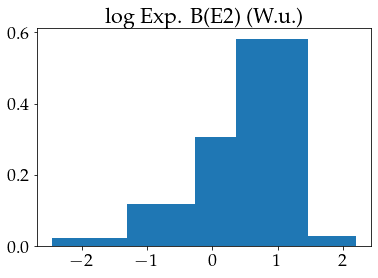

In [15]:
y = np.log10(df_usdb['B_exp (W.u.)'])
blocks = bayesian_blocks_mod(y)
plt.hist(y, bins=blocks, density=True)
plt.title('log Exp. B(E2) (W.u.)')
plt.show()

In [16]:
print(f'Out of {len(y)} transitions, {len(y[y<0])} are smaller than the Weisskopf estimate')

Out of 236 transitions, 53 are smaller than the Weisskopf estimate


### Excluding transitions

In [17]:
drop_nuc_list = ['17O','18O','17F','38Ar','38K']
for nuc in drop_nuc_list:
    df_usdb.at[df_usdb['Nucleus']==nuc,'Include'] = False

df_usdb.at[df_usdb['B_exp (W.u.)']<0.1,'Include'] = False
df_usdb.at[df_usdb['B_exp (W.u.)']>150.0,'Include'] = False
df_usdb.at[df_usdb['Mth_p'] == 0.0,'Include'] = False
df_usdb.at[df_usdb['Mth_n'] == 0.0,'Include'] = False

df_usdb = df_usdb[df_usdb['Include']==True]
n_transitions = len(df_usdb)
print(f'Number of transitions kept: {n_transitions}')

Number of transitions kept: 188


# Load sampling results

In [18]:
data_path = '/p/lustre2/fox39/shmuq/usdb/shmuq_e2/results'
run_dir_list = []
problem_cases = []
for run_dir in sorted(glob(os.path.join(data_path,'run_usdb_rand?????'))):
    n_results_files = len(glob(os.path.join(run_dir,'*')))
    if not n_results_files==3:
        problem_cases.append(run_dir)
    else:
        run_dir_list.append(run_dir)
#     print(run_dir)
print(problem_cases)

[]


In [19]:
for w in problem_cases:
    print(w)

In [20]:
collect_data = False

n_params = 66
n_samples = len(run_dir_list)
fn_data = f'transition_data_n{n_samples}.pkl'

if collect_data:
    df_dict = {}
    int_vec_array = []
    mil_vec_array = []
    for run_dir in run_dir_list[:n_samples]:
        print(run_dir)
        run_num_string = run_dir.split('rand')[-1]
        run_num = int(run_num_string)-1
        df_dict[run_num_string] = pd.read_csv(os.path.join(run_dir,f'sd_E2_usdb_rand{run_num_string}_complete.csv'))
        df_dict[run_num_string] = df_dict[run_num_string].rename(columns={'Unnamed: 0': 'GlobalIndex'})
        df_dict[run_num_string] = drop_unnamed_columns(df_dict[run_num_string])
        df_dict[run_num_string] = df_dict[run_num_string].drop('Include', axis=1)   # Include only belongs in the USDB DF
        int_vec_array.append(np.loadtxt(os.path.join(run_dir,f'usdb_rand{run_num_string}.vec'),skiprows=1))
        mil_vec_array.append(np.loadtxt(os.path.join(run_dir,f'usdbmil_rand{run_num_string}.vec'),skiprows=1))

    int_vec_array = np.array(int_vec_array)
    mil_vec_array = np.array(mil_vec_array)
    
    with open(fn_data,'wb') as fh:
        pkl.dump([df_dict,int_vec_array,mil_vec_array],fh)
else:
    with open(fn_data,'rb') as fh:
        [df_dict,int_vec_array,mil_vec_array] = pkl.load(fh)

### PCA-parameter sample distributions
Note that below each should obey 1/variance = Hessian eigenvalue.

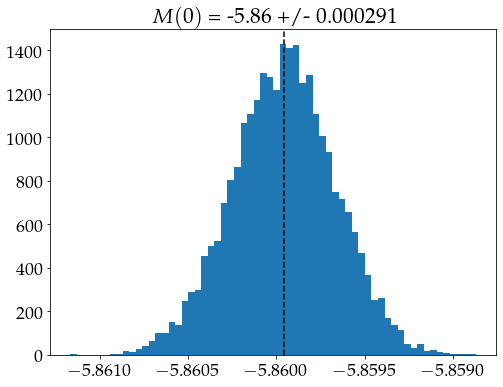

1/variance =  11781684.176132223
[-2.45593196 -1.30648315 -0.26674413  0.37006287  1.46213964  2.20411998]


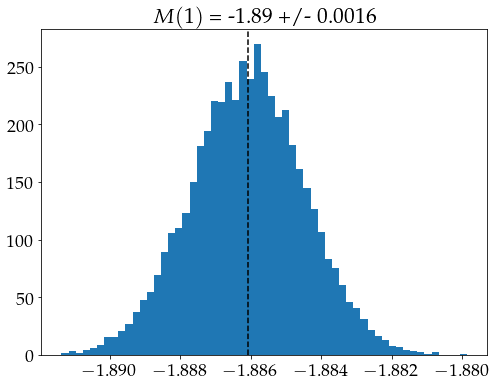

1/variance =  392910.68339465535
[-2.45593196 -1.30648315 -0.26674413  0.37006287  1.46213964  2.20411998]


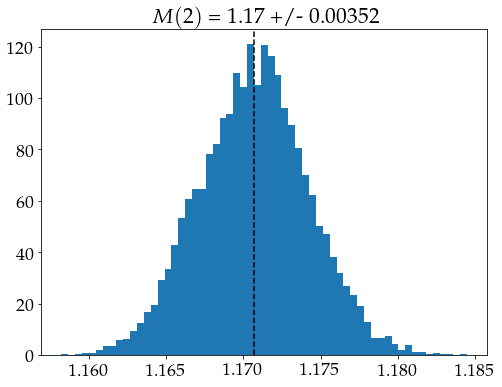

1/variance =  80501.78669646713
[-2.45593196 -1.30648315 -0.26674413  0.37006287  1.46213964  2.20411998]


In [21]:
# for mi in range(n_params):
for mi in range(3):
    y = mil_vec_array[:,mi]
    plt.figure(figsize=(8,6))
    plt.hist(y,bins=optimal_n_bins(y),density=True)
    plt.title(fr'$M({mi})$ = {np.mean(y):5.3} +/- {np.std(y):5.3}')
    plt.axvline(usdbmil[mi],c='k',ls='--')
    plt.show()
    print('1/variance = ',(1/np.std(y))**2)
    print(blocks)

### USDB parameter sample distributions

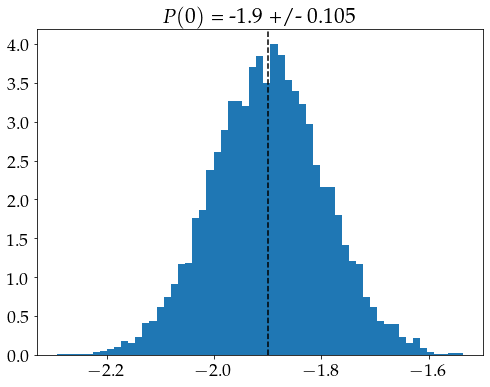

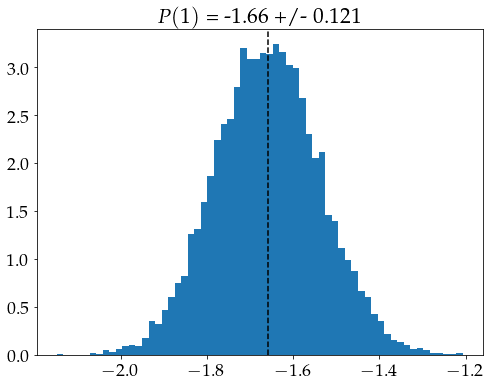

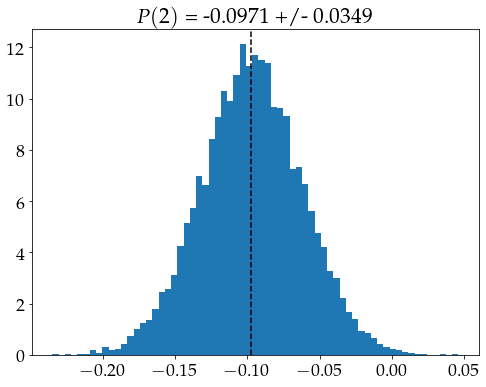

In [22]:
# for pi in range(n_params):
for pi in range(3):
    y = int_vec_array[:,pi]
    plt.figure(figsize=(8,6))
    plt.hist(y,bins=optimal_n_bins(y),density=True)
    plt.title(fr'$P({pi})$ = {np.mean(y):5.3} +/- {np.std(y):5.3}')
    plt.axvline(usdb[pi],c='k',ls='--')
    plt.show()

### Shell-model M(E2) distributions 

In [29]:
def format_nuc_name(s):
    A = s[:2]
    el = s[2:]
    A_up = r'$^{%s}$' % A
    return f'{A_up}{el}'

def matrix_element_distributions(index,plot=False, debug=False, print_times = False, fake_run=False, pdf=None):
    times = []
    times.append(time())
    
    print('INDEX = ',index)
    t_usdb = df_usdb[df_usdb['GlobalIndex']==index].iloc[0]
    if debug:  print(t_usdb)
    nuc = t_usdb['Nucleus']
    A = t_usdb['A']
    Z = t_usdb['Z']
    N = t_usdb['N']
    ji = t_usdb['Ji']
    ni = t_usdb['ni']
    jf = t_usdb['Jf']
    nf = t_usdb['nf']
    times.append(time())
    
    if fake_run:
        t_sample = df_dict['00001'][df_dict['00001']['GlobalIndex']==index].iloc[0]
        t_sample_list = [t_sample] * len(df_dict.keys())
    else:
        t_sample_list = [df_dict[run_num_string][df_dict[run_num_string]['GlobalIndex']==index].iloc[0] for run_num_string in list(df_dict.keys()) ]
    times.append(time())
    
#     if debug: print(t_sample_list[0])
    Mth_p_vec = np.array([t['Mth_p'] for t in t_sample_list ]).flatten()
    Mth_n_vec = np.array([t['Mth_n'] for t in t_sample_list ]).flatten()
    times.append(time())
    
    check_list = [np.round(t_usdb['B_exp (e^2fm^4)'],5),
                np.round(t_sample_list[0]['B_exp (e^2fm^4)'],5) ]
    
    err_cond = check_list[0] != check_list[1]
    print(err_cond)
    if err_cond:
        print('-'*40)
        print('ERROR: input transition does not match output transition')
        print('transition index = ',index)
        print('-'*40)
        return

        print(t_sample_list[0])
    
    Mth_p_usdb = t_usdb['Mth_p']
    Mth_n_usdb = t_usdb['Mth_n']

    times.append(time())
    
    no_proton = False
    no_neutron = False
    if np.array_equal(Mth_p_vec,np.zeros_like(Mth_p_vec)):
        print('Proton parts are all zero')
        Mth_n_vec = np.abs(Mth_n_vec)
        Mth_n_usdb = np.abs(Mth_n_usdb)
        no_proton = True
    elif np.array_equal(Mth_n_vec,np.zeros_like(Mth_n_vec)):
        print('Neutron parts are all zero')
        Mth_p_vec = np.abs(Mth_p_vec)
        Mth_p_usdb = np.abs(Mth_p_usdb)
        no_neutron = True
    else:
        rel_sign = np.sign(Mth_p_vec)*np.sign(Mth_n_vec)
        Mth_p_vec = np.abs(Mth_p_vec)  #Mth_p >0 always
        Mth_n_vec = np.abs(Mth_n_vec)*rel_sign
        rel_sign_usdb = np.sign(Mth_p_usdb)*np.sign(Mth_n_usdb)
        Mth_p_usdb = np.abs(Mth_p_usdb)  #Mth_p >0 always
        Mth_n_usdb = np.abs(Mth_n_usdb)*rel_sign_usdb
    
    print('USDB:')
    print(f'Mp = {Mth_p_usdb}')
    print(f'Mn = {Mth_n_usdb}')
    
    if np.isnan(np.sum(Mth_p_vec)):
        print('NAN detected in proton part!')
        return 1
    if np.isnan(np.sum(Mth_n_vec)):
        print('NAN detected in neutron part!')
        return -1
    
    times.append(time())
    
    leave_out_outliers = True
    if leave_out_outliers:
        outlier_factor = 5
        count = 0
        p_mean = np.mean(Mth_p_vec)
        n_mean = np.mean(Mth_n_vec)
        p_window = outlier_factor*np.std(Mth_p_vec)
        n_window = outlier_factor*np.std(Mth_n_vec)
        for si in range(n_samples):
            p_out = np.abs(Mth_p_vec[si] - p_mean) > p_window
            n_out = np.abs(Mth_n_vec[si] - n_mean) > n_window
            if p_out or n_out:
                np.delete(Mth_p_vec,[si],0)
                np.delete(Mth_n_vec,[si],0)
                count+=1
        print(f'Dropped {count} outliers.')
    
    if no_neutron and no_proton:
        print('THERE IS NO TRANSITION')
        return 2
        
    print('Standard Deviations:')
    print(f'    Proton = {np.std(Mth_p_vec)}')
    print(f'    Neutron = {np.std(Mth_n_vec)}')
    
    color_p = 'orange'
    color_n = 'cyan'
    color_p_usdb = 'red'
    color_n_usdb = 'blue'
    ls_p = '--'
    ls_n = '-.'
    hatch_patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    hatch_p = hatch_patterns[0]
    hatch_n = hatch_patterns[1]
    
# M1 stuff for reference :
#     color_sp = 'salmon'
#     color_sn = 'lightblue'
#     color_lp = 'lightgreen'
#     color_ln = 'plum'
#     color_sp_usdb = 'red'
#     color_sn_usdb = 'blue'
#     color_lp_usdb = 'forestgreen'
#     color_ln_usdb = 'darkviolet'
#     sp_ls = 'solid'
#     sn_ls = 'dashed'
#     lp_ls = 'dotted'
#     ln_ls = 'dashdot'
#     hatch_patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
#     hatch_sp = hatch_patterns[0]
#     hatch_sn = hatch_patterns[1]
#     hatch_lp = hatch_patterns[2]
#     hatch_ln = hatch_patterns[3]
    
    std_threshold = 1e-10
#     title_string = fr'\#{index}: {nuc} {ji}({ni}) $\rightarrow$ {jf}({nf})'
    title_string = fr'{format_nuc_name(nuc)} $({ji}_{ni}) \rightarrow ({jf}_{nf})$'
    if t_usdb['Include']:
        inc_str = 'Included in UQ'
    else:
        inc_str = 'Excluded from UQ'
    title_string += "\n" + inc_str

    times.append(time())
    
    
    if plot:
        plt.figure(figsize=(8,6))
        if no_neutron:
            #only plot proton part
            if (np.std(Mth_p_vec)<std_threshold):
                print('Proton part constant.')
                bins_p = 10
            else:
                bins_p = optimal_n_bins(Mth_p_vec)//2
                
            plt.hist(Mth_p_vec, bins=bins_p, density=True,color=color_p)
            plt.axvline(Mth_p_usdb,ls=ls_p,color=color_p_usdb,label='USDB')
            plt.xlabel('Mth (Proton only)')

        elif no_proton:
            if (np.std(Mth_n_vec)<std_threshold):
                print('Neutron part constant.')
                bins_n=10
            else:
                bins_n = optimal_n_bins(Mth_n_vec)//2
                
            plt.hist(Mth_n_vec,bins=bins_n, density=True,color=color_n)
            plt.axvline(Mth_n_usdb,ls=ls_n,color=color_n_usdb,label='USDB')
            plt.xlabel('Mth (Neutron only)')

        else:    
            bins_p = optimal_n_bins(Mth_p_vec)//2
            bins_n = optimal_n_bins(Mth_n_vec)//2
            plt.hist(Mth_p_vec, bins=bins_p, density=True, alpha = 0.5, label='Proton',color=color_p, hatch=hatch_p)
            plt.hist(Mth_n_vec, bins=bins_n, density=True, alpha = 0.5, label='Neutron',color=color_n, hatch=hatch_n)
            plt.axvline(Mth_p_usdb,ls=ls_p,color=color_p_usdb,label='USDB Proton')
            plt.axvline(Mth_n_usdb,ls=ls_n,color=color_n_usdb,label='USDB Neutron')
            plt.xlabel('Mth')
        plt.title(title_string)
        plt.ylabel('Density (no units)')
        plt.legend(loc=(1.02,0.2))
        plt.tight_layout()
        if pdf is None:
            plt.show()
        else:
            pdf.savefig()
            plt.close()

    nuc_dict = {'Nucleus':nuc,
                'A':A,
                'Z':Z,
                'N':N,
                'Ji':ji,
                'Jf':jf,
                'ni':ni,
                'nf':nf,
               }
    
    times.append(time())
    
    if print_times:
        for i,dt in enumerate(np.diff(times)):
            print(f'Sector {i} :   delta t = {dt}')
        
    return nuc_dict, Mth_p_usdb, Mth_n_usdb, Mth_p_vec, Mth_n_vec, title_string

In [35]:
ti_list = list(df_usdb['GlobalIndex'])
# for ti in ti_list[:3]:
#     matrix_element_distributions(ti,plot=True,debug=True,fake_run=False)
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('E2_M_histograms.pdf') as pdf:
    for ti in ti_list:
        matrix_element_distributions(ti,plot=True,debug=True,fake_run=False,pdf=pdf)

INDEX =  4
GlobalIndex                       4
A                                17
Element                           O
Z                                 8
N                                 9
Energy (keV)                 870.73
Energy Unc (keV)                0.1
Ji                              1/2
Thalf                  179.2 PS 1.8
E_gamma (keV)                870.71
E_gamma Unc (keV)              0.12
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                           [E2]
Mult Ratio                      NaN
Mult Ratio Unc                  NaN
Conv Coef                       NaN
Conv Coef Unc                   NaN
B_exp (W.u.)                   2.39
B_exp Unc (W.u.)               0.03
twoJi                             1
Thalf Value                   179.2
Thalf Units                      PS
Thalf Unc                       1.8
Thalf (sec)                     0.0
Thalf Unc (sec)                 0.0
B_exp (e^2fm^4)            6.206033
B_exp Unc (e^2fm^

INDEX =  10
GlobalIndex                    10
A                              18
Element                         O
Z                               8
N                              10
Energy (keV)               5254.8
Energy Unc (keV)              0.9
Ji                              2
Thalf                  7.0 FS 0.3
E_gamma (keV)              1621.0
E_gamma Unc (keV)             0.0
I_gamma                       1.0
I_gamma Unc                   0.6
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef                     NaN
Conv Coef Unc                 NaN
B_exp (W.u.)                 23.0
B_exp Unc (W.u.)             15.0
twoJi                           4
Thalf Value                   7.0
Thalf Units                    FS
Thalf Unc                     0.3
Thalf (sec)                   0.0
Thalf Unc (sec)               0.0
B_exp (e^2fm^4)         64.452851
B_exp Unc (e^2fm^4)     42.034468
Nucleus                       18O
Jf

INDEX =  16
GlobalIndex                   16
A                             17
Element                        F
Z                              9
N                              8
Energy (keV)              495.33
Energy Unc (keV)             0.1
Ji                           1/2
Thalf                   286 PS 6
E_gamma (keV)             495.32
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                25.0
B_exp Unc (W.u.)             0.5
twoJi                          1
Thalf Value                286.0
Thalf Units                   PS
Thalf Unc                    6.0
Thalf (sec)                  0.0
Thalf Unc (sec)              0.0
B_exp (e^2fm^4)        64.916664
B_exp Unc (e^2fm^4)     1.298333
Nucleus                      17F
Jf                           5/

False
USDB:
Mp = 0.1052
Mn = -0.1052
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.015043735386802396
    Neutron = 0.015043735386802396
INDEX =  22
GlobalIndex                   22
A                             18
Element                        F
Z                              9
N                              9
Energy (keV)              5297.6
Energy Unc (keV)             1.5
Ji                             4
Thalf                    21 FS 3
E_gamma (keV)             2775.0
E_gamma Unc (keV)            0.0
I_gamma                     78.0
I_gamma Unc                  3.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                17.0
B_exp Unc (W.u.)             6.0
twoJi                          8
Thalf Value                 21.0
Thalf Units                   FS
Thalf Unc                    3.0
Thalf (sec)                  0.0
Thalf Unc (sec) 

False
USDB:
Mp = 0.591
Mn = 1.3573
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.004534280639582557
    Neutron = 0.005201407415380616
INDEX =  29
GlobalIndex                    29
A                              19
Element                         F
Z                               9
N                              10
Energy (keV)               4648.0
Energy Unc (keV)              1.0
Ji                           13/2
Thalf                  2.6 PS 0.3
E_gamma (keV)              1868.0
E_gamma Unc (keV)             0.0
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef                     NaN
Conv Coef Unc                 NaN
B_exp (W.u.)                  3.2
B_exp Unc (W.u.)              0.4
twoJi                          13
Thalf Value                   2.6
Thalf Units                    PS
Thalf Unc                     0.3
Thalf (sec)                

INDEX =  35
GlobalIndex                    35
A                              18
Element                        Ne
Z                              10
N                               8
Energy (keV)               3376.2
Energy Unc (keV)              0.4
Ji                              4
Thalf                  3.0 PS 0.4
E_gamma (keV)              1489.0
E_gamma Unc (keV)             0.0
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef                     NaN
Conv Coef Unc                 NaN
B_exp (W.u.)                  8.9
B_exp Unc (W.u.)              1.2
twoJi                           8
Thalf Value                   3.0
Thalf Units                    PS
Thalf Unc                     0.4
Thalf (sec)                   0.0
Thalf Unc (sec)               0.0
B_exp (e^2fm^4)         24.940451
B_exp Unc (e^2fm^4)      3.362757
Nucleus                      18Ne
Jf

False
USDB:
Mp = 1.2321
Mn = 1.2321
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.0032679209957591007
    Neutron = 0.0032679209957591007
INDEX =  41
GlobalIndex                   41
A                             20
Element                       Ne
Z                             10
N                             10
Energy (keV)              4247.7
Energy Unc (keV)             1.1
Ji                             4
Thalf                    64 FS 6
E_gamma (keV)             2613.8
E_gamma Unc (keV)            1.1
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                22.0
B_exp Unc (W.u.)             2.0
twoJi                          8
Thalf Value                 64.0
Thalf Units                   FS
Thalf Unc                    6.0
Thalf (sec)                  0.0
Thalf Unc (sec)

INDEX =  47
GlobalIndex                  47
A                            22
Element                      Ne
Z                            10
N                            12
Energy (keV)             5523.3
Energy Unc (keV)            0.6
Ji                            4
Thalf                   21 FS 3
E_gamma (keV)            4247.9
E_gamma Unc (keV)           1.0
I_gamma                     1.6
I_gamma Unc                 0.3
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef Unc               NaN
B_exp (W.u.)              0.084
B_exp Unc (W.u.)           0.02
twoJi                         8
Thalf Value                21.0
Thalf Units                  FS
Thalf Unc                   3.0
Thalf (sec)                 0.0
Thalf Unc (sec)             0.0
B_exp (e^2fm^4)        0.307605
B_exp Unc (e^2fm^4)    0.073239
Nucleus                    22Ne
Jf                            2
twoJf                       

INDEX =  54
GlobalIndex                      54
A                                22
Element                          Na
Z                                11
N                                11
Energy (keV)                 1528.1
Energy Unc (keV)                0.3
Ji                                5
Thalf                  3.42 PS 0.24
E_gamma (keV)                1528.1
E_gamma Unc (keV)               0.2
I_gamma                       100.0
I_gamma Unc                     1.3
Mult                             E2
Mult Ratio                      NaN
Mult Ratio Unc                  NaN
Conv Coef                  0.000105
Conv Coef Unc                   NaN
B_exp (W.u.)                    5.2
B_exp Unc (W.u.)                0.4
twoJi                            10
Thalf Value                    3.42
Thalf Units                      PS
Thalf Unc                      0.24
Thalf (sec)                     0.0
Thalf Unc (sec)                 0.0
B_exp (e^2fm^4)           19.042233
B_exp Unc (e^2fm

False
USDB:
Mp = 1.0196
Mn = 1.0196
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.07072677407230826
    Neutron = 0.07072677407230826
INDEX =  60
GlobalIndex                   60
A                             22
Element                       Na
Z                             11
N                             11
Energy (keV)              4710.0
Energy Unc (keV)             0.4
Ji                             5
Thalf                   37 FS 14
E_gamma (keV)             1741.3
E_gamma Unc (keV)            0.0
I_gamma                     10.0
I_gamma Unc                  2.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               0.000196
Conv Coef Unc                NaN
B_exp (W.u.)                14.0
B_exp Unc (W.u.)             6.0
twoJi                         10
Thalf Value                 37.0
Thalf Units                   FS
Thalf Unc                   14.0
Thalf (sec)                  0.0
Thalf Unc (sec)    

False
USDB:
Mp = 1.1608
Mn = 1.3465
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.009871221491952449
    Neutron = 0.006985093662192529
INDEX =  66
GlobalIndex                     66
A                               23
Element                         Na
Z                               11
N                               12
Energy (keV)                5534.2
Energy Unc (keV)               0.6
Ji                            11/2
Thalf                  10.4 FS 0.6
E_gamma (keV)               3458.0
E_gamma Unc (keV)              1.0
I_gamma                       27.5
I_gamma Unc                    0.7
Mult                            E2
Mult Ratio                     NaN
Mult Ratio Unc                 NaN
Conv Coef                 0.000976
Conv Coef Unc                  NaN
B_exp (W.u.)                   6.0
B_exp Unc (W.u.)               4.0
twoJi                           11
Thalf Value                   10.4
Thalf Units                     FS
Thalf Unc                      0.6
Th

False
USDB:
Mp = 0.9873
Mn = 1.3333
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.018524154649038335
    Neutron = 0.02037876408197388
INDEX =  74
GlobalIndex                   74
A                             26
Element                       Na
Z                             11
N                             15
Energy (keV)                82.2
Energy Unc (keV)             0.6
Ji                             1
Thalf                     9 US 2
E_gamma (keV)               84.0
E_gamma Unc (keV)            3.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                 3.6
B_exp Unc (W.u.)             0.9
twoJi                          2
Thalf Value                  9.0
Thalf Units                   US
Thalf Unc                    2.0
Thalf (sec)             0.000009
Thalf Unc (sec)   

False
USDB:
Mp = 1.4833
Mn = 1.4833
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.003248280991325276
    Neutron = 0.003248280991325276
INDEX =  81
GlobalIndex                   81
A                             24
Element                       Mg
Z                             12
N                             12
Energy (keV)            4122.889
Energy Unc (keV)           0.012
Ji                             4
Thalf                    22 FS 2
E_gamma (keV)           2754.007
E_gamma Unc (keV)          0.011
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                39.0
B_exp Unc (W.u.)             4.0
twoJi                          8
Thalf Value                 22.0
Thalf Units                   FS
Thalf Unc                    2.0
Thalf (sec)                  0.0
Thalf Unc (sec)  

False
USDB:
Mp = 0.5229
Mn = 1.168
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.014665537955497089
    Neutron = 0.015634408269609764
INDEX =  87
GlobalIndex                   87
A                             25
Element                       Mg
Z                             12
N                             13
Energy (keV)              2737.8
Energy Unc (keV)             0.3
Ji                           7/2
Thalf                  290 FS 30
E_gamma (keV)             1763.5
E_gamma Unc (keV)            0.7
I_gamma                    100.0
I_gamma Unc                  2.3
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                22.9
B_exp Unc (W.u.)             2.5
twoJi                          7
Thalf Value                290.0
Thalf Units                   FS
Thalf Unc                   30.0
Thalf (sec)                  0.0
Thalf Unc (sec)   

False
USDB:
Mp = 0.6777
Mn = 0.7022
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.03469057940088228
    Neutron = 0.03536062730023914
INDEX =  94
GlobalIndex                   94
A                             25
Element                       Mg
Z                             12
N                             13
Energy (keV)              5533.8
Energy Unc (keV)             0.4
Ji                          11/2
Thalf                     6 FS 2
E_gamma (keV)             3922.0
E_gamma Unc (keV)            1.1
I_gamma                     61.0
I_gamma Unc                  6.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                 9.0
B_exp Unc (W.u.)             4.0
twoJi                         11
Thalf Value                  6.0
Thalf Units                   FS
Thalf Unc                    2.0
Thalf (sec)                  0.0
Thalf Unc (sec)    

False
USDB:
Mp = 0.0487
Mn = 0.2075
Dropped 9 outliers.
Standard Deviations:
    Proton = 0.0207973259142107
    Neutron = 0.02101727372501579
INDEX =  100
GlobalIndex                 100
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)            4835.13
Energy Unc (keV)           0.05
Ji                            2
Thalf                   28 FS 6
E_gamma (keV)           4834.61
E_gamma Unc (keV)          0.18
I_gamma                    10.8
I_gamma Unc                 0.9
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef Unc               NaN
B_exp (W.u.)               0.15
B_exp Unc (W.u.)           0.04
twoJi                         4
Thalf Value                28.0
Thalf Units                  FS
Thalf Unc                   6.0
Thalf (sec)                 0.0
Thalf Unc (sec)             0.0
B_exp (e^2fm

INDEX =  106
GlobalIndex                 106
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)            5715.91
Energy Unc (keV)           0.08
Ji                            4
Thalf                  53 FS 16
E_gamma (keV)           2776.82
E_gamma Unc (keV)           0.2
I_gamma                    51.4
I_gamma Unc                 1.4
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef Unc               NaN
B_exp (W.u.)                1.7
B_exp Unc (W.u.)            0.5
twoJi                         8
Thalf Value                53.0
Thalf Units                  FS
Thalf Unc                  16.0
Thalf (sec)                 0.0
Thalf Unc (sec)             0.0
B_exp (e^2fm^4)        7.778533
B_exp Unc (e^2fm^4)    2.287804
Nucleus                    26Mg
Jf                            2
twoJf                      

INDEX =  112
GlobalIndex                   112
A                              28
Element                        Mg
Z                              12
N                              16
Energy (keV)              1473.54
Energy Unc (keV)              0.1
Ji                              2
Thalf                  1.2 PS 0.1
E_gamma (keV)              1473.5
E_gamma Unc (keV)             0.1
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef                     NaN
Conv Coef Unc                 NaN
B_exp (W.u.)                 13.4
B_exp Unc (W.u.)              1.2
twoJi                           4
Thalf Value                   1.2
Thalf Units                    PS
Thalf Unc                     0.1
Thalf (sec)                   0.0
Thalf Unc (sec)               0.0
B_exp (e^2fm^4)         67.680952
B_exp Unc (e^2fm^4)      6.060981
Nucleus                      28Mg
J

False
USDB:
Mp = 0.0567
Mn = -0.063
Dropped 56 outliers.
Standard Deviations:
    Proton = 0.025626269790002286
    Neutron = 0.024140234557122376
INDEX =  118
GlobalIndex                  118
A                             32
Element                       Mg
Z                             12
N                             20
Energy (keV)               885.3
Energy Unc (keV)             0.1
Ji                             2
Thalf                  11.4 PS 2
E_gamma (keV)              885.3
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                15.0
B_exp Unc (W.u.)             3.0
twoJi                          4
Thalf Value                 11.4
Thalf Units                   PS
Thalf Unc                    2.0
Thalf (sec)                  0.0
Thalf Unc (sec)

False
USDB:
Mp = 1.2461
Mn = 1.2461
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.01197562587587586
    Neutron = 0.01197562587587586
INDEX =  124
GlobalIndex                  124
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             2071.64
Energy Unc (keV)            0.04
Ji                             1
Thalf                  367 FS 69
E_gamma (keV)            1654.73
E_gamma Unc (keV)            0.0
I_gamma                     11.9
I_gamma Unc                  1.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                 2.9
B_exp Unc (W.u.)             0.6
twoJi                          2
Thalf Value                367.0
Thalf Units                   FS
Thalf Unc                   69.0
Thalf (sec)                  0.0
Thalf Unc (sec)   

False
USDB:
Mp = 0.4804
Mn = 0.4804
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.05537045300584007
    Neutron = 0.05537045300584007
INDEX =  130
GlobalIndex                  130
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3073.63
Energy Unc (keV)            0.04
Ji                             3
Thalf                  194 FS 31
E_gamma (keV)            3073.43
E_gamma Unc (keV)            0.0
I_gamma                     0.95
I_gamma Unc                 0.11
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)               0.018
B_exp Unc (W.u.)           0.004
twoJi                          6
Thalf Value                194.0
Thalf Units                   FS
Thalf Unc                   31.0
Thalf (sec)                  0.0
Thalf Unc (sec)   

INDEX =  137
GlobalIndex                 137
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            3596.34
Energy Unc (keV)           0.04
Ji                            3
Thalf                   18 FS 3
E_gamma (keV)           3596.07
E_gamma Unc (keV)           0.0
I_gamma                    4.02
I_gamma Unc                0.22
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef Unc               NaN
B_exp (W.u.)               0.42
B_exp Unc (W.u.)           0.08
twoJi                         6
Thalf Value                18.0
Thalf Units                  FS
Thalf Unc                   3.0
Thalf (sec)                 0.0
Thalf Unc (sec)             0.0
B_exp (e^2fm^4)        1.921755
B_exp Unc (e^2fm^4)    0.366049
Nucleus                    26Al
Jf                            5
twoJf                      

INDEX =  143
GlobalIndex                   143
A                              26
Element                        Al
Z                              13
N                              13
Energy (keV)              3680.68
Energy Unc (keV)             0.06
Ji                              3
Thalf                  8.3 FS 1.4
E_gamma (keV)             1829.99
E_gamma Unc (keV)             0.0
I_gamma                      0.19
I_gamma Unc                  0.04
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef                     NaN
Conv Coef Unc                 NaN
B_exp (W.u.)                  1.3
B_exp Unc (W.u.)              0.4
twoJi                           6
Thalf Value                   8.3
Thalf Units                    FS
Thalf Unc                     1.4
Thalf (sec)                   0.0
Thalf Unc (sec)               0.0
B_exp (e^2fm^4)           5.94829
B_exp Unc (e^2fm^4)      1.830243
Nucleus                      26Al
J

False
USDB:
Mp = 0.192
Mn = 0.192
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.043454322929525946
    Neutron = 0.043454322929525946
INDEX =  150
GlobalIndex                  150
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             4205.86
Energy Unc (keV)            0.05
Ji                             4
Thalf                   62 FS 10
E_gamma (keV)            1544.89
E_gamma Unc (keV)            0.0
I_gamma                     12.3
I_gamma Unc                  0.8
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                18.0
B_exp Unc (W.u.)             4.0
twoJi                          8
Thalf Value                 62.0
Thalf Units                   FS
Thalf Unc                   10.0
Thalf (sec)                  0.0
Thalf Unc (sec)   

INDEX =  176
GlobalIndex                  176
A                             27
Element                       Al
Z                             13
N                             14
Energy (keV)              4510.3
Energy Unc (keV)             0.5
Ji                          11/2
Thalf                  222 FS 14
E_gamma (keV)             2299.0
E_gamma Unc (keV)            0.8
I_gamma                    100.0
I_gamma Unc                  3.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                 5.6
B_exp Unc (W.u.)             0.7
twoJi                         11
Thalf Value                222.0
Thalf Units                   FS
Thalf Unc                   14.0
Thalf (sec)                  0.0
Thalf Unc (sec)              0.0
B_exp (e^2fm^4)        26.945774
B_exp Unc (e^2fm^4)     3.368222
Nucleus                     27Al
Jf                           7

INDEX =  183
GlobalIndex                  183
A                             26
Element                       Si
Z                             14
N                             12
Energy (keV)             2787.05
Energy Unc (keV)            0.13
Ji                             2
Thalf                  146 FS 35
E_gamma (keV)             2787.0
E_gamma Unc (keV)            0.2
I_gamma                     48.9
I_gamma Unc                  2.7
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                 1.7
B_exp Unc (W.u.)             0.4
twoJi                          4
Thalf Value                146.0
Thalf Units                   FS
Thalf Unc                   35.0
Thalf (sec)                  0.0
Thalf Unc (sec)              0.0
B_exp (e^2fm^4)         7.778533
B_exp Unc (e^2fm^4)     1.830243
Nucleus                     26Si
Jf                            

INDEX =  189
GlobalIndex                  189
A                             28
Element                       Si
Z                             14
N                             14
Energy (keV)             4617.86
Energy Unc (keV)            0.04
Ji                             4
Thalf                    37 FS 4
E_gamma (keV)            2838.29
E_gamma Unc (keV)           0.15
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                16.4
B_exp Unc (W.u.)             1.8
twoJi                          8
Thalf Value                 37.0
Thalf Units                   FS
Thalf Unc                    4.0
Thalf (sec)                  0.0
Thalf Unc (sec)              0.0
B_exp (e^2fm^4)        82.833404
B_exp Unc (e^2fm^4)     9.091471
Nucleus                     28Si
Jf                            

INDEX =  196
GlobalIndex                 196
A                            28
Element                      Si
Z                            14
N                            14
Energy (keV)            8258.74
Energy Unc (keV)            0.1
Ji                            2
Thalf                   10 FS 2
E_gamma (keV)            3640.4
E_gamma Unc (keV)           0.0
I_gamma                     5.7
I_gamma Unc                 1.5
Mult                       (E2)
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef Unc               NaN
B_exp (W.u.)                0.7
B_exp Unc (W.u.)           0.24
twoJi                         4
Thalf Value                10.0
Thalf Units                  FS
Thalf Unc                   2.0
Thalf (sec)                 0.0
Thalf Unc (sec)             0.0
B_exp (e^2fm^4)        3.535572
B_exp Unc (e^2fm^4)    1.212196
Nucleus                    28Si
Jf                            4
twoJf                      

INDEX =  216
GlobalIndex                  216
A                             30
Element                       Si
Z                             14
N                             16
Energy (keV)             4810.31
Energy Unc (keV)            0.11
Ji                             2
Thalf                  104 FS 15
E_gamma (keV)             4810.0
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  7.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               0.001434
Conv Coef Unc            0.00002
B_exp (W.u.)                0.17
B_exp Unc (W.u.)            0.03
twoJi                          4
Thalf Value                104.0
Thalf Units                   FS
Thalf Unc                   15.0
Thalf (sec)                  0.0
Thalf Unc (sec)              0.0
B_exp (e^2fm^4)         0.941373
B_exp Unc (e^2fm^4)     0.166125
Nucleus                     30Si
Jf                            

INDEX =  222
GlobalIndex                     222
A                                32
Element                          Si
Z                                14
N                                18
Energy (keV)                 4230.8
Energy Unc (keV)                0.8
Ji                                2
Thalf                  0.26 PS 0.09
E_gamma (keV)                4230.0
E_gamma Unc (keV)               1.5
I_gamma                       100.0
I_gamma Unc                     5.0
Mult                           [E2]
Mult Ratio                      NaN
Mult Ratio Unc                  NaN
Conv Coef                       NaN
Conv Coef Unc                   NaN
B_exp (W.u.)                   0.17
B_exp Unc (W.u.)               0.06
twoJi                             4
Thalf Value                    0.26
Thalf Units                      PS
Thalf Unc                      0.09
Thalf (sec)                     0.0
Thalf Unc (sec)                 0.0
B_exp (e^2fm^4)            1.025966
B_exp Unc (e^2f

INDEX =  228
GlobalIndex                   228
A                              31
Element                         P
Z                              15
N                              16
Energy (keV)               4783.4
Energy Unc (keV)              1.1
Ji                            5/2
Thalf                  6.9 FS 2.8
E_gamma (keV)              4783.4
E_gamma Unc (keV)             0.0
I_gamma                     100.0
I_gamma Unc                   4.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef                     NaN
Conv Coef Unc                 NaN
B_exp (W.u.)                  2.4
B_exp Unc (W.u.)              1.0
twoJi                           5
Thalf Value                   6.9
Thalf Units                    FS
Thalf Unc                     2.8
Thalf (sec)                   0.0
Thalf Unc (sec)               0.0
B_exp (e^2fm^4)         13.883889
B_exp Unc (e^2fm^4)      5.784954
Nucleus                       31P
J

False
USDB:
Mp = 0.4193
Mn = -0.2318
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.0330721177869433
    Neutron = 0.02413335564323059
INDEX =  238
GlobalIndex                  238
A                             33
Element                        P
Z                             15
N                             18
Energy (keV)              4193.4
Energy Unc (keV)             1.2
Ji                           5/2
Thalf                  104 FS 35
E_gamma (keV)             4193.5
E_gamma Unc (keV)            2.5
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                0.64
B_exp Unc (W.u.)            0.22
twoJi                          5
Thalf Value                104.0
Thalf Units                   FS
Thalf Unc                   35.0
Thalf (sec)                  0.0
Thalf Unc (sec)   

INDEX =  244
GlobalIndex                    244
A                               33
Element                          S
Z                               16
N                               17
Energy (keV)              2867.626
Energy Unc (keV)              0.02
Ji                             5/2
Thalf                  10.8 FS 3.5
E_gamma (keV)               2026.6
E_gamma Unc (keV)              0.0
I_gamma                        1.5
I_gamma Unc                    0.2
Mult                            E2
Mult Ratio                     NaN
Mult Ratio Unc                 NaN
Conv Coef                      NaN
Conv Coef Unc                  NaN
B_exp (W.u.)                   3.6
B_exp Unc (W.u.)               1.3
twoJi                            5
Thalf Value                   10.8
Thalf Units                     FS
Thalf Unc                      3.5
Thalf (sec)                    0.0
Thalf Unc (sec)                0.0
B_exp (e^2fm^4)          22.636297
B_exp Unc (e^2fm^4)       8.174218
Nucleus

INDEX =  250
GlobalIndex                  250
A                             34
Element                        S
Z                             16
N                             18
Energy (keV)             4688.98
Energy Unc (keV)            0.05
Ji                             4
Thalf                    88 FS 4
E_gamma (keV)            2561.36
E_gamma Unc (keV)           0.05
I_gamma                    100.0
I_gamma Unc                 11.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                 8.2
B_exp Unc (W.u.)             1.4
twoJi                          8
Thalf Value                 88.0
Thalf Units                   FS
Thalf Unc                    4.0
Thalf (sec)                  0.0
Thalf Unc (sec)              0.0
B_exp (e^2fm^4)        53.654155
B_exp Unc (e^2fm^4)     9.160466
Nucleus                      34S
Jf                            

INDEX =  259
GlobalIndex                    259
A                               34
Element                         Cl
Z                               17
N                               17
Energy (keV)                4824.2
Energy Unc (keV)               0.1
Ji                               5
Thalf                  0.32 PS 0.1
E_gamma (keV)               2643.5
E_gamma Unc (keV)              0.5
I_gamma                        4.2
I_gamma Unc                    1.4
Mult                            E2
Mult Ratio                     NaN
Mult Ratio Unc                 NaN
Conv Coef                      NaN
Conv Coef Unc                  NaN
B_exp (W.u.)                  0.06
B_exp Unc (W.u.)              0.03
twoJi                           10
Thalf Value                   0.32
Thalf Units                     PS
Thalf Unc                      0.1
Thalf (sec)                    0.0
Thalf Unc (sec)                0.0
B_exp (e^2fm^4)           0.392591
B_exp Unc (e^2fm^4)       0.196296
Nucleus

INDEX =  266
GlobalIndex                  266
A                             34
Element                       Ar
Z                             18
N                             16
Energy (keV)              2091.1
Energy Unc (keV)             0.3
Ji                             2
Thalf                  319 FS 42
E_gamma (keV)             2091.1
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    NaN
Conv Coef Unc                NaN
B_exp (W.u.)                 6.8
B_exp Unc (W.u.)             0.9
twoJi                          4
Thalf Value                319.0
Thalf Units                   FS
Thalf Unc                   42.0
Thalf (sec)                  0.0
Thalf Unc (sec)              0.0
B_exp (e^2fm^4)         44.49369
B_exp Unc (e^2fm^4)     5.888871
Nucleus                     34Ar
Jf                            

INDEX =  272
GlobalIndex                 272
A                            36
Element                      Ar
Z                            18
N                            18
Energy (keV)             7767.0
Energy Unc (keV)            0.4
Ji                            6
Thalf                  76 FS 11
E_gamma (keV)            3352.5
E_gamma Unc (keV)           0.8
I_gamma                    42.9
I_gamma Unc                 1.7
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef Unc               NaN
B_exp (W.u.)               0.75
B_exp Unc (W.u.)           0.12
twoJi                        12
Thalf Value                76.0
Thalf Units                  FS
Thalf Unc                  11.0
Thalf (sec)                 0.0
Thalf Unc (sec)             0.0
B_exp (e^2fm^4)        5.296011
B_exp Unc (e^2fm^4)    0.847362
Nucleus                    36Ar
Jf                            4
twoJf                      

False
Neutron parts are all zero
USDB:
Mp = 0.0157
Mn = 0.0
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.016056302212385302
    Neutron = 0.0
INDEX =  278
GlobalIndex                     278
A                                38
Element                          Ar
Z                                18
N                                20
Energy (keV)                 5349.4
Energy Unc (keV)                0.3
Ji                                4
Thalf                  0.14 PS 0.04
E_gamma (keV)                1413.1
E_gamma Unc (keV)               0.4
I_gamma                        50.0
I_gamma Unc                     3.0
Mult                           [E2]
Mult Ratio                      NaN
Mult Ratio Unc                  NaN
Conv Coef                       NaN
Conv Coef Unc                   NaN
B_exp (W.u.)                   28.0
B_exp Unc (W.u.)               16.0
twoJi                             8
Thalf Value                    0.14
Thalf Units                      PS
Thalf 

False
Neutron parts are all zero
USDB:
Mp = 0.4832
Mn = 0.0
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.025463304656438587
    Neutron = 0.0
INDEX =  292
GlobalIndex                   292
A                              38
Element                         K
Z                              19
N                              19
Energy (keV)               458.53
Energy Unc (keV)             0.16
Ji                              1
Thalf                  7.0 PS 0.6
E_gamma (keV)               458.6
E_gamma Unc (keV)             0.3
I_gamma                      1.01
I_gamma Unc                  0.16
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef                 0.00077
Conv Coef Unc                 NaN
B_exp (W.u.)                  5.2
B_exp Unc (W.u.)              1.5
twoJi                           2
Thalf Value                   7.0
Thalf Units                    PS
Thalf Unc                     0.6
Thalf (sec)       

### Shell-model B(E2) distributions 

INDEX =  224
False
USDB:
Mp = 1.033
Mn = 1.0869
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.01521692875260494
    Neutron = 0.020891908763521316
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 6.4
Bexp (W.u.) derived = 	 6.53408052633254
Bth (USDB) (W.u.) = 	 9.420815229215899
Bexp (e2fm4) converted from Wu = 	 37.02370299500025
Bexp (e2fm4) derived = 	 37.79935261755482
Bth (USDB) (e2fm4) = 	 54.4989789089476
NNDC rel. err. = 2.1 %


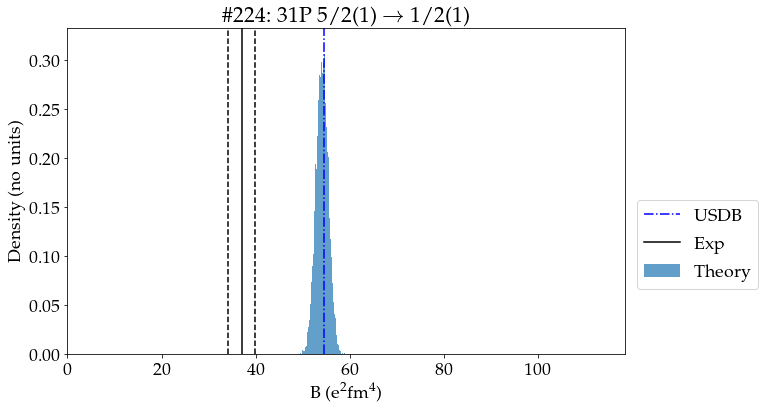

Relative Error (wrt USDB) =  -0.4720023795649842
----------------------------------------
----------------------------------------
INDEX =  225
False
USDB:
Mp = 0.1472
Mn = -0.364
Dropped 2 outliers.
Standard Deviations:
    Proton = 0.039506326237514
    Neutron = 0.038783277927220604
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  1.08
Bexp (W.u.) NNDC = 	 0.024
Bexp (W.u.) derived = 	 0.030890537914339718
Bth (USDB) (W.u.) = 	 0.003237682297185047
Bexp (e2fm4) converted from Wu = 	 0.1388388862312509
Bexp (e2fm4) derived = 	 0.17870032829629814
Bth (USDB) (e2fm4) = 	 0.01872984183799208
NNDC rel. err. = 28.7 %


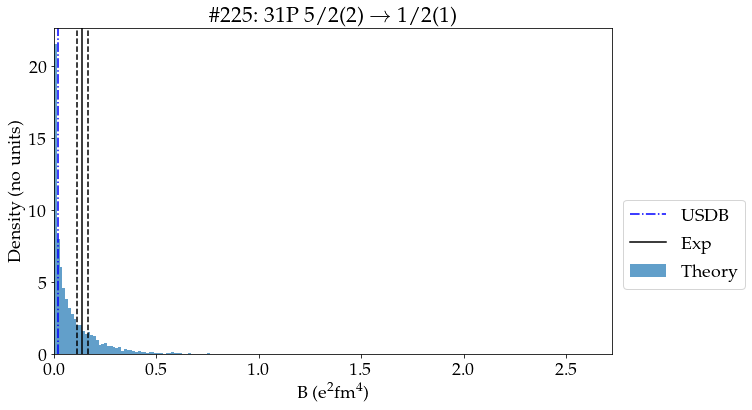

Relative Error (wrt USDB) =  0.8650965709506231
----------------------------------------
----------------------------------------
INDEX =  226
False
USDB:
Mp = 1.2105
Mn = 1.3526
Dropped 1 outliers.
Standard Deviations:
    Proton = 0.008637638458957186
    Neutron = 0.011238295989080473
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 9.5
Bexp (W.u.) derived = 	 9.748637774117483
Bth (USDB) (W.u.) = 	 13.356242105768958
Bexp (e2fm4) converted from Wu = 	 54.95705913320349
Bexp (e2fm4) derived = 	 56.39541711793219
Bth (USDB) (e2fm4) = 	 77.26524075832916
NNDC rel. err. = 2.6 %


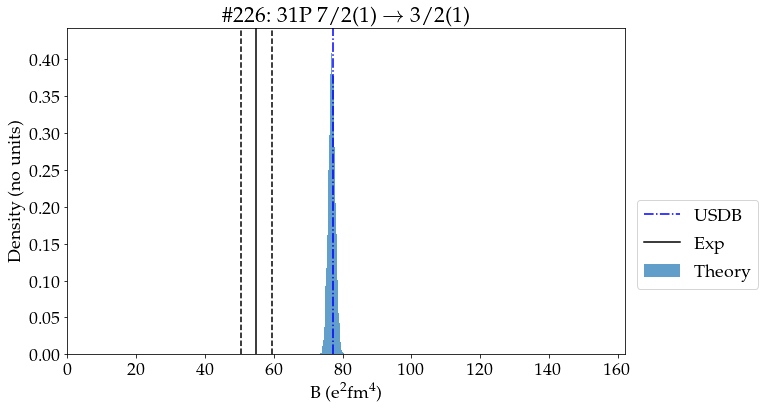

Relative Error (wrt USDB) =  -0.4059202216598905
----------------------------------------
----------------------------------------
INDEX =  227
False
USDB:
Mp = 0.049
Mn = -0.2522
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.027345708651391763
    Neutron = 0.12105486560803778
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  9.0
Bexp (W.u.) NNDC = 	 0.1
Bexp (W.u.) derived = 	 0.2986034764641848
Bth (USDB) (W.u.) = 	 0.0059503466578274085
Bexp (e2fm4) converted from Wu = 	 0.5784953592968789
Bexp (e2fm4) derived = 	 1.727407254044457
Bth (USDB) (e2fm4) = 	 0.03442247927760849
NNDC rel. err. = 198.6 %


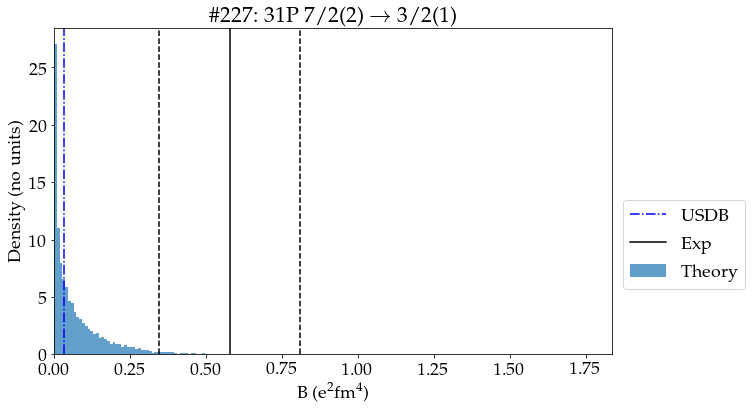

Relative Error (wrt USDB) =  0.940496533421726
----------------------------------------
----------------------------------------
INDEX =  228
False
USDB:
Mp = 0.4511
Mn = 0.4362
Dropped 1 outliers.
Standard Deviations:
    Proton = 0.023615151151597177
    Neutron = 0.016762453915011064
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 2.4
Bexp (W.u.) derived = 	 5.654981395371344
Bth (USDB) (W.u.) = 	 1.721766262109287
Bexp (e2fm4) converted from Wu = 	 13.883888623125092
Bexp (e2fm4) derived = 	 32.71380494132511
Bth (USDB) (e2fm4) = 	 9.96033792424156
NNDC rel. err. = 135.6 %


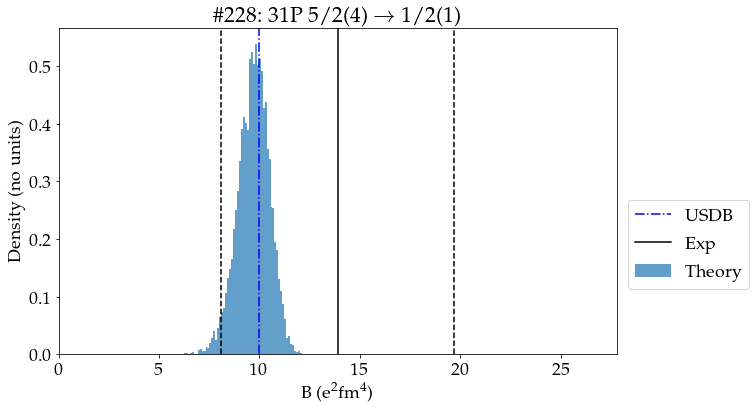

Relative Error (wrt USDB) =  0.28259739078779705
----------------------------------------
----------------------------------------
INDEX =  229
False
USDB:
Mp = 0.5345
Mn = 0.2525
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.05288356592459782
    Neutron = 0.07699798347809879
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  19.0
Bexp (W.u.) NNDC = 	 1.4
Bexp (W.u.) derived = 	 1.7743197887774222
Bth (USDB) (W.u.) = 	 1.852109809370687
Bexp (e2fm4) converted from Wu = 	 8.098935030156303
Bexp (e2fm4) derived = 	 10.26435763716357
Bth (USDB) (e2fm4) = 	 10.714369296291693
NNDC rel. err. = 26.7 %


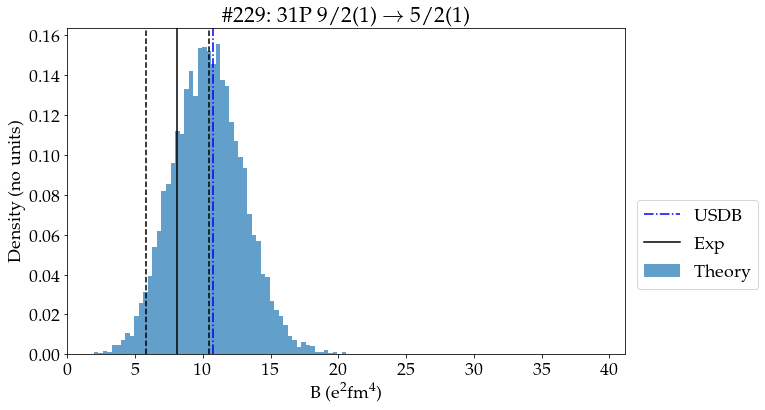

Relative Error (wrt USDB) =  -0.3229355781219193
----------------------------------------
----------------------------------------
INDEX =  230
False
USDB:
Mp = 0.7241
Mn = 0.8147
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.028147189993346054
    Neutron = 0.022141480433151783
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  4.9
Bexp (W.u.) NNDC = 	 2.9
Bexp (W.u.) derived = 	 3.688837476463605
Bth (USDB) (W.u.) = 	 4.797127189358794
Bexp (e2fm4) converted from Wu = 	 16.776365419609487
Bexp (e2fm4) derived = 	 21.33975361334605
Bth (USDB) (e2fm4) = 	 27.751158170009422
NNDC rel. err. = 27.2 %


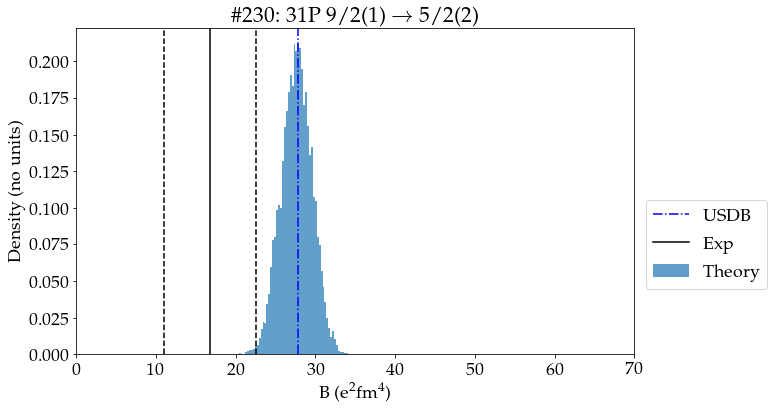

Relative Error (wrt USDB) =  -0.6541817894340669
----------------------------------------
----------------------------------------
INDEX =  231
False
USDB:
Mp = 0.0839
Mn = -0.0059
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.03286923751548786
    Neutron = 0.03727046891159316
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  57.0
Bexp (W.u.) NNDC = 	 0.43
Bexp (W.u.) derived = 	 1.3613761930656278
Bth (USDB) (W.u.) = 	 0.032484377236173353
Bexp (e2fm4) converted from Wu = 	 2.487530044976579
Bexp (e2fm4) derived = 	 7.875498099457175
Bth (USDB) (e2fm4) = 	 0.18792061480775457
NNDC rel. err. = 216.6 %


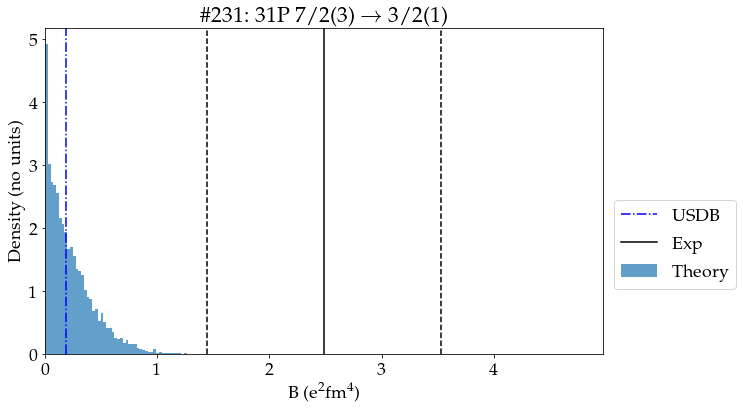

Relative Error (wrt USDB) =  0.924454936660062
----------------------------------------
----------------------------------------
INDEX =  232
False
USDB:
Mp = 0.5382
Mn = 0.9445
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.13083514002628893
    Neutron = 0.12379159990604757
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 5.4
Bexp (W.u.) derived = 	 6.484831621364872
Bth (USDB) (W.u.) = 	 3.521156287419152
Bexp (e2fm4) converted from Wu = 	 31.23874940203146
Bexp (e2fm4) derived = 	 37.514449987812334
Bth (USDB) (e2fm4) = 	 20.369725716310064
NNDC rel. err. = 20.1 %


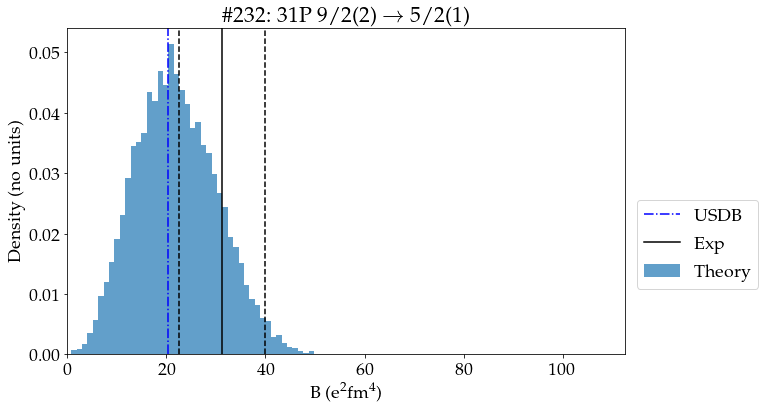

Relative Error (wrt USDB) =  0.34793402084830516
----------------------------------------
----------------------------------------
INDEX =  233
False
USDB:
Mp = 0.8879
Mn = 0.9051
Dropped 1 outliers.
Standard Deviations:
    Proton = 0.0754809467519172
    Neutron = 0.1252949651876303
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 3.3
Bexp (W.u.) derived = 	 5.287924896365067
Bth (USDB) (W.u.) = 	 6.847865293491259
Bexp (e2fm4) converted from Wu = 	 19.090346856797
Bexp (e2fm4) derived = 	 30.590400128576203
Bth (USDB) (e2fm4) = 	 39.61458293374853
NNDC rel. err. = 60.2 %


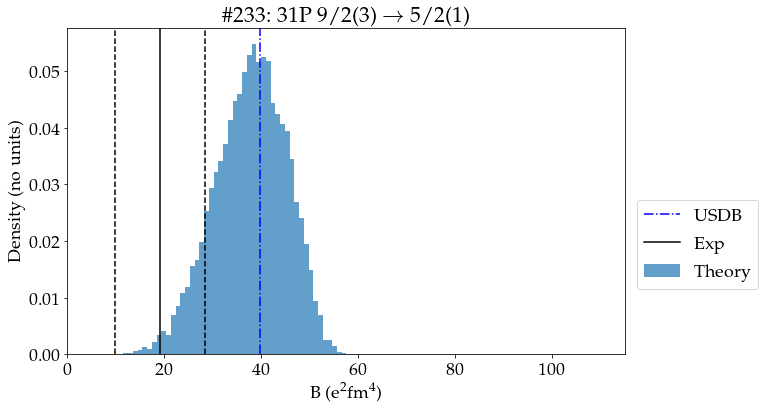

Relative Error (wrt USDB) =  -1.0751106949973515
----------------------------------------
----------------------------------------
INDEX =  237
False
USDB:
Mp = 0.4193
Mn = -0.2318
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.0330721177869433
    Neutron = 0.02413335564323059
b^2 =  3.5867808969962436
Thalf units =  FS
Intensity (%) =  7.0
Bexp (W.u.) NNDC = 	 0.07
Bexp (W.u.) derived = 	 0.09338230804561803
Bth (USDB) (W.u.) = 	 0.5385502178619449
Bexp (e2fm4) converted from Wu = 	 0.4401502107316768
Bexp (e2fm4) derived = 	 0.5871748937841305
Bth (USDB) (e2fm4) = 	 3.3863284554503643
NNDC rel. err. = 33.4 %


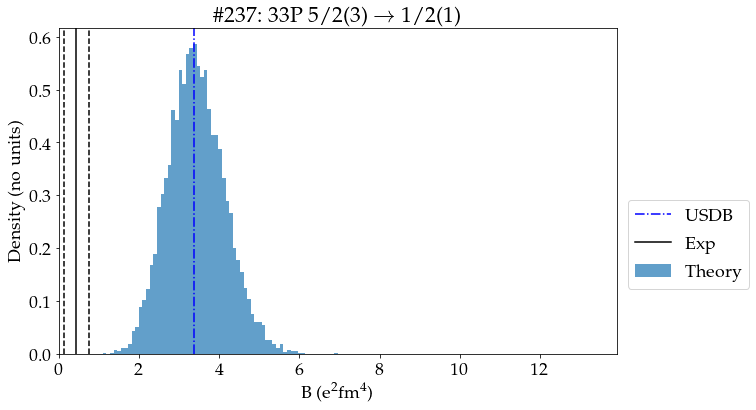

Relative Error (wrt USDB) =  -6.693574540884928
----------------------------------------
----------------------------------------
INDEX =  238
False
USDB:
Mp = 0.287
Mn = -0.3502
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.026741498139242578
    Neutron = 0.013364277725920672
b^2 =  3.5867808969962436
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 0.64
Bexp (W.u.) derived = 	 0.6665675944394632
Bth (USDB) (W.u.) = 	 0.13345922786085868
Bexp (e2fm4) converted from Wu = 	 4.024230498118188
Bexp (e2fm4) derived = 	 4.19128381656338
Bth (USDB) (e2fm4) = 	 0.8391729609577688
NNDC rel. err. = 4.2 %


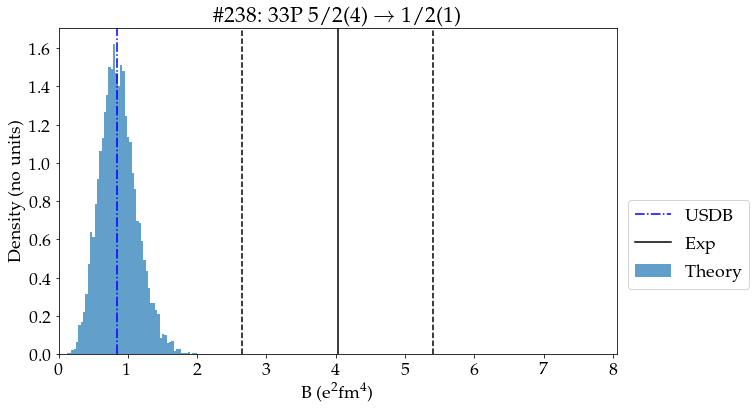

Relative Error (wrt USDB) =  0.7914699564674083
----------------------------------------
----------------------------------------
INDEX =  239
False
USDB:
Mp = 1.0869
Mn = 1.033
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.020891778506644247
    Neutron = 0.015217065526271693
b^2 =  3.5272425871522533
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 7.8
Bexp (W.u.) derived = 	 7.906796390268904
Bth (USDB) (W.u.) = 	 9.912294171753837
Bexp (e2fm4) converted from Wu = 	 45.12263802515655
Bexp (e2fm4) derived = 	 45.74045018675874
Bth (USDB) (e2fm4) = 	 57.34216178345094
NNDC rel. err. = 1.4 %


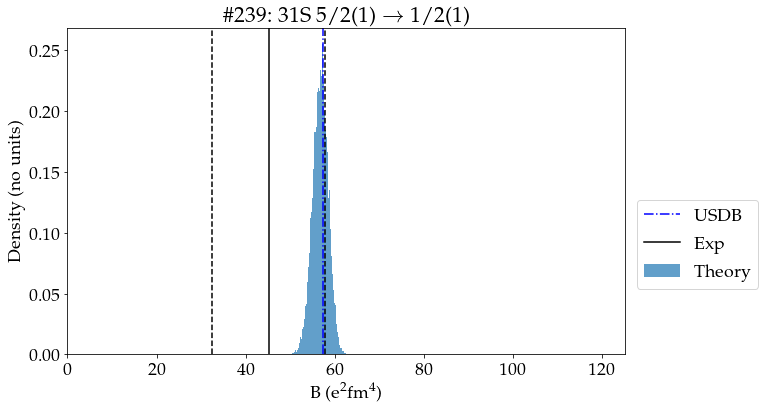

Relative Error (wrt USDB) =  -0.2708069450966458
----------------------------------------
----------------------------------------
INDEX =  240
False
USDB:
Mp = 1.1536
Mn = 1.1536
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.041151228510603745
    Neutron = 0.041151228510603745
b^2 =  3.557321893542759
Thalf units =  PS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 11.8
Bexp (W.u.) derived = 	 11.808988002497438
Bth (USDB) (W.u.) = 	 11.161756858311291
Bexp (e2fm4) converted from Wu = 	 71.214145246564
Bexp (e2fm4) derived = 	 71.26838871396477
Bth (USDB) (e2fm4) = 	 67.36228594191628
NNDC rel. err. = 0.1 %


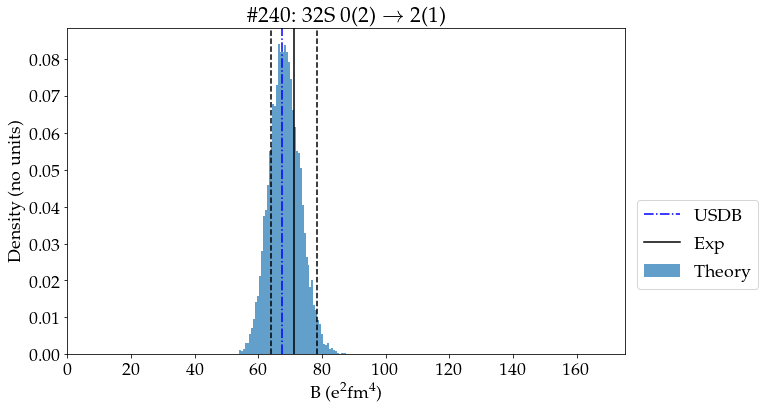

Relative Error (wrt USDB) =  0.05408840183802621
----------------------------------------
----------------------------------------
INDEX =  241
False
USDB:
Mp = 1.3039
Mn = 1.3039
Dropped 1 outliers.
Standard Deviations:
    Proton = 0.013128142668883139
    Neutron = 0.013128142668883139
b^2 =  3.557321893542759
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 14.0
Bexp (W.u.) derived = 	 13.715691832517049
Bth (USDB) (W.u.) = 	 14.259708043098737
Bexp (e2fm4) converted from Wu = 	 84.49135876710983
Bexp (e2fm4) derived = 	 82.77553138287972
Bth (USDB) (e2fm4) = 	 86.05872201312121
NNDC rel. err. = 2.0 %


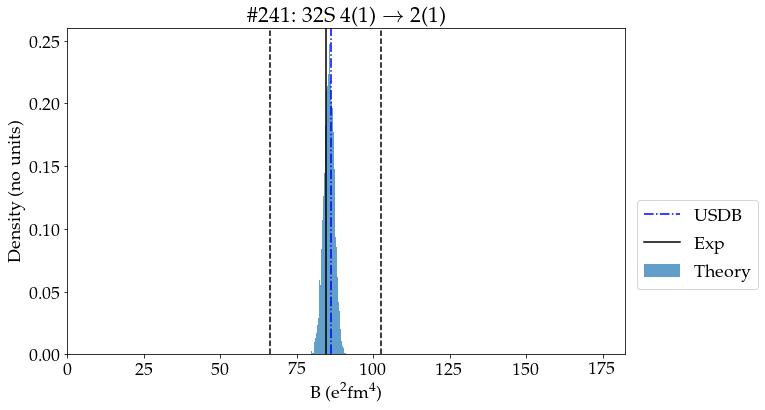

Relative Error (wrt USDB) =  -0.018550574507052595
----------------------------------------
----------------------------------------
INDEX =  242
False
USDB:
Mp = 0.7628
Mn = 0.7628
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.03158345791790845
    Neutron = 0.03158345791790845
b^2 =  3.557321893542759
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 8.0
Bexp (W.u.) derived = 	 12.638455281160667
Bth (USDB) (W.u.) = 	 4.880265301916944
Bexp (e2fm4) converted from Wu = 	 48.28077643834848
Bexp (e2fm4) derived = 	 76.27430424447284
Bth (USDB) (e2fm4) = 	 29.452874750210153
NNDC rel. err. = 58.0 %


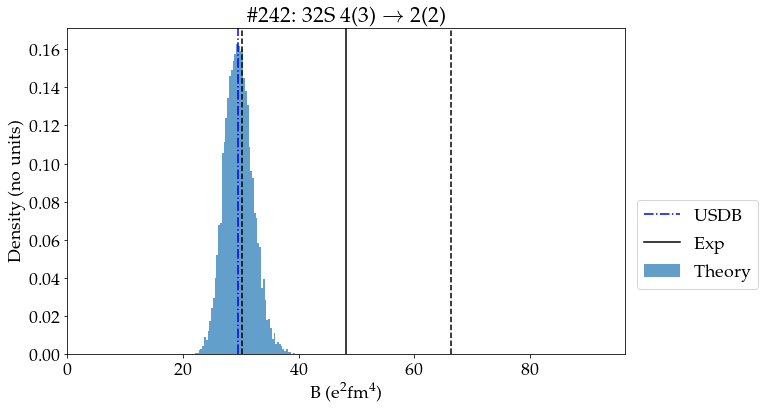

Relative Error (wrt USDB) =  0.389966837260382
----------------------------------------
----------------------------------------
INDEX =  243
False
USDB:
Mp = 0.6913
Mn = 0.852
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.03926786492362077
    Neutron = 0.02716537790394475
b^2 =  3.5867808969962436
Thalf units =  FS
Intensity (%) =  7.5
Bexp (W.u.) NNDC = 	 37.0
Bexp (W.u.) derived = 	 39.62800687334356
Bth (USDB) (W.u.) = 	 4.378907674511375
Bexp (e2fm4) converted from Wu = 	 232.65082567245773
Bexp (e2fm4) derived = 	 249.17536537397862
Bth (USDB) (e2fm4) = 	 27.533959081581973
NNDC rel. err. = 7.1 %


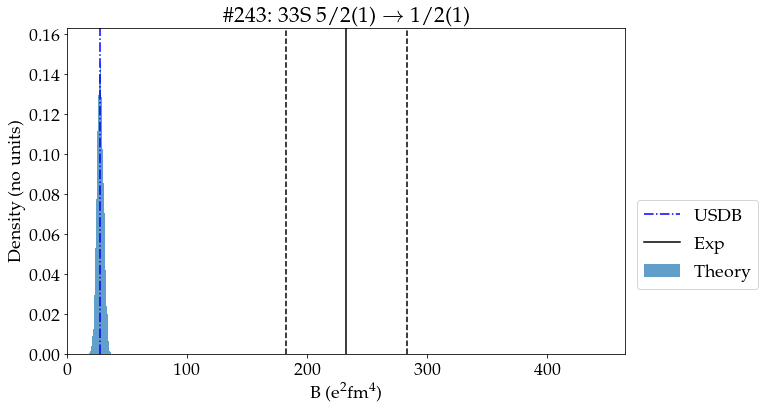

Relative Error (wrt USDB) =  0.8816511439321251
----------------------------------------
----------------------------------------
INDEX =  244
False
USDB:
Mp = 0.9258
Mn = 0.7094
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.032491518080941924
    Neutron = 0.03524356439125052
b^2 =  3.5867808969962436
Thalf units =  FS
Intensity (%) =  1.5
Bexp (W.u.) NNDC = 	 3.6
Bexp (W.u.) derived = 	 3.6524820006979017
Bth (USDB) (W.u.) = 	 6.218718601377967
Bexp (e2fm4) converted from Wu = 	 22.636296551914807
Bexp (e2fm4) derived = 	 22.966296032869113
Bth (USDB) (e2fm4) = 	 39.10243289825015
NNDC rel. err. = 1.5 %


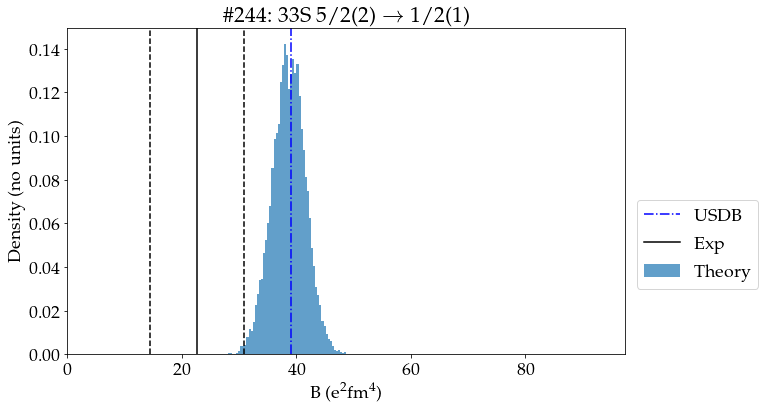

Relative Error (wrt USDB) =  -0.7274218337161019
----------------------------------------
----------------------------------------
INDEX =  245
False
USDB:
Mp = 0.2482
Mn = 0.4297
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.030416228437784486
    Neutron = 0.016530065019718945
b^2 =  3.5867808969962436
Thalf units =  FS
Intensity (%) =  5.7
Bexp (W.u.) NNDC = 	 0.09
Bexp (W.u.) derived = 	 0.14337525206416318
Bth (USDB) (W.u.) = 	 0.7053504576426733
Bexp (e2fm4) converted from Wu = 	 0.5659074137978701
Bexp (e2fm4) derived = 	 0.9015235344249815
Bth (USDB) (e2fm4) = 	 4.435145036730105
NNDC rel. err. = 59.3 %


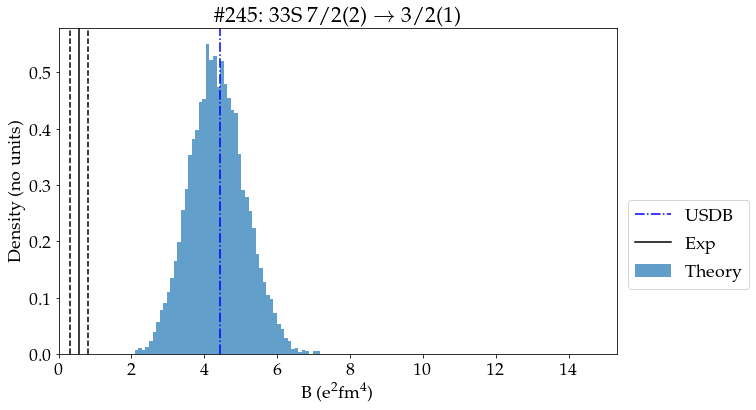

Relative Error (wrt USDB) =  -6.837227307140815
----------------------------------------
----------------------------------------
INDEX =  246
False
USDB:
Mp = 0.8888
Mn = 1.0931
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.024138744397359385
    Neutron = 0.011727564761870228
b^2 =  3.615650621149735
Thalf units =  FS
Intensity (%) =  100.0
Bexp (W.u.) NNDC = 	 6.24
Bexp (W.u.) derived = 	 6.233044006615426
Bth (USDB) (W.u.) = 	 7.059656869464373
Bexp (e2fm4) converted from Wu = 	 40.82950361416838
Bexp (e2fm4) derived = 	 40.78398923002806
Bth (USDB) (e2fm4) = 	 46.19267398502953
NNDC rel. err. = 0.1 %


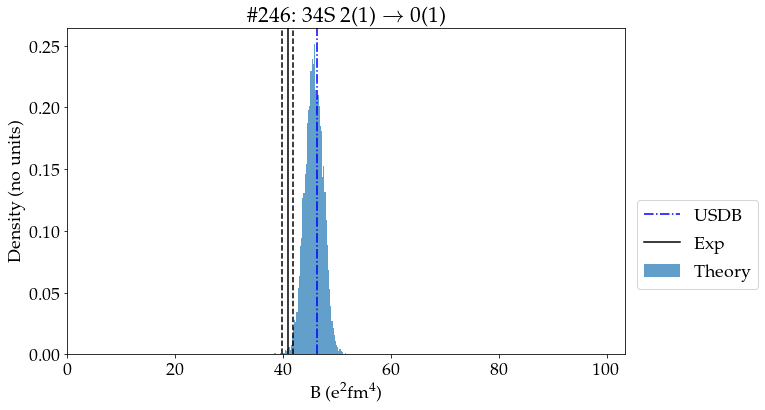

Relative Error (wrt USDB) =  -0.13135526754236748
----------------------------------------
----------------------------------------


In [23]:
relative_errors_usdb = []
# for index in list(df_usdb['Index']):
for index in list(ti_list):
    nuc_dict, Mth_p_usdb, Mth_n_usdb, Mth_p_vec, Mth_n_vec, title_string = matrix_element_distributions(index)
#     print('INDEX = ',index)
    t_usdb = df_usdb[df_usdb['GlobalIndex']==index].iloc[0]
    b2 = 0.9*nuc_dict['A']**(1/3) + 0.7      #Blomqvist and Molinari formula (units = fm^2)
    print('b^2 = ',b2)
    e_p = 1.5
    e_n = 0.5
    Bexp_e2fm4 = t_usdb['B_exp (e^2fm^4)']
    Bexp_unc_e2fm4 = t_usdb['B_exp Unc (e^2fm^4)']
    Bth_e2fm4 = b2**2 * ( e_p * Mth_p_vec + e_n * Mth_n_vec)**2
    Bth_usdb_e2fm4 = b2**2 * ( e_p * Mth_p_usdb + e_n * Mth_n_usdb)**2
    Egamma = t_usdb['E_gamma (keV)']
    print('Thalf units = ',t_usdb['Thalf Units'])
    Thalf = thalf_units_to_sec(t_usdb['Thalf Units'],t_usdb['Thalf Value'])
    I = t_usdb['I_gamma']
    A = t_usdb['A']
    print('Intensity (%) = ',I)
    print("Bexp (W.u.) NNDC = \t",t_usdb['B_exp (W.u.)'])
    print("Bexp (W.u.) derived = \t",BEl_in_Wu(2,Egamma,Thalf,I,A))
    print("Bth (USDB) (W.u.) = \t",Bth_usdb_e2fm4/Bweisskopf(2,A))
    print("Bexp (e2fm4) converted from Wu = \t",Bexp_e2fm4)
    print("Bexp (e2fm4) derived = \t", BE2_e2fm4(Egamma,Thalf,I))
    print("Bth (USDB) (e2fm4) = \t",Bth_usdb_e2fm4)
    
    nndc_rel_err = 100*abs(t_usdb['B_exp (W.u.)'] - BEl_in_Wu(2,Egamma,Thalf,I,A))/t_usdb['B_exp (W.u.)']
    print(f'NNDC rel. err. = {nndc_rel_err:.1f} %')
    
    use_bayes_blocks = False
    plt.figure(figsize=(10,6))
    constant_B = np.std(Bth_e2fm4)<10.**-12
    if constant_B:
        bins = 1
    else:
        if use_bayes_blocks:
            bins = bayesian_blocks_mod(Bth_e2fm4)
        else:
            bins = optimal_n_bins(Bth_e2fm4)
    plt.hist(Bth_e2fm4,bins=bins,density=True,label='Theory',alpha=0.7)
    plt.axvline(Bth_usdb_e2fm4,ls='-.',c='blue',label='USDB')
    
    plt.axvline(Bexp_e2fm4,ls='-',c='k',label='Exp')
    plt.axvline(Bexp_e2fm4 + Bexp_unc_e2fm4,ls='--',c='k')
    plt.axvline(Bexp_e2fm4 - Bexp_unc_e2fm4,ls='--',c='k')
    
    plt.xlabel(r'B (e$^2$fm$^4$)')
    plt.title(title_string)
    plt.ylabel('Density (no units)')
    plt.legend(loc=(1.02,0.2))
    plt.xlim([0,2*max(Bexp_e2fm4,np.max(Bth_e2fm4))])
#     plt.xlim([0.5*min(Bexp_e2fm4,np.min(Bth_e2fm4)),2*max(Bexp_e2fm4,np.max(Bth_e2fm4))])
    plt.show()
    

    
    relative_errors_usdb.append((Bexp_e2fm4 - Bth_usdb_e2fm4)/Bexp_e2fm4)
    print('Relative Error (wrt USDB) = ',relative_errors_usdb[-1])
    print('-'*40)
    print('-'*40)
    

In [ ]:
# B(E2) discributions in W.u.

relative_errors_usdb = []
with PdfPages('E2_B_histograms.pdf') as pdf:
    for index in list(ti_list):
        nuc_dict, Mth_p_usdb, Mth_n_usdb, Mth_p_vec, Mth_n_vec, title_string = matrix_element_distributions(index)
    #     print('INDEX = ',index)
        t_usdb = df_usdb[df_usdb['GlobalIndex']==index].iloc[0]
        b2 = 0.9*nuc_dict['A']**(1/3) + 0.7      #Blomqvist and Molinari formula (units = fm^2)
        print('b^2 = ',b2)
        e_p = 1.36   # Brown and Wildenthal USDB values
        e_n = 0.45
        
        Bexp_Wu = t_usdb['B_exp (W.u.)']
        Bexp_unc_Wu = t_usdb['B_exp Unc (W.u.)']
        Bth_e2fm4 = b2**2 * ( e_p * Mth_p_vec + e_n * Mth_n_vec)**2
        Bth_Wu = Bth_e2fm4 / Bweisskopf(2,nuc_dict['A']) 
        Bth_usdb_e2fm4 = b2**2 * ( e_p * Mth_p_usdb + e_n * Mth_n_usdb)**2
        Bth_usdb_Wu = Bth_usdb_e2fm4/Bweisskopf(2,nuc_dict['A'])
        
        Egamma = t_usdb['E_gamma (keV)']
        print('Thalf units = ',t_usdb['Thalf Units'])
        Thalf = thalf_units_to_sec(t_usdb['Thalf Units'],t_usdb['Thalf Value'])
        I = t_usdb['I_gamma']
        A = t_usdb['A']
        print("Bexp (W.u.) NNDC = \t",t_usdb['B_exp (W.u.)'])
        print("Bexp (W.u.) derived = \t",BEl_in_Wu(2,Egamma,Thalf,I,A))
        print("Bth (USDB) (W.u.) = \t",Bth_usdb_Wu)
#         print("Bexp (e2fm4) converted from Wu = \t",Bexp_e2fm4)
#         print("Bexp (e2fm4) derived = \t", BE2_e2fm4(Egamma,Thalf,I))
#         print("Bth (USDB) (e2fm4) = \t",Bth_usdb_e2fm4)

        constant_B = np.std(Bth_Wu)<10.**-12
        if constant_B:
            bins = 1
        else:
            bins = optimal_n_bins(Bth_Wu)//2
        
        plt.figure(figsize=(10,6))    
#         plt.hist(Bth_Wu, bins=bins, density=True, label='Theory', alpha=0.7)
        plt.hist(Bth_Wu, bins=bins, histtype='step', density=True, color='k', label='Theory')
        plt.axvline(Bth_usdb_Wu,ls='--',c='k',label='USDB')
        plt.axvline(Bexp_Wu,ls='-',c='r',label='Experiment')
        plt.axvline(Bexp_Wu+Bexp_unc_Wu,ls=':',c='r')
        plt.axvline(Bexp_Wu-Bexp_unc_Wu,ls=':',c='r')
        
        if t_usdb['Include']:
            inc_str = 'Included in UQ'
        else:
            inc_str = 'Excluded from UQ'
#         title_string += "\n" + inc_str
        
        plt.xlabel(r'B (W.u.)')
        plt.title(title_string)
        plt.ylabel('Density (no units)')
        plt.legend(loc=(1.02,0.2))
        
        Bmax = max(Bexp_Wu+Bexp_unc_Wu,np.max(Bth_Wu))
        Bmin = min(Bexp_Wu-Bexp_unc_Wu,np.min(Bth_Wu))
        Brange = Bmax - Bmin
        plt.xlim([Bmin - 0.5*Brange,Bmax + 0.5*Brange])
    #     plt.xlim([0.5*min(Bexp_e2fm4,np.min(Bth_e2fm4)),2*max(Bexp_e2fm4,np.max(Bth_e2fm4))])
#         plt.show()

        plt.tight_layout()
        pdf.savefig()
        plt.close()

        relative_errors_usdb.append((Bexp_Wu - Bth_usdb_Wu)/Bexp_Wu)
        print('Relative Error (wrt USDB) = ',relative_errors_usdb[-1])
        print('-'*40)
        print('-'*40)


INDEX =  4
False
Proton parts are all zero
USDB:
Mp = 0.0
Mn = 1.5451
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.0
    Neutron = 4.440892098500626e-16
b^2 =  3.014153431592412
Thalf units =  PS
Bexp (W.u.) NNDC = 	 2.39
Bexp (W.u.) derived = 	 2.4274025112322772
Bth (USDB) (W.u.) = 	 1.6914249842217706
Relative Error (wrt USDB) =  0.2922908015808492
----------------------------------------
----------------------------------------
INDEX =  5
False
Proton parts are all zero
USDB:
Mp = 0.0
Mn = 1.309
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.0
    Neutron = 0.007524829195599322
b^2 =  3.0586672547880065
Thalf units =  PS
Bexp (W.u.) NNDC = 	 3.32
Bexp (W.u.) derived = 	 3.3996121401603094
Bth (USDB) (W.u.) = 	 1.1583891834283888
Relative Error (wrt USDB) =  0.6510875953528948
----------------------------------------
----------------------------------------
INDEX =  6
False
Proton parts are all zero
USDB:
Mp = 0.0
Mn = 1.1707
Dropped 0 outliers.
Standard Deviatio

Relative Error (wrt USDB) =  0.995524136759235
----------------------------------------
----------------------------------------
INDEX =  23
False
USDB:
Mp = 0.0124
Mn = -0.0124
Dropped 2 outliers.
Standard Deviations:
    Proton = 0.016082290831794726
    Neutron = 0.016082290831794726
b^2 =  3.0586672547880065
Thalf units =  KEV
Bexp (W.u.) NNDC = 	 9.0
Bexp (W.u.) derived = 	 50.7499373566035
Bth (USDB) (W.u.) = 	 0.00042508553604448095
Relative Error (wrt USDB) =  0.9999527682737729
----------------------------------------
----------------------------------------
INDEX =  24
False
USDB:
Mp = 0.0323
Mn = -0.0323
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.015160425855684476
    Neutron = 0.015160425855684476
b^2 =  3.0586672547880065
Thalf units =  KEV
Bexp (W.u.) NNDC = 	 1.0
Bexp (W.u.) derived = 	 6.052102102131634
Bth (USDB) (W.u.) = 	 0.0028842838768200233
Relative Error (wrt USDB) =  0.99711571612318
----------------------------------------
------------------------

Relative Error (wrt USDB) =  0.33158359302870544
----------------------------------------
----------------------------------------
INDEX =  43
False
USDB:
Mp = 0.9528
Mn = 0.9528
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.005010866044213774
    Neutron = 0.005010866044213774
b^2 =  3.1429758549354156
Thalf units =  KEV
Bexp (W.u.) NNDC = 	 9.0
Bexp (W.u.) derived = 	 41.80937828708466
Bth (USDB) (W.u.) = 	 9.110001620524292
Relative Error (wrt USDB) =  -0.012222402280476885
----------------------------------------
----------------------------------------
INDEX =  44
False
USDB:
Mp = 1.1052
Mn = 1.4851
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.006774082079101019
    Neutron = 0.004060700798707273
b^2 =  3.2218353975898477
Thalf units =  PS
Bexp (W.u.) NNDC = 	 12.76
Bexp (W.u.) derived = 	 12.749242416620364
Bth (USDB) (W.u.) = 	 13.364682171073326
Relative Error (wrt USDB) =  -0.04738888488035475
----------------------------------------
----------------------

Relative Error (wrt USDB) =  0.15919445546331057
----------------------------------------
----------------------------------------
INDEX =  62
False
USDB:
Mp = 1.0026
Mn = 1.1886
Dropped 1 outliers.
Standard Deviations:
    Proton = 0.005311321302757593
    Neutron = 0.004182907967315645
b^2 =  3.2594802818664093
Thalf units =  FS
Bexp (W.u.) NNDC = 	 12.2
Bexp (W.u.) derived = 	 13.62921667592901
Bth (USDB) (W.u.) = 	 9.854172859113296
Relative Error (wrt USDB) =  0.19228091318743468
----------------------------------------
----------------------------------------
INDEX =  63
False
USDB:
Mp = 0.5171
Mn = 1.0317
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.017352800066312953
    Neutron = 0.02135191925520941
b^2 =  3.2594802818664093
Thalf units =  PS
Bexp (W.u.) NNDC = 	 2.9
Bexp (W.u.) derived = 	 4.482156992735172
Bth (USDB) (W.u.) = 	 3.727102893516895
Relative Error (wrt USDB) =  -0.2852078943161708
----------------------------------------
------------------------------

Relative Error (wrt USDB) =  0.585857897493083
----------------------------------------
----------------------------------------
INDEX =  84
False
USDB:
Mp = 0.1598
Mn = 0.8185
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.015484712185827993
    Neutron = 0.022406964709352682
b^2 =  3.3316159643915793
Thalf units =  NS
Bexp (W.u.) NNDC = 	 0.563
Bexp (W.u.) derived = 	 0.5619867187070055
Bth (USDB) (W.u.) = 	 0.8767039858179174
Relative Error (wrt USDB) =  -0.5572006852893739
----------------------------------------
----------------------------------------
INDEX =  85
False
USDB:
Mp = 1.4525
Mn = 1.4461
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.0030920841455047317
    Neutron = 0.009005054267540565
b^2 =  3.3316159643915793
Thalf units =  PS
Bexp (W.u.) NNDC = 	 15.8
Bexp (W.u.) derived = 	 37.217891430742704
Bth (USDB) (W.u.) = 	 17.62826780263348
Relative Error (wrt USDB) =  -0.11571315206541012
----------------------------------------
------------------------

Relative Error (wrt USDB) =  -0.12897429302575159
----------------------------------------
----------------------------------------
INDEX =  104
False
USDB:
Mp = 0.8289
Mn = 1.2806
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.03255059357960617
    Neutron = 0.043780594591225686
b^2 =  3.366246461566633
Thalf units =  FS
Bexp (W.u.) NNDC = 	 7.4
Bexp (W.u.) derived = 	 7.958906589196746
Bth (USDB) (W.u.) = 	 7.187288447174722
Relative Error (wrt USDB) =  0.02874480443584845
----------------------------------------
----------------------------------------
INDEX =  105
False
USDB:
Mp = 0.443
Mn = 0.5358
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.042028628789586575
    Neutron = 0.03498745869726019
b^2 =  3.366246461566633
Thalf units =  FS
Bexp (W.u.) NNDC = 	 1.1
Bexp (W.u.) derived = 	 2.216890312896075
Bth (USDB) (W.u.) = 	 1.7624058029405127
Relative Error (wrt USDB) =  -0.6021870935822842
----------------------------------------
-------------------------------

Relative Error (wrt USDB) =  -1.8169846664288007
----------------------------------------
----------------------------------------
INDEX =  123
False
USDB:
Mp = 1.2461
Mn = 1.2461
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.01197562587587586
    Neutron = 0.01197562587587586
b^2 =  3.366246461566633
Thalf units =  FS
Bexp (W.u.) NNDC = 	 12.6
Bexp (W.u.) derived = 	 16.686749832906845
Bth (USDB) (W.u.) = 	 12.598127810369359
Relative Error (wrt USDB) =  0.00014858647862227138
----------------------------------------
----------------------------------------
INDEX =  124
False
USDB:
Mp = 0.0453
Mn = 0.0453
Dropped 10 outliers.
Standard Deviations:
    Proton = 0.10582966705915975
    Neutron = 0.10582966705915975
b^2 =  3.366246461566633
Thalf units =  FS
Bexp (W.u.) NNDC = 	 2.9
Bexp (W.u.) derived = 	 3.2289408456587623
Bth (USDB) (W.u.) = 	 0.016649324657641483
Relative Error (wrt USDB) =  0.9942588535663306
----------------------------------------
------------------------

Relative Error (wrt USDB) =  0.6795749880918741
----------------------------------------
----------------------------------------
INDEX =  143
False
USDB:
Mp = 0.7023
Mn = 0.7023
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.16036703789550022
    Neutron = 0.16036703789550022
b^2 =  3.366246461566633
Thalf units =  FS
Bexp (W.u.) NNDC = 	 1.3
Bexp (W.u.) derived = 	 1.3779923954765558
Bth (USDB) (W.u.) = 	 4.001709468185786
Relative Error (wrt USDB) =  -2.0782380524506046
----------------------------------------
----------------------------------------
INDEX =  144
False
USDB:
Mp = 0.2534
Mn = 0.2534
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.024974653672122326
    Neutron = 0.024974653672122326
b^2 =  3.366246461566633
Thalf units =  FS
Bexp (W.u.) NNDC = 	 0.19
Bexp (W.u.) derived = 	 0.27001872738004484
Bth (USDB) (W.u.) = 	 0.5209708683408747
Relative Error (wrt USDB) =  -1.7419519386361826
----------------------------------------
----------------------------

Relative Error (wrt USDB) =  0.3264454104220711
----------------------------------------
----------------------------------------
INDEX =  183
False
USDB:
Mp = 0.9687
Mn = 0.0962
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.01976635045613138
    Neutron = 0.025030738580148194
b^2 =  3.366246461566633
Thalf units =  FS
Bexp (W.u.) NNDC = 	 1.7
Bexp (W.u.) derived = 	 2.4608551703031116
Bth (USDB) (W.u.) = 	 4.585449144328761
Relative Error (wrt USDB) =  -1.6973230260757417
----------------------------------------
----------------------------------------
INDEX =  184
False
USDB:
Mp = 0.6559
Mn = 0.0268
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.028382111499631973
    Neutron = 0.018809419766227874
b^2 =  3.366246461566633
Thalf units =  PS
Bexp (W.u.) NNDC = 	 10.0
Bexp (W.u.) derived = 	 9.41408700789517
Bth (USDB) (W.u.) = 	 2.0242336264346936
Relative Error (wrt USDB) =  0.7975766373565307
----------------------------------------
-------------------------------

Relative Error (wrt USDB) =  -0.024362980625629947
----------------------------------------
----------------------------------------
INDEX =  215
False
USDB:
Mp = 0.7765
Mn = 0.0166
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.023192530539558557
    Neutron = 0.028566986454628577
b^2 =  3.4965092553584727
Thalf units =  FS
Bexp (W.u.) NNDC = 	 1.7
Bexp (W.u.) derived = 	 3.291889354692134
Bth (USDB) (W.u.) = 	 2.497122758674233
Relative Error (wrt USDB) =  -0.4688957403966076
----------------------------------------
----------------------------------------
INDEX =  216
False
USDB:
Mp = 0.1837
Mn = 0.2015
Dropped 0 outliers.
Standard Deviations:
    Proton = 0.021334868230691445
    Neutron = 0.01896448998501694
b^2 =  3.4965092553584727
Thalf units =  FS
Bexp (W.u.) NNDC = 	 0.17
Bexp (W.u.) derived = 	 0.38123459015998773
Bth (USDB) (W.u.) = 	 0.25598164515002925
Relative Error (wrt USDB) =  -0.5057743832354661
----------------------------------------
----------------------

In [23]:
# plt.hist(relative_errors_usdb,bins=optimal_n_bins(relative_errors_usdb),density=True)
# plt.xlabel(r'$(B_{exp} - B_{USDB})/B_{exp}$')
# plt.ylabel('Density (no units)')
# plt.title('B(E2) relative errors to USDB')
# plt.show()

In [24]:
# plt.hist(relative_errors_usdb,bins=optimal_n_bins(relative_errors_usdb),density=True)
# plt.xlabel(r'$(B_{exp} - B_{USDB})/B_{exp}$')
# plt.ylabel('Density (no units)')
# plt.title('B(E2) relative errors to USDB')
# plt.xlim([-10,5])
# plt.show()

  0%|          | 0/188 [00:00<?, ?it/s]

INDEX =  17
GlobalIndex                     17
A                               18
Element                          F
Z                                9
N                                9
Energy (keV)                 937.2
Energy Unc (keV)              0.06
Ji                               3
Thalf                  46.9 PS 1.7
E_gamma (keV)                937.0
E_gamma Unc (keV)              0.0
I_gamma                      100.0
I_gamma Unc                    0.0
Mult                            E2
Mult Ratio                     NaN
Mult Ratio Unc                 NaN
Conv Coef                      NaN
Conv Coef Unc                  NaN
B_exp (W.u.)                   5.8
B_exp Unc (W.u.)               0.2
twoJi                            6
Thalf Value                   46.9
Thalf Units                     PS
Thalf Unc                      1.7
Thalf (sec)                    0.0
Thalf Unc (sec)                0.0
B_exp (e^2fm^4)          16.253328
B_exp Unc (e^2fm^4)        0.56046
Nucleus 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


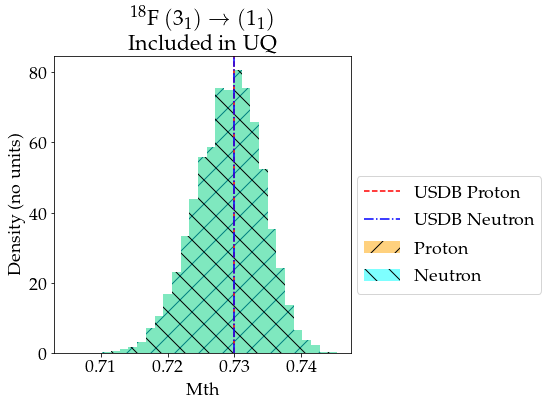

  1%|          | 1/188 [00:10<31:15, 10.03s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
13           17  18       F  9  9         937.2              0.06  3   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
13  46.9 PS 1.7          937.0  ...        16.253328              0.56046   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
13      18F  1      2   1   1     True  0.7299  0.7299  

[1 rows x 36 columns]
INDEX =  18
GlobalIndex                   18
A                             18
Element                        F
Z                              9
N                              9
Energy (keV)             1121.36
Energy Unc (keV)            0.15
Ji                             5
Thalf                   162 NS 7
E_gamma (keV)              184.0
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef              

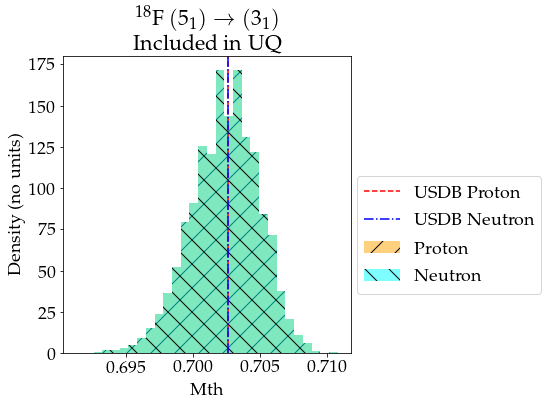

  1%|          | 2/188 [00:17<26:53,  8.67s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
14           18  18       F  9  9       1121.36              0.15  5   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
14  162 NS 7          184.0  ...        16.197282             0.700574   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
14      18F  3      6   1   1     True -0.7026 -0.7026  

[1 rows x 36 columns]
INDEX =  19
GlobalIndex                      19
A                                18
Element                           F
Z                                 9
N                                 9
Energy (keV)                 3358.2
Energy Unc (keV)                1.0
Ji                                3
Thalf                  0.30 PS 0.02
E_gamma (keV)                1657.0
E_gamma Unc (keV)               0.0
I_gamma                        40.0
I_gamma Unc                     4.0
Mult                             E2
Mult Ratio                      NaN
Mult Ratio Unc   

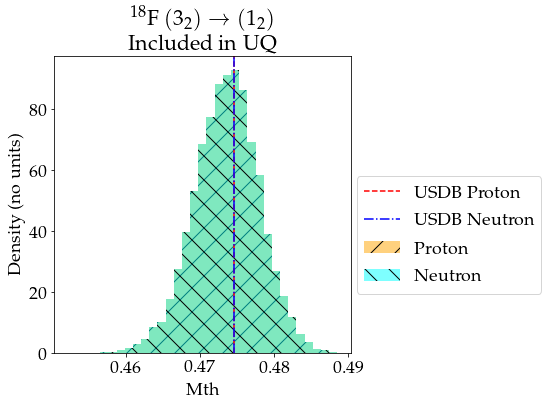

  2%|▏         | 3/188 [00:25<25:36,  8.31s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
15           19  18       F  9  9        3358.2               1.0  3   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
15  0.30 PS 0.02         1657.0  ...        58.848255             8.406894   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
15      18F  1      2   2   2     True -0.4746 -0.4746  

[1 rows x 36 columns]
INDEX =  20
GlobalIndex                      20
A                                18
Element                           F
Z                                 9
N                                 9
Energy (keV)                 3358.2
Energy Unc (keV)                1.0
Ji                                3
Thalf                  0.30 PS 0.02
E_gamma (keV)                3358.0
E_gamma Unc (keV)               0.0
I_gamma                        45.0
I_gamma Unc                     5.0
Mult                             E2
Mult Ratio                      NaN
Mult Rati

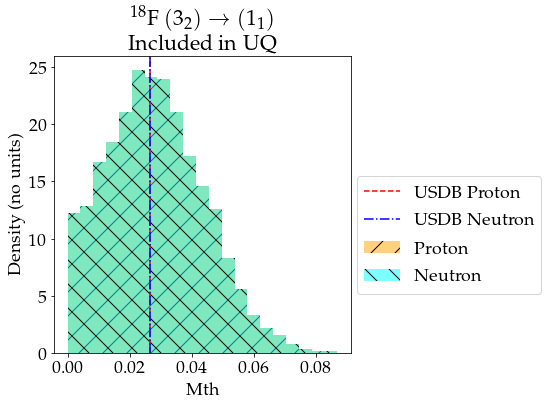

  2%|▏         | 4/188 [00:33<25:22,  8.27s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
16           20  18       F  9  9        3358.2               1.0  3   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
16  0.30 PS 0.02         3358.0  ...         1.933586             0.252207   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
16      18F  1      2   2   1     True  0.0267  0.0267  

[1 rows x 36 columns]
INDEX =  21
GlobalIndex                  21
A                            18
Element                       F
Z                             9
N                             9
Energy (keV)             4115.9
Energy Unc (keV)           0.25
Ji                            3
Thalf                  63 FS 15
E_gamma (keV)            4116.0
E_gamma Unc (keV)           0.0
I_gamma                     5.0
I_gamma Unc                 3.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv 

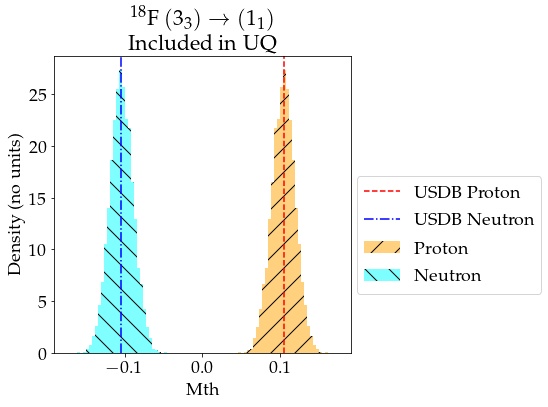

  3%|▎         | 5/188 [00:41<24:58,  8.19s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
17           21  18       F  9  9        4115.9              0.25  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
17  63 FS 15         4116.0  ...         0.420345             0.112092   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
17      18F  1      2   3   1     True  0.1052 -0.1052  

[1 rows x 36 columns]
INDEX =  22
GlobalIndex                   22
A                             18
Element                        F
Z                              9
N                              9
Energy (keV)              5297.6
Energy Unc (keV)             1.5
Ji                             4
Thalf                    21 FS 3
E_gamma (keV)             2775.0
E_gamma Unc (keV)            0.0
I_gamma                     78.0
I_gamma Unc                  3.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    

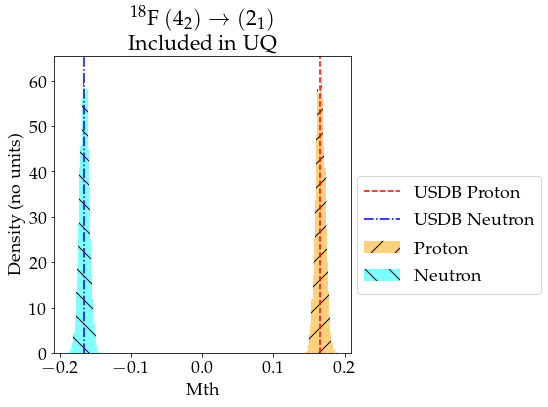

  3%|▎         | 6/188 [00:49<24:29,  8.07s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji    Thalf  \
18           22  18       F  9  9        5297.6               1.5  4  21 FS 3   

    E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  Nucleus Jf  \
18         2775.0  ...        47.639064            16.813787      18F  2   

    twoJf  ni  nf  Include   Mth_p   Mth_n  
18      4   2   1     True -0.1659  0.1659  

[1 rows x 36 columns]
INDEX =  23
GlobalIndex                       23
A                                 18
Element                            F
Z                                  9
N                                  9
Energy (keV)                  6310.5
Energy Unc (keV)                 0.8
Ji                                 3
Thalf                  0.95 KEV 0.14
E_gamma (keV)                 2587.0
E_gamma Unc (keV)                0.0
I_gamma                          1.4
I_gamma Unc                      0.7
Mult                              E2
Mult Ratio                       NaN
Mult

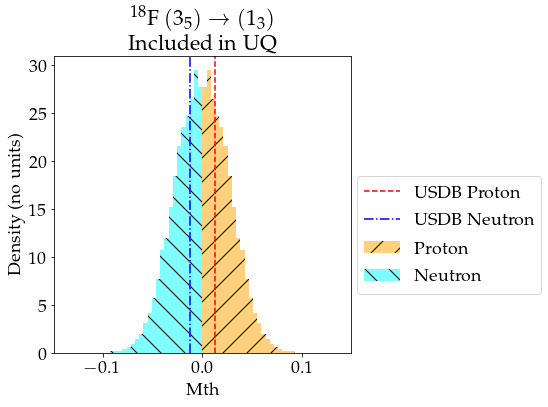

  4%|▎         | 7/188 [00:58<24:33,  8.14s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
19           23  18       F  9  9        6310.5               0.8  3   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
19  0.95 KEV 0.14         2587.0  ...        25.220681            14.011489   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
19      18F  1      2   5   3     True  0.0124 -0.0124  

[1 rows x 36 columns]
INDEX =  24
GlobalIndex                       24
A                                 18
Element                            F
Z                                  9
N                                  9
Energy (keV)                  6310.5
Energy Unc (keV)                 0.8
Ji                                 3
Thalf                  0.95 KEV 0.14
E_gamma (keV)                 4610.0
E_gamma Unc (keV)                0.0
I_gamma                          3.0
I_gamma Unc                      0.8
Mult                              E2
Mult Ratio                   

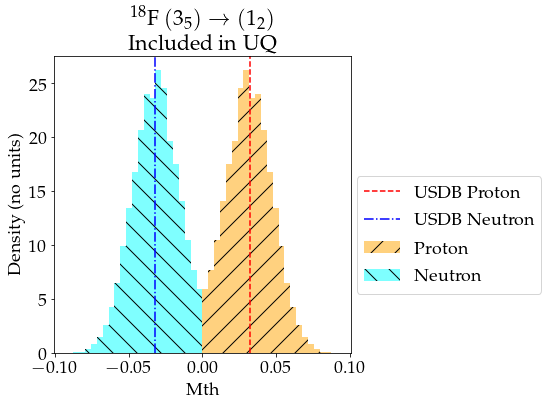

  4%|▍         | 8/188 [01:05<23:56,  7.98s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
20           24  18       F  9  9        6310.5               0.8  3   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
20  0.95 KEV 0.14         4610.0  ...         2.802298             1.120919   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
20      18F  1      2   5   2     True  0.0323 -0.0323  

[1 rows x 36 columns]
INDEX =  25
GlobalIndex                      25
A                                18
Element                           F
Z                                 9
N                                 9
Energy (keV)                 6484.9
Energy Unc (keV)                1.5
Ji                                3
Thalf                  0.40 KEV 0.1
E_gamma (keV)                4784.0
E_gamma Unc (keV)               0.0
I_gamma                         4.0
I_gamma Unc                     2.0
Mult                             E2
Mult Ratio                      NaN
Mult Ra

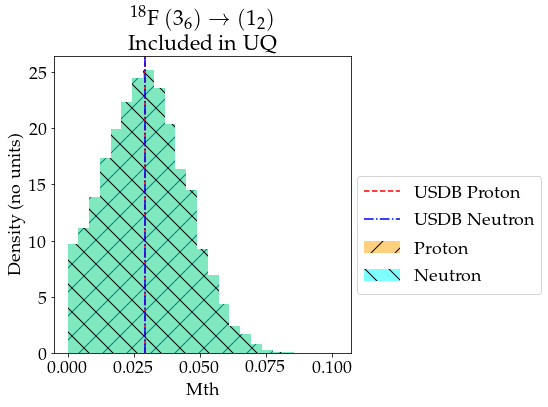

  5%|▍         | 9/188 [01:13<23:44,  7.96s/it]

    GlobalIndex   A Element  Z  N  Energy (keV)  Energy Unc (keV) Ji  \
21           25  18       F  9  9        6484.9               1.5  3   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
21  0.40 KEV 0.1         4784.0  ...         1.457195             0.980804   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
21      18F  1      2   6   2     True  0.0292  0.0292  

[1 rows x 36 columns]
INDEX =  27
GlobalIndex                   27
A                             19
Element                        F
Z                              9
N                             10
Energy (keV)             197.143
Energy Unc (keV)           0.004
Ji                           5/2
Thalf                  89.3 NS 1
E_gamma (keV)              197.1
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef            

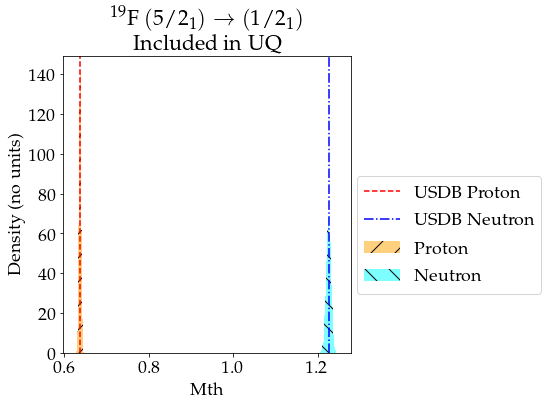

  5%|▌         | 10/188 [01:21<23:31,  7.93s/it]

    GlobalIndex   A Element  Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
22           27  19       F  9  10       197.143             0.004  5/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
22  89.3 NS 1          197.1  ...        20.931831             0.240942   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
22      19F  1/2      1   1   1     True  0.6377  1.2263  

[1 rows x 36 columns]
INDEX =  28
GlobalIndex                   28
A                             19
Element                        F
Z                              9
N                             10
Energy (keV)            2779.849
Energy Unc (keV)           0.034
Ji                           9/2
Thalf                  194 FS 21
E_gamma (keV)             2582.7
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef        

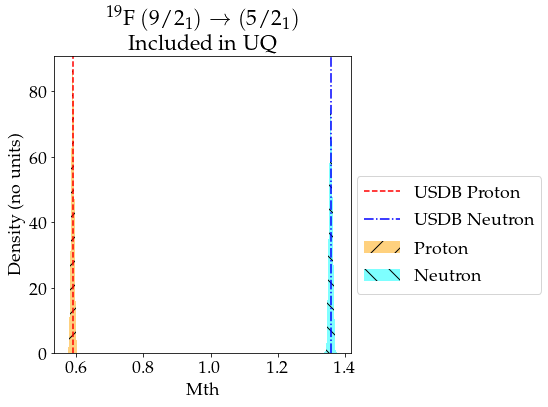

  6%|▌         | 11/188 [01:29<23:23,  7.93s/it]

    GlobalIndex   A Element  Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
23           28  19       F  9  10      2779.849             0.034  9/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
23  194 FS 21         2582.7  ...        24.696549             2.710597   

    Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
23      19F  5/2      5   1   1     True  0.591  1.3573  

[1 rows x 36 columns]
INDEX =  29
GlobalIndex                    29
A                              19
Element                         F
Z                               9
N                              10
Energy (keV)               4648.0
Energy Unc (keV)              1.0
Ji                           13/2
Thalf                  2.6 PS 0.3
E_gamma (keV)              1868.0
E_gamma Unc (keV)             0.0
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Con

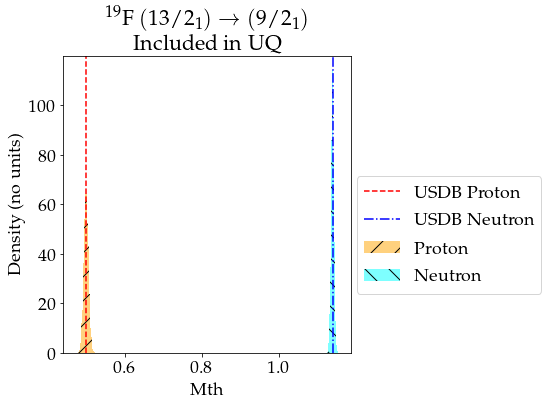

  6%|▋         | 12/188 [01:37<23:09,  7.90s/it]

    GlobalIndex   A Element  Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
24           29  19       F  9  10        4648.0               1.0  13/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
24  2.6 PS 0.3         1868.0  ...         9.637678              1.20471   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
24      19F  9/2      9   1   1     True  0.5004  1.1395  

[1 rows x 36 columns]
INDEX =  30
GlobalIndex                  30
A                            19
Element                       F
Z                             9
N                            10
Energy (keV)             6070.0
Energy Unc (keV)            1.0
Ji                          7/2
Thalf                   1.2 KEV
E_gamma (keV)            4516.0
E_gamma Unc (keV)           0.0
I_gamma                     1.0
I_gamma Unc                 1.0
Mult                         E2
Mult Ratio                0.035
Mult Ratio Unc            0.023
Conv Coef                   N

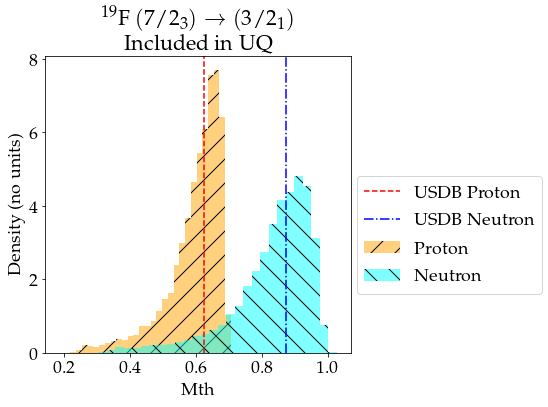

  7%|▋         | 13/188 [01:45<23:01,  7.89s/it]

    GlobalIndex   A Element  Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
25           30  19       F  9  10        6070.0               1.0  7/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
25  1.2 KEV         4516.0  ...         4.517661             3.915307   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
25      19F  3/2      3   3   1     True  0.6235  0.8712  

[1 rows x 36 columns]
INDEX =  31
GlobalIndex                  31
A                            19
Element                       F
Z                             9
N                            10
Energy (keV)             6330.0
Energy Unc (keV)            2.0
Ji                          7/2
Thalf                   2.4 KEV
E_gamma (keV)            4776.0
E_gamma Unc (keV)           0.0
I_gamma                     8.5
I_gamma Unc                 1.5
Mult                         E2
Mult Ratio                  0.0
Mult Ratio Unc             0.14
Conv Coef                   NaN
Conv 

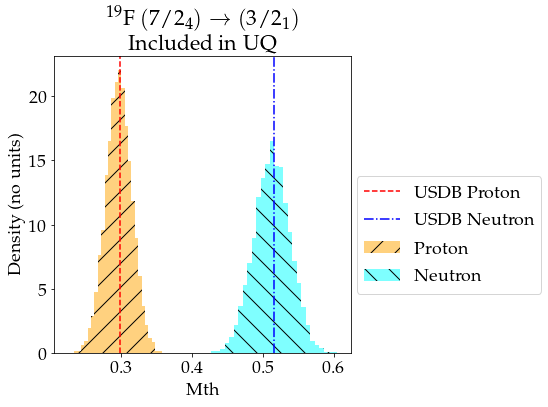

  7%|▋         | 14/188 [01:53<23:06,  7.97s/it]

    GlobalIndex   A Element  Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
26           31  19       F  9  10        6330.0               2.0  7/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
26  2.4 KEV         4776.0  ...         7.830613             2.409419   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
26      19F  3/2      3   4   1     True -0.2984 -0.5159  

[1 rows x 36 columns]
INDEX =  32
GlobalIndex                  32
A                            20
Element                       F
Z                             9
N                            11
Energy (keV)             822.73
Energy Unc (keV)           0.03
Ji                            4
Thalf                   55 PS 4
E_gamma (keV)            822.69
E_gamma Unc (keV)          0.04
I_gamma                    33.2
I_gamma Unc                 2.4
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv 

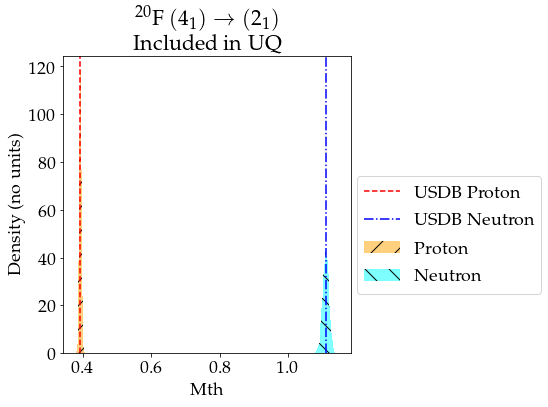

  8%|▊         | 15/188 [02:00<22:39,  7.86s/it]

    GlobalIndex   A Element  Z   N  Energy (keV)  Energy Unc (keV) Ji  \
27           32  20       F  9  11        822.73              0.03  4   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
27  55 PS 4         822.69  ...         8.900889             0.935238   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
27      20F  2      4   1   1     True  0.3933  1.1097  

[1 rows x 36 columns]
INDEX =  33
GlobalIndex                    33
A                              21
Element                         F
Z                               9
N                              12
Energy (keV)               279.93
Energy Unc (keV)             0.06
Ji                            1/2
Thalf                  6.1 NS 0.6
E_gamma (keV)              279.92
E_gamma Unc (keV)            0.06
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                         (E2)
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef    

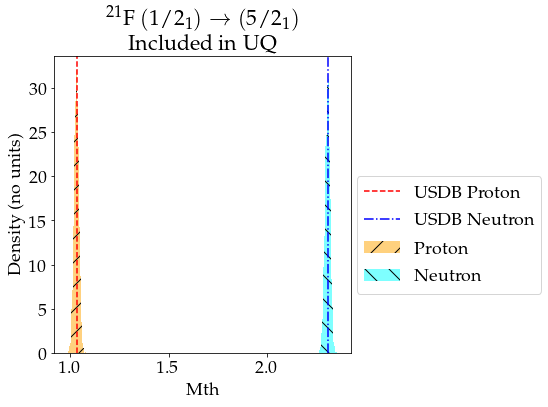

  9%|▊         | 16/188 [02:08<22:34,  7.87s/it]

    GlobalIndex   A Element  Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
28           33  21       F  9  12        279.93              0.06  1/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
28  6.1 NS 0.6         279.92  ...        54.035146             5.506767   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
28      21F  5/2      5   1   1     True -1.0309 -2.3117  

[1 rows x 36 columns]
INDEX =  38
GlobalIndex                     38
A                               19
Element                         Ne
Z                               10
N                                9
Energy (keV)                238.27
Energy Unc (keV)              0.11
Ji                             5/2
Thalf                  18.0 NS 0.5
E_gamma (keV)                238.3
E_gamma Unc (keV)              0.0
I_gamma                      100.0
I_gamma Unc                    0.0
Mult                            E2
Mult Ratio                     NaN
Mult Ratio Unc    

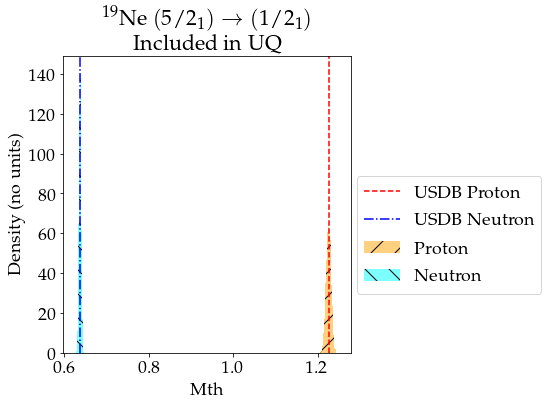

  9%|▉         | 17/188 [02:16<22:38,  7.95s/it]

    GlobalIndex   A Element   Z  N  Energy (keV)  Energy Unc (keV)   Ji  \
33           38  19      Ne  10  9        238.27              0.11  5/2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
33  18.0 NS 0.5          238.3  ...        39.755421             1.505887   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
33     19Ne  1/2      1   1   1     True -1.2263 -0.6377  

[1 rows x 36 columns]
INDEX =  39
GlobalIndex                   39
A                             19
Element                       Ne
Z                             10
N                              9
Energy (keV)              2794.7
Energy Unc (keV)             0.6
Ji                           9/2
Thalf                   97 FS 24
E_gamma (keV)             2556.4
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef    

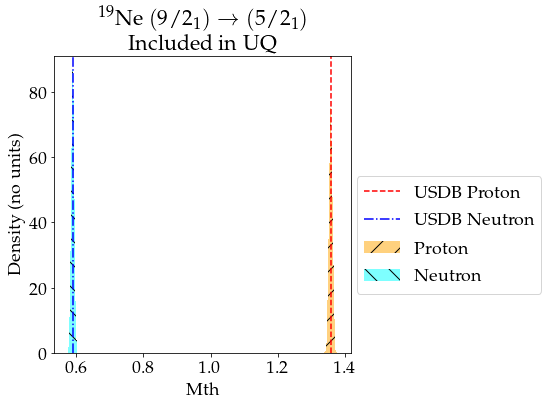

 10%|▉         | 18/188 [02:24<22:24,  7.91s/it]

    GlobalIndex   A Element   Z  N  Energy (keV)  Energy Unc (keV)   Ji  \
34           39  19      Ne  10  9        2794.7               0.6  9/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
34  97 FS 24         2556.4  ...        51.200163            12.047097   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
34     19Ne  5/2      5   1   1     True -1.3573 -0.591  

[1 rows x 36 columns]
INDEX =  40
GlobalIndex                      40
A                                20
Element                          Ne
Z                                10
N                                10
Energy (keV)               1633.674
Energy Unc (keV)              0.015
Ji                                2
Thalf                  0.73 PS 0.04
E_gamma (keV)              1633.602
E_gamma Unc (keV)             0.015
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                           [E2]
Mult Ratio                      NaN
Mult Rati

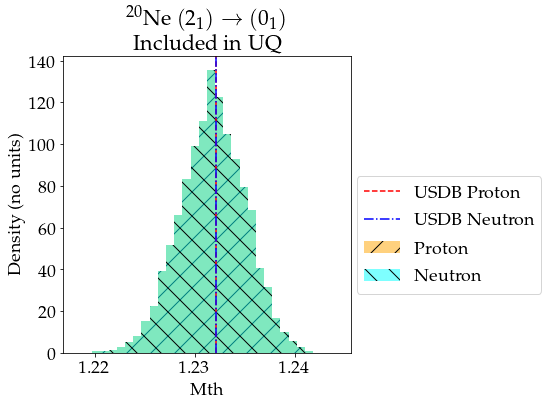

 10%|█         | 19/188 [02:32<22:18,  7.92s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
35           40  20      Ne  10  10      1633.674             0.015  2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
35  0.73 PS 0.04       1633.602  ...         65.46668              3.22496   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
35     20Ne  0      0   1   1     True -1.2321 -1.2321  

[1 rows x 36 columns]
INDEX =  41
GlobalIndex                   41
A                             20
Element                       Ne
Z                             10
N                             10
Energy (keV)              4247.7
Energy Unc (keV)             1.1
Ji                             4
Thalf                    64 FS 6
E_gamma (keV)             2613.8
E_gamma Unc (keV)            1.1
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef        

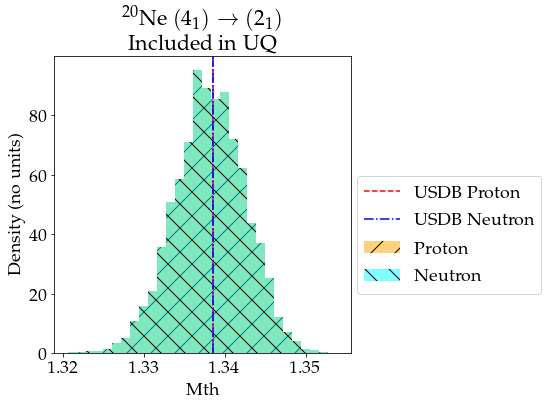

 11%|█         | 20/188 [02:40<22:08,  7.91s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
36           41  20      Ne  10  10        4247.7               1.1  4   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
36  64 FS 6         2613.8  ...        70.949112             6.449919   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
36     20Ne  2      4   1   1     True -1.3385 -1.3385  

[1 rows x 36 columns]
INDEX =  42
GlobalIndex                       42
A                                 20
Element                           Ne
Z                                 10
N                                 10
Energy (keV)                  8777.6
Energy Unc (keV)                 2.2
Ji                                 6
Thalf                  0.11 KEV 0.02
E_gamma (keV)                 4529.3
E_gamma Unc (keV)                2.5
I_gamma                        100.0
I_gamma Unc                      0.0
Mult                            [E2]
Mult Ratio                       NaN


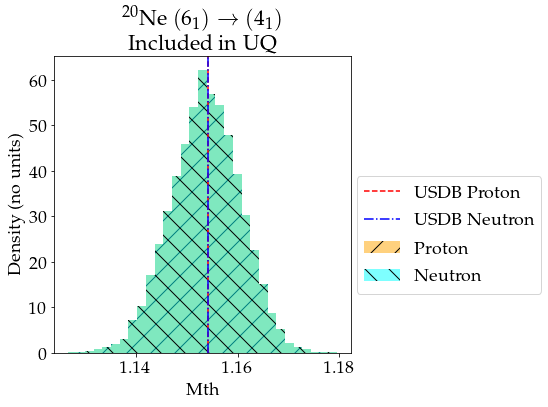

 11%|█         | 21/188 [02:48<22:01,  7.91s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
37           42  20      Ne  10  10        8777.6               2.2  6   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
37  0.11 KEV 0.02         4529.3  ...        64.499192             9.674879   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
37     20Ne  4      8   1   1     True -1.1542 -1.1542  

[1 rows x 36 columns]
INDEX =  43
GlobalIndex                        43
A                                  20
Element                            Ne
Z                                  10
N                                  10
Energy (keV)                  11951.0
Energy Unc (keV)                  4.0
Ji                                  8
Thalf                  0.035 KEV 0.01
E_gamma (keV)                  3173.0
E_gamma Unc (keV)                 5.0
I_gamma                         100.0
I_gamma Unc                       0.0
Mult                             [E2]
Mult Ratio 

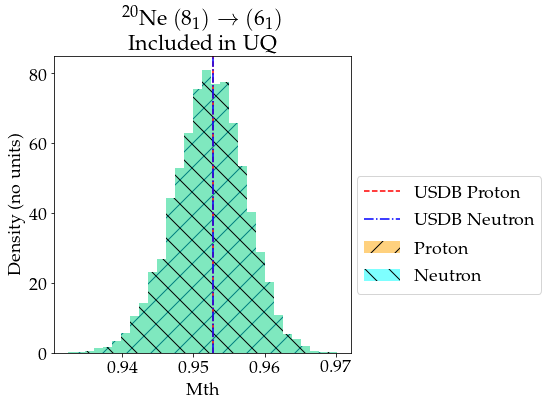

 12%|█▏        | 22/188 [02:56<21:49,  7.89s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
38           43  20      Ne  10  10       11951.0               4.0  8   

             Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
38  0.035 KEV 0.01         3173.0  ...        29.024637             4.192448   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
38     20Ne  6     12   1   1     True  0.9528  0.9528  

[1 rows x 36 columns]
INDEX =  44
GlobalIndex                      44
A                                22
Element                          Ne
Z                                10
N                                12
Energy (keV)               1274.537
Energy Unc (keV)              0.007
Ji                                2
Thalf                  3.60 PS 0.05
E_gamma (keV)              1274.537
E_gamma Unc (keV)             0.007
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                             E2
Mult Ratio                      NaN
M

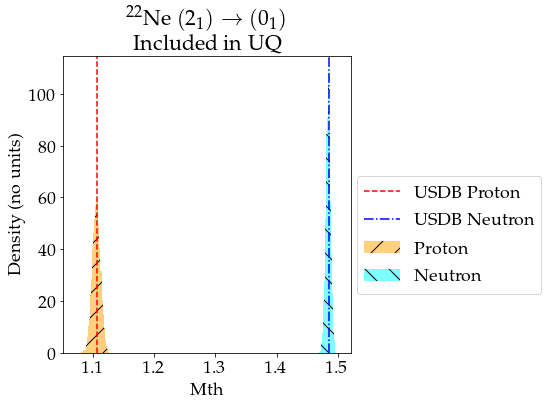

 12%|█▏        | 23/188 [03:04<21:54,  7.97s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
39           44  22      Ne  10  12      1274.537             0.007  2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
39  3.60 PS 0.05       1274.537  ...         46.72671             0.659154   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
39     22Ne  0      0   1   1     True -1.1052 -1.4851  

[1 rows x 36 columns]
INDEX =  45
GlobalIndex                   45
A                             22
Element                       Ne
Z                             10
N                             12
Energy (keV)              3357.2
Energy Unc (keV)             0.5
Ji                             4
Thalf                   225 FS 4
E_gamma (keV)             2082.6
E_gamma Unc (keV)            0.5
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef        

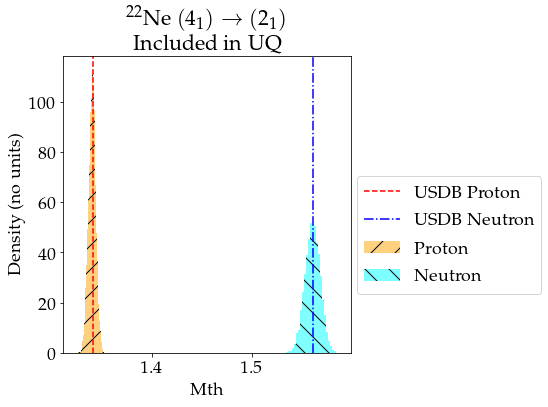

 13%|█▎        | 24/188 [03:12<21:44,  7.95s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
40           45  22      Ne  10  12        3357.2               0.5  4   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
40  225 FS 4         2082.6  ...        64.084438             1.464787   

    Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
40     22Ne  2      4   1   1     True -1.341 -1.5607  

[1 rows x 36 columns]
INDEX =  46
GlobalIndex                    46
A                              22
Element                        Ne
Z                              10
N                              12
Energy (keV)               4456.2
Energy Unc (keV)              0.9
Ji                              2
Thalf                  3.7 FS 2.5
E_gamma (keV)              4455.7
E_gamma Unc (keV)             0.0
I_gamma                       3.1
I_gamma Unc                   2.1
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef  

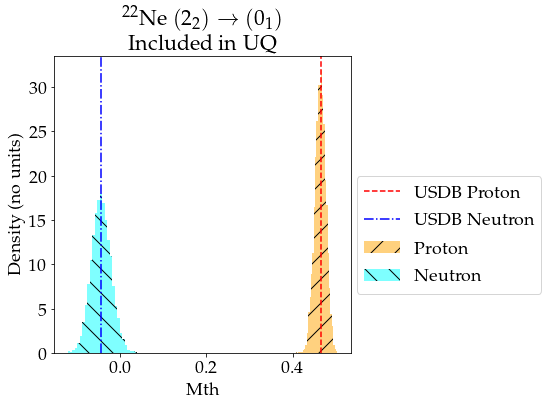

 13%|█▎        | 25/188 [03:20<21:24,  7.88s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
41           46  22      Ne  10  12        4456.2               0.9  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
41  3.7 FS 2.5         4455.7  ...         2.563378             1.830984   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
41     22Ne  0      0   2   1     True -0.4654  0.0438  

[1 rows x 36 columns]
INDEX =  48
GlobalIndex                  48
A                            22
Element                      Ne
Z                            10
N                            12
Energy (keV)             6311.0
Energy Unc (keV)            1.0
Ji                            6
Thalf                   49 FS 4
E_gamma (keV)            2953.6
E_gamma Unc (keV)           0.0
I_gamma                   100.0
I_gamma Unc                 0.0
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv 

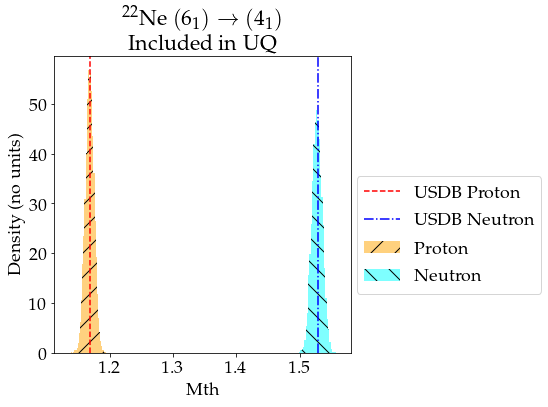

 14%|█▍        | 26/188 [03:28<21:23,  7.92s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
43           48  22      Ne  10  12        6311.0               1.0  6   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
43  49 FS 4         2953.6  ...         51.26755             4.394361   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
43     22Ne  4      8   1   1     True  1.1686  1.5283  

[1 rows x 36 columns]
INDEX =  49
GlobalIndex                   49
A                             23
Element                       Ne
Z                             10
N                             13
Energy (keV)            1016.926
Energy Unc (keV)            0.02
Ji                           1/2
Thalf                  178 PS 10
E_gamma (keV)             1016.9
E_gamma Unc (keV)           0.02
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                  

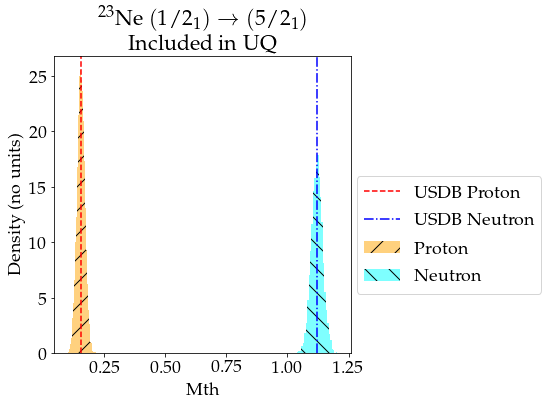

 14%|█▍        | 27/188 [03:36<21:23,  7.97s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
44           49  23      Ne  10  13      1016.926              0.02  1/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
44  178 PS 10         1016.9  ...         2.914177             0.194278   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
44     23Ne  5/2      5   1   1     True  0.1541  1.1222  

[1 rows x 36 columns]
INDEX =  50
GlobalIndex                    50
A                              24
Element                        Ne
Z                              10
N                              14
Energy (keV)               1981.6
Energy Unc (keV)              0.4
Ji                              2
Thalf                  660 FS 150
E_gamma (keV)              1981.6
E_gamma Unc (keV)             0.4
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN

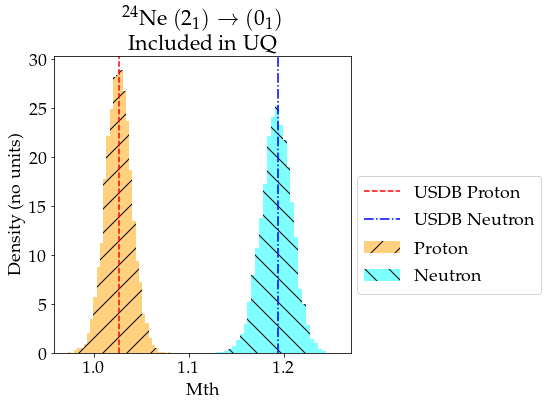

 15%|█▍        | 28/188 [03:44<21:11,  7.95s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
45           50  24      Ne  10  14        1981.6               0.4  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
45  660 FS 150         1981.6  ...        27.964573             6.579899   

    Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
45     24Ne  0      0   1   1     True  1.026  1.1944  

[1 rows x 36 columns]
INDEX =  51
GlobalIndex                   51
A                             28
Element                       Ne
Z                             10
N                             18
Energy (keV)              1304.0
Energy Unc (keV)             3.0
Ji                             2
Thalf                   5.7 PS 1
E_gamma (keV)             1304.0
E_gamma Unc (keV)            3.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef              

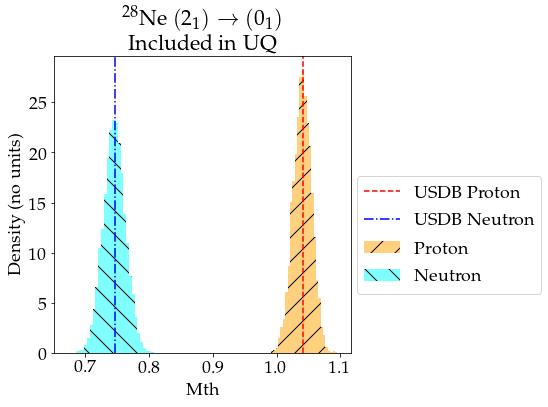

 15%|█▌        | 29/188 [03:52<21:16,  8.03s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
46           51  28      Ne  10  18        1304.0               3.0  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
46  5.7 PS 1         1304.0  ...        25.254087             4.040654   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
46     28Ne  0      0   1   1     True -1.0413 -0.7462  

[1 rows x 36 columns]
INDEX =  52
GlobalIndex                   52
A                             21
Element                       Na
Z                             11
N                             10
Energy (keV)              1716.1
Energy Unc (keV)             0.3
Ji                           7/2
Thalf                    37 FS 8
E_gamma (keV)             1715.9
E_gamma Unc (keV)            0.7
I_gamma                      7.5
I_gamma Unc                  2.2
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                

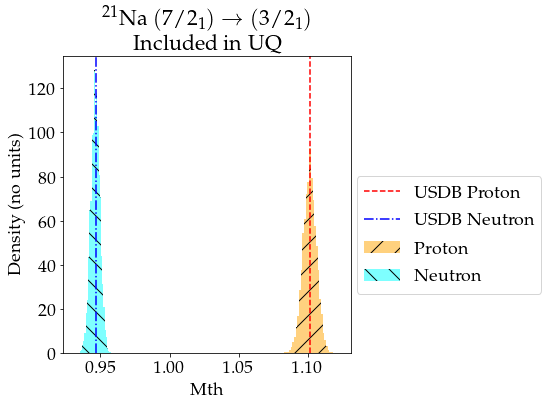

 16%|█▌        | 30/188 [04:00<21:07,  8.02s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
47           52  21      Na  11  10        1716.1               0.3  7/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
47  37 FS 8         1715.9  ...        72.276311            27.533833   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
47     21Na  3/2      3   1   1     True  1.1018  0.9466  

[1 rows x 36 columns]
INDEX =  54
GlobalIndex                      54
A                                22
Element                          Na
Z                                11
N                                11
Energy (keV)                 1528.1
Energy Unc (keV)                0.3
Ji                                5
Thalf                  3.42 PS 0.24
E_gamma (keV)                1528.1
E_gamma Unc (keV)               0.2
I_gamma                       100.0
I_gamma Unc                     1.3
Mult                             E2
Mult Ratio                      NaN
Mult Ra

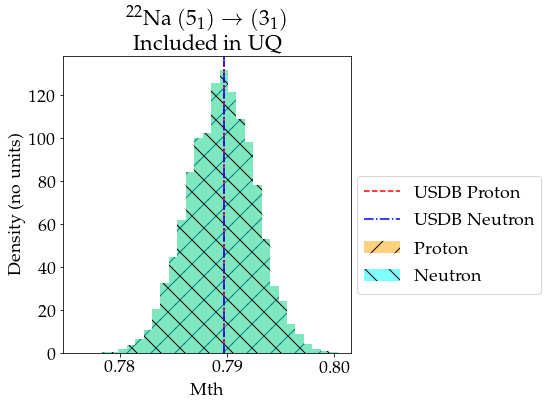

 16%|█▋        | 31/188 [04:08<21:12,  8.10s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
49           54  22      Na  11  11        1528.1               0.3  5   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
49  3.42 PS 0.24         1528.1  ...        19.042233             1.464787   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
49     22Na  3      6   1   1     True -0.7897 -0.7897  

[1 rows x 36 columns]
INDEX =  55
GlobalIndex                  55
A                            22
Element                      Na
Z                            11
N                            11
Energy (keV)             1936.9
Energy Unc (keV)            0.2
Ji                            1
Thalf                   13 FS 4
E_gamma (keV)            1936.8
E_gamma Unc (keV)           0.0
I_gamma                    0.59
I_gamma Unc                0.06
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
C

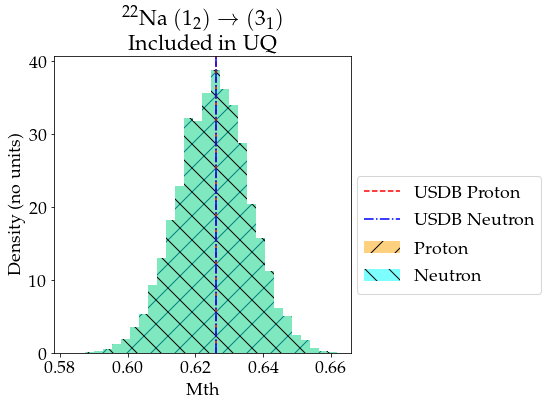

 17%|█▋        | 32/188 [04:16<20:55,  8.05s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
50           55  22      Na  11  11        1936.9               0.2  1   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
50  13 FS 4         1936.8  ...         9.521116             3.295771   

    Nucleus Jf  twoJf  ni  nf  Include  Mth_p  Mth_n  
50     22Na  3      6   2   1     True  0.626  0.626  

[1 rows x 36 columns]
INDEX =  56
GlobalIndex                   56
A                             22
Element                       Na
Z                             11
N                             11
Energy (keV)              1951.8
Energy Unc (keV)             0.3
Ji                             2
Thalf                     8 FS 2
E_gamma (keV)             1294.8
E_gamma Unc (keV)            0.0
I_gamma                     0.29
I_gamma Unc                 0.05
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                    Na

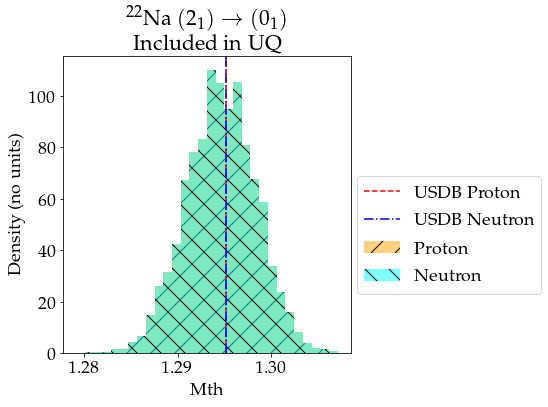

 18%|█▊        | 33/188 [04:24<20:46,  8.04s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
51           56  22      Na  11  11        1951.8               0.3  2   

     Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  Nucleus  \
51  8 FS 2         1294.8  ...        54.929518            18.309839     22Na   

   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
51  0      0   1   1     True -1.2951 -1.2951  

[1 rows x 36 columns]
INDEX =  57
GlobalIndex                      57
A                                22
Element                          Na
Z                                11
N                                11
Energy (keV)                 1983.5
Energy Unc (keV)                0.5
Ji                                3
Thalf                  1.47 PS 0.15
E_gamma (keV)                1400.4
E_gamma Unc (keV)               0.5
I_gamma                       100.0
I_gamma Unc                     0.3
Mult                             E2
Mult Ratio                      NaN
Mult Ratio Unc   

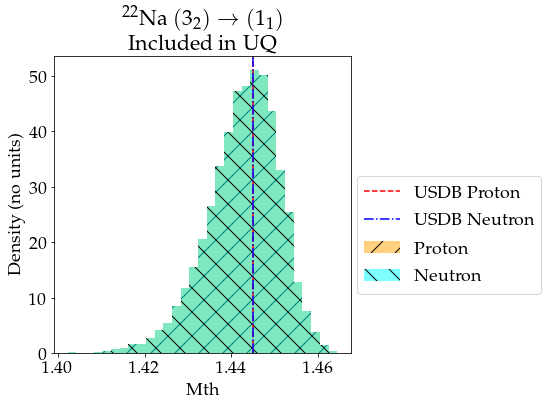

 18%|█▊        | 34/188 [04:32<20:32,  8.00s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
52           57  22      Na  11  11        1983.5               0.5  3   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
52  1.47 PS 0.15         1400.4  ...        69.211193             7.323936   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
52     22Na  1      2   2   1     True -1.4449 -1.4449  

[1 rows x 36 columns]
INDEX =  58
GlobalIndex                   58
A                             22
Element                       Na
Z                             11
N                             11
Energy (keV)              3706.7
Energy Unc (keV)             0.4
Ji                             6
Thalf                   59 FS 12
E_gamma (keV)             2815.8
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  9.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef        

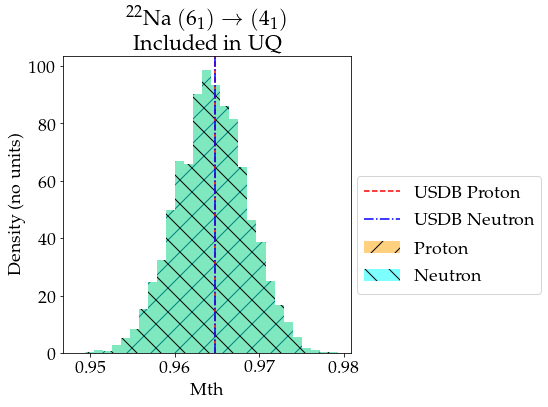

 19%|█▊        | 35/188 [04:40<20:26,  8.02s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
53           58  22      Na  11  11        3706.7               0.4  6   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
53  59 FS 12         2815.8  ...        40.281646            10.985904   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
53     22Na  4      8   1   1     True  0.9648  0.9648  

[1 rows x 36 columns]
INDEX =  59
GlobalIndex                   59
A                             22
Element                       Na
Z                             11
N                             11
Energy (keV)              4710.0
Energy Unc (keV)             0.4
Ji                             5
Thalf                   37 FS 14
E_gamma (keV)             2726.0
E_gamma Unc (keV)            0.4
I_gamma                    100.0
I_gamma Unc                  4.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               0

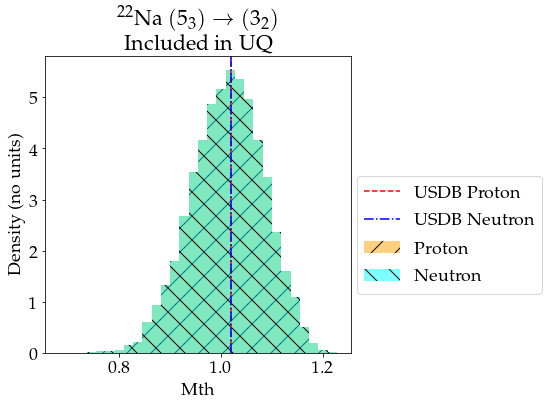

 19%|█▉        | 36/188 [04:48<20:28,  8.08s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
54           59  22      Na  11  11        4710.0               0.4  5   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
54  37 FS 14         2726.0  ...         51.26755            21.971807   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
54     22Na  3      6   3   2     True -1.0196 -1.0196  

[1 rows x 36 columns]
INDEX =  60
GlobalIndex                   60
A                             22
Element                       Na
Z                             11
N                             11
Energy (keV)              4710.0
Energy Unc (keV)             0.4
Ji                             5
Thalf                   37 FS 14
E_gamma (keV)             1741.3
E_gamma Unc (keV)            0.0
I_gamma                     10.0
I_gamma Unc                  2.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               0

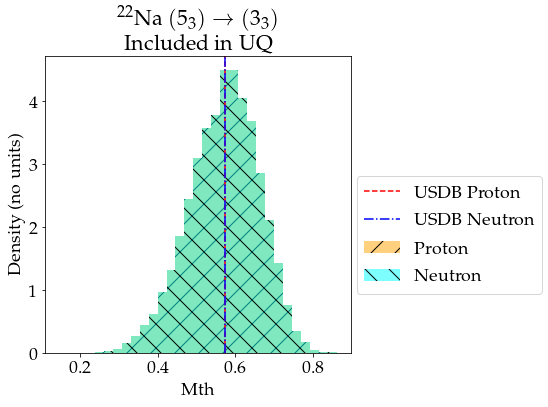

 20%|█▉        | 37/188 [04:56<20:08,  8.00s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
55           60  22      Na  11  11        4710.0               0.4  5   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
55  37 FS 14         1741.3  ...         51.26755            21.971807   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
55     22Na  3      6   3   3     True  0.5726  0.5726  

[1 rows x 36 columns]
INDEX =  61
GlobalIndex                   61
A                             22
Element                       Na
Z                             11
N                             11
Energy (keV)              5100.4
Energy Unc (keV)             1.3
Ji                             4
Thalf                   38 FS 12
E_gamma (keV)             2039.1
E_gamma Unc (keV)            0.0
I_gamma                     49.0
I_gamma Unc                  6.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               0

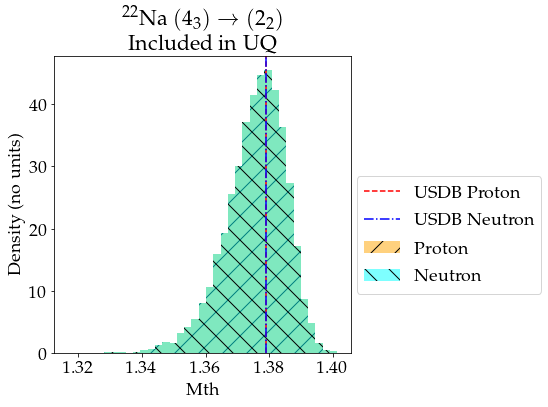

 20%|██        | 38/188 [05:04<19:58,  7.99s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
56           61  22      Na  11  11        5100.4               1.3  4   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
56  38 FS 12         2039.1  ...        76.901325            29.295743   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
56     22Na  2      4   3   2     True  1.3789  1.3789  

[1 rows x 36 columns]
INDEX =  62
GlobalIndex                   62
A                             23
Element                       Na
Z                             11
N                             12
Energy (keV)              2076.2
Energy Unc (keV)             0.4
Ji                           7/2
Thalf                    27 FS 3
E_gamma (keV)             2076.7
E_gamma Unc (keV)            0.8
I_gamma                     9.77
I_gamma Unc                 0.11
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               0

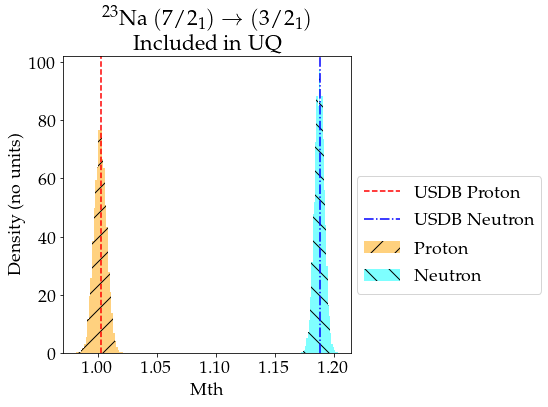

 21%|██        | 39/188 [05:12<20:00,  8.05s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
57           62  23      Na  11  12        2076.2               0.4  7/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
57  27 FS 3         2076.7  ...        47.403954             5.828355   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
57     23Na  3/2      3   1   1     True -1.0026 -1.1886  

[1 rows x 36 columns]
INDEX =  63
GlobalIndex                      63
A                                23
Element                          Na
Z                                11
N                                12
Energy (keV)                 2390.9
Energy Unc (keV)                0.3
Ji                              1/2
Thalf                  0.60 PS 0.14
E_gamma (keV)                1950.6
E_gamma Unc (keV)               0.4
I_gamma                        52.2
I_gamma Unc                     0.6
Mult                             E2
Mult Ratio                      NaN
Mult Ra

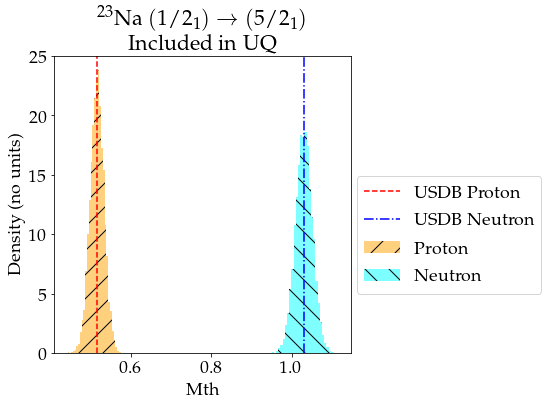

 21%|██▏       | 40/188 [05:20<19:33,  7.93s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
58           63  23      Na  11  12        2390.9               0.3  1/2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
58  0.60 PS 0.14         1950.6  ...        11.268153             2.719899   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
58     23Na  5/2      5   1   1     True  0.5171  1.0317  

[1 rows x 36 columns]
INDEX =  64
GlobalIndex                   64
A                             23
Element                       Na
Z                             11
N                             12
Energy (keV)              2703.8
Energy Unc (keV)             0.5
Ji                           9/2
Thalf                    88 FS 7
E_gamma (keV)             2263.3
E_gamma Unc (keV)            0.8
I_gamma                    100.0
I_gamma Unc                  0.5
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef

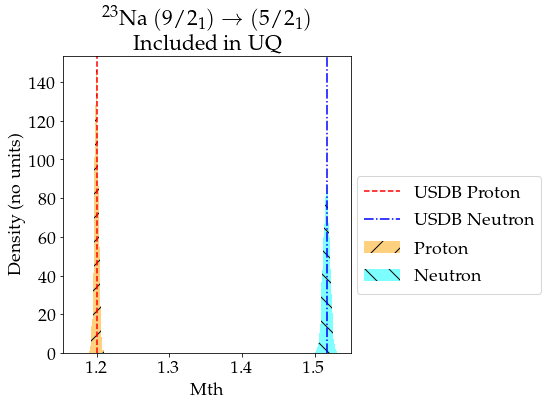

 22%|██▏       | 41/188 [05:28<19:24,  7.92s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
59           64  23      Na  11  12        2703.8               0.5  9/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
59  88 FS 7         2263.3  ...        67.608918             5.439798   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
59     23Na  5/2      5   1   1     True  1.2001  1.5171  

[1 rows x 36 columns]
INDEX =  65
GlobalIndex                    65
A                              23
Element                        Na
Z                              11
N                              12
Energy (keV)               3914.6
Energy Unc (keV)              0.4
Ji                            5/2
Thalf                  6.9 FS 1.4
E_gamma (keV)              1523.0
E_gamma Unc (keV)             1.0
I_gamma                      1.38
I_gamma Unc                  0.13
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Con

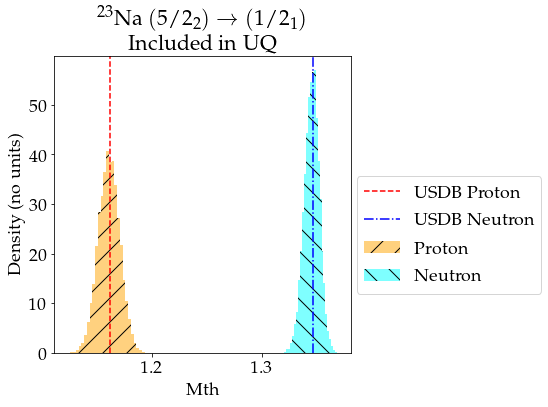

 22%|██▏       | 42/188 [05:36<19:20,  7.95s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
60           65  23      Na  11  12        3914.6               0.4  5/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
60  6.9 FS 1.4         1523.0  ...        108.79596             27.19899   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
60     23Na  1/2      1   2   1     True  1.1608  1.3465  

[1 rows x 36 columns]
INDEX =  66
GlobalIndex                     66
A                               23
Element                         Na
Z                               11
N                               12
Energy (keV)                5534.2
Energy Unc (keV)               0.6
Ji                            11/2
Thalf                  10.4 FS 0.6
E_gamma (keV)               3458.0
E_gamma Unc (keV)              1.0
I_gamma                       27.5
I_gamma Unc                    0.7
Mult                            E2
Mult Ratio                     NaN
Mult Ratio Unc  

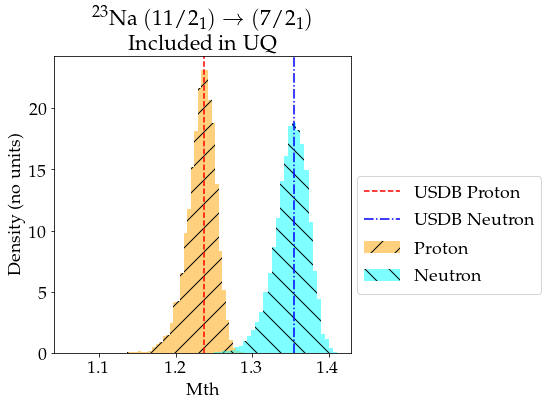

 23%|██▎       | 43/188 [05:44<19:11,  7.94s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
61           66  23      Na  11  12        5534.2               0.6  11/2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
61  10.4 FS 0.6         3458.0  ...         23.31342             15.54228   

    Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
61     23Na  7/2      7   1   1     True -1.237 -1.3542  

[1 rows x 36 columns]
INDEX =  67
GlobalIndex                  67
A                            23
Element                      Na
Z                            11
N                            12
Energy (keV)             6115.1
Energy Unc (keV)            0.6
Ji                         11/2
Thalf                   35 FS 9
E_gamma (keV)            4038.0
E_gamma Unc (keV)           1.0
I_gamma                    30.0
I_gamma Unc                 3.0
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef               0.0

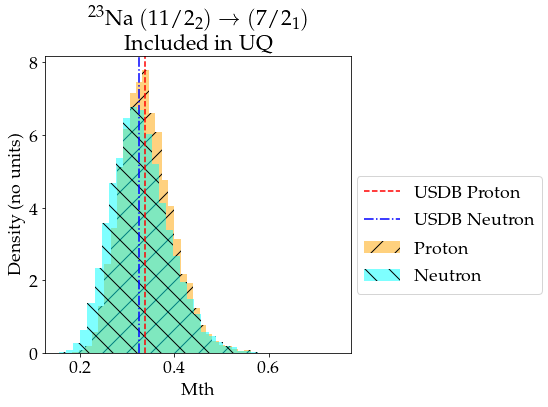

 23%|██▎       | 44/188 [05:52<19:23,  8.08s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
62           67  23      Na  11  12        6115.1               0.6  11/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
62  35 FS 9         4038.0  ...         3.458157             0.971392   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
62     23Na  7/2      7   2   1     True -0.3371 -0.3237  

[1 rows x 36 columns]
INDEX =  68
GlobalIndex                  68
A                            23
Element                      Na
Z                            11
N                            12
Energy (keV)             6235.4
Energy Unc (keV)            0.6
Ji                         13/2
Thalf                   16 FS 8
E_gamma (keV)            3531.0
E_gamma Unc (keV)           1.0
I_gamma                   100.0
I_gamma Unc                 1.2
Mult                       (E2)
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                 0.001
C

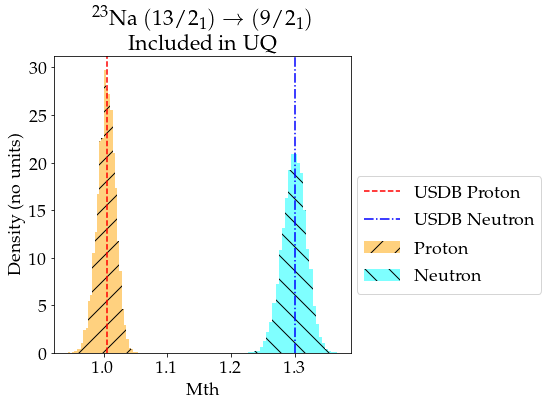

 24%|██▍       | 45/188 [06:00<19:11,  8.05s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
63           68  23      Na  11  12        6235.4               0.6  13/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
63  16 FS 8         3531.0  ...         58.28355             31.08456   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
63     23Na  9/2      9   1   1     True -1.0054 -1.3005  

[1 rows x 36 columns]
INDEX =  69
GlobalIndex                    69
A                              23
Element                        Na
Z                              11
N                              12
Energy (keV)               6735.5
Energy Unc (keV)              0.2
Ji                            3/2
Thalf                   415 AS 50
E_gamma (keV)              4658.8
E_gamma Unc (keV)             0.0
I_gamma                      71.0
I_gamma Unc                  13.0
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                NaN
C

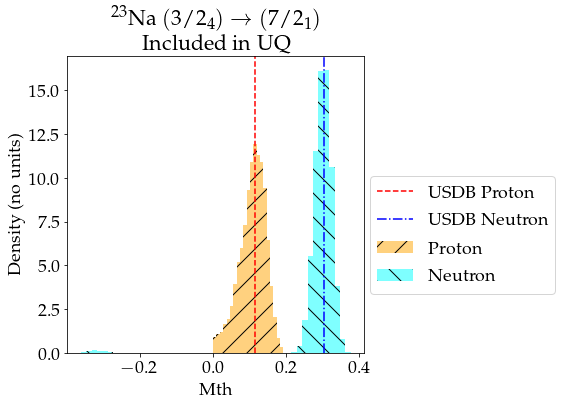

 24%|██▍       | 46/188 [06:08<18:58,  8.02s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
64           69  23      Na  11  12        6735.5               0.2  3/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
64  415 AS 50         4658.8  ...       167.079509             42.74127   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
64     23Na  7/2      7   4   1     True -0.1137 -0.3049  

[1 rows x 36 columns]
INDEX =  70
GlobalIndex                  70
A                            23
Element                      Na
Z                            11
N                            12
Energy (keV)             7268.1
Energy Unc (keV)            0.6
Ji                         13/2
Thalf                   18 FS 6
E_gamma (keV)            4564.0
E_gamma Unc (keV)           1.0
I_gamma                   100.0
I_gamma Unc                 3.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef               0.00136

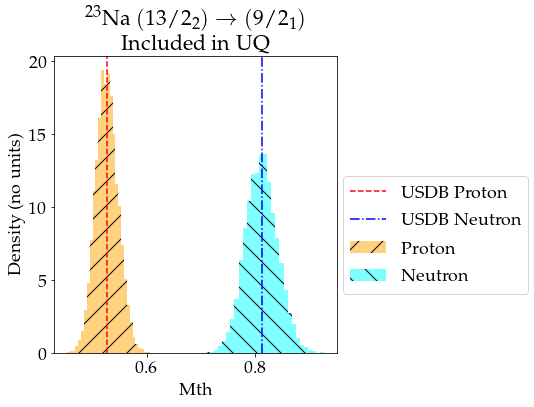

 25%|██▌       | 47/188 [06:16<18:43,  7.97s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
65           70  23      Na  11  12        7268.1               0.6  13/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
65  18 FS 6         4564.0  ...         6.994026             2.331342   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
65     23Na  9/2      9   2   1     True  0.5269  0.8118  

[1 rows x 36 columns]
INDEX =  73
GlobalIndex                      73
A                                25
Element                          Na
Z                                11
N                                14
Energy (keV)                1069.32
Energy Unc (keV)               0.19
Ji                              1/2
Thalf                  1.32 PS 0.14
E_gamma (keV)                1069.3
E_gamma Unc (keV)               0.0
I_gamma                        12.4
I_gamma Unc                     1.1
Mult                           [E2]
Mult Ratio                      NaN
Mult 

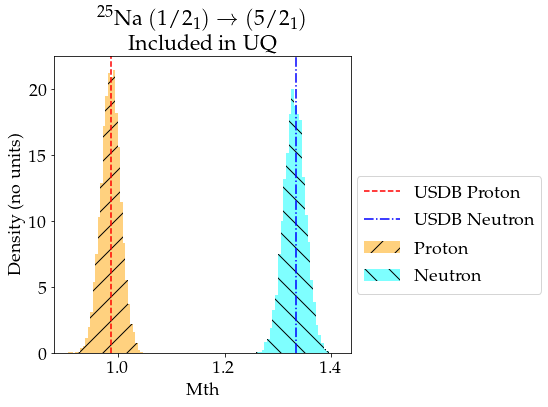

 26%|██▌       | 48/188 [06:24<19:00,  8.15s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
66           73  25      Na  11  14       1069.32              0.19  1/2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
66  1.32 PS 0.14         1069.3  ...        30.831594             4.776726   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
66     25Na  5/2      5   1   1     True -0.9873 -1.3333  

[1 rows x 36 columns]
INDEX =  74
GlobalIndex                   74
A                             26
Element                       Na
Z                             11
N                             15
Energy (keV)                82.2
Energy Unc (keV)             0.6
Ji                             1
Thalf                     9 US 2
E_gamma (keV)               84.0
E_gamma Unc (keV)            3.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef

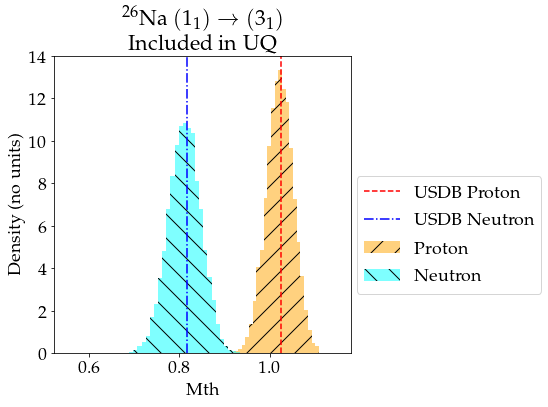

 26%|██▌       | 49/188 [06:33<19:02,  8.22s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
67           74  26      Na  11  15          82.2               0.6  1   

     Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  Nucleus  \
67  9 US 2           84.0  ...        16.472187             4.118047     26Na   

   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
67  3      6   1   1     True -1.0249 -0.8159  

[1 rows x 36 columns]
INDEX =  75
GlobalIndex                    75
A                              22
Element                        Mg
Z                              12
N                              10
Energy (keV)              1247.02
Energy Unc (keV)             0.03
Ji                              2
Thalf                  2.0 PS 0.8
E_gamma (keV)             1246.98
E_gamma Unc (keV)            0.03
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef    

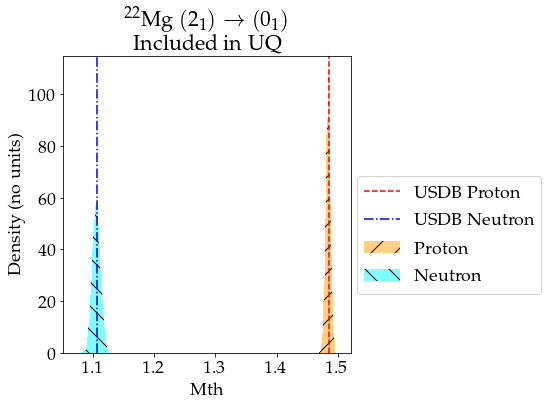

 27%|██▋       | 50/188 [06:41<19:02,  8.28s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
68           75  22      Mg  12  10       1247.02              0.03  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
68  2.0 PS 0.8        1246.98  ...        95.211164            40.281646   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
68     22Mg  0      0   1   1     True  1.4851  1.1052  

[1 rows x 36 columns]
INDEX =  76
GlobalIndex                   76
A                             22
Element                       Mg
Z                             12
N                             10
Energy (keV)             3308.22
Energy Unc (keV)            0.06
Ji                             4
Thalf                  200 FS 45
E_gamma (keV)            2061.09
E_gamma Unc (keV)           0.05
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef            

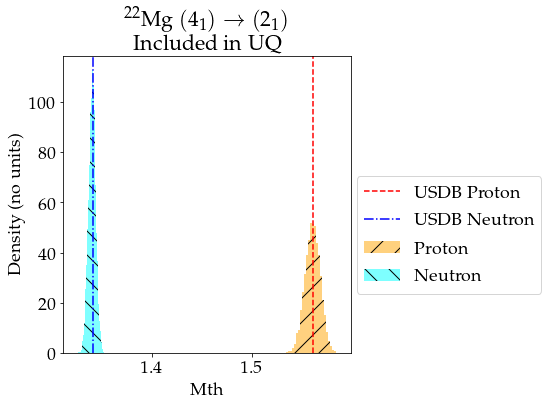

 27%|██▋       | 51/188 [06:49<18:51,  8.26s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
69           76  22      Mg  12  10       3308.22              0.06  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
69  200 FS 45        2061.09  ...        76.901325            18.309839   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
69     22Mg  2      4   1   1     True -1.5607 -1.341  

[1 rows x 36 columns]
INDEX =  77
GlobalIndex                    77
A                              23
Element                        Mg
Z                              12
N                              11
Energy (keV)               2357.0
Energy Unc (keV)              0.7
Ji                            1/2
Thalf                  575 FS 118
E_gamma (keV)              1906.0
E_gamma Unc (keV)             1.0
I_gamma                     100.0
I_gamma Unc                   4.0
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Conv Coef

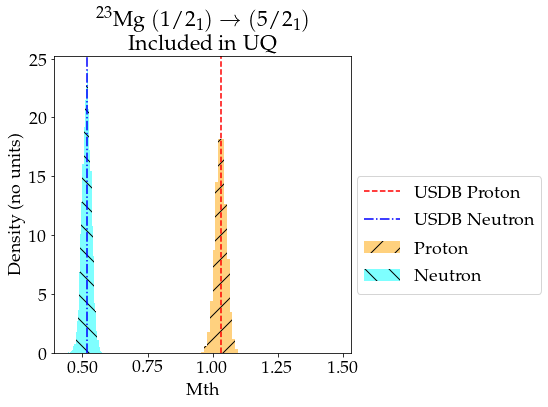

 28%|██▊       | 52/188 [06:58<18:49,  8.30s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
70           77  23      Mg  12  11        2357.0               0.7  1/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
70  575 FS 118         1906.0  ...        26.810433             6.994026   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
70     23Mg  5/2      5   1   1     True -1.0317 -0.5171  

[1 rows x 36 columns]
INDEX =  78
GlobalIndex                    78
A                              23
Element                        Mg
Z                              12
N                              11
Energy (keV)               2714.5
Energy Unc (keV)              0.5
Ji                            9/2
Thalf                     65 FS 8
E_gamma (keV)              2263.0
E_gamma Unc (keV)             1.0
I_gamma                     100.0
I_gamma Unc                   0.7
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                N

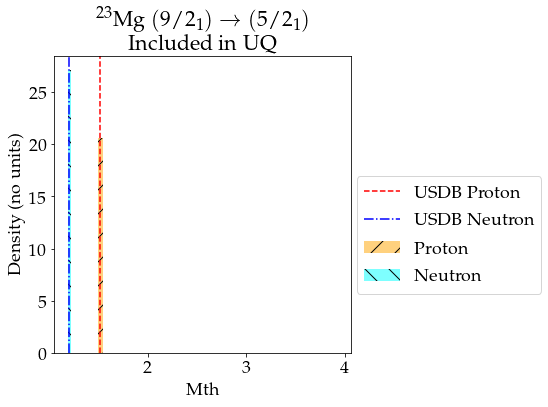

 28%|██▊       | 53/188 [07:06<18:38,  8.28s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
71           78  23      Mg  12  11        2714.5               0.5  9/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
71  65 FS 8         2263.0  ...       102.967605            14.376609   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
71     23Mg  5/2      5   1   1     True -1.5171 -1.2001  

[1 rows x 36 columns]
INDEX =  80
GlobalIndex                      80
A                                24
Element                          Mg
Z                                12
N                                12
Energy (keV)               1368.672
Energy Unc (keV)              0.005
Ji                                2
Thalf                  1.33 PS 0.06
E_gamma (keV)              1368.626
E_gamma Unc (keV)             0.005
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                             E2
Mult Ratio                      NaN
Mult Ra

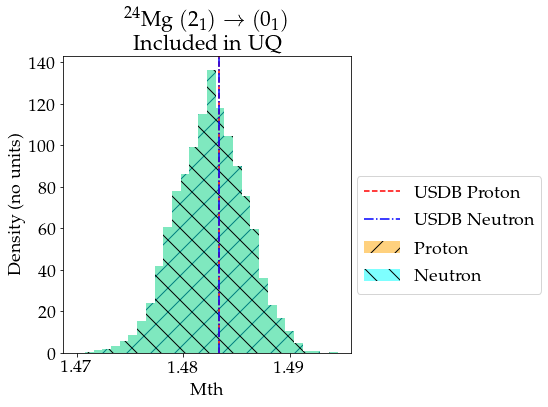

 29%|██▊       | 54/188 [07:15<18:43,  8.38s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
72           80  24      Mg  12  12      1368.672             0.005  2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
72  1.33 PS 0.06       1368.626  ...        88.417399             4.112437   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
72     24Mg  0      0   1   1     True -1.4833 -1.4833  

[1 rows x 36 columns]
INDEX =  81
GlobalIndex                   81
A                             24
Element                       Mg
Z                             12
N                             12
Energy (keV)            4122.889
Energy Unc (keV)           0.012
Ji                             4
Thalf                    22 FS 2
E_gamma (keV)           2754.007
E_gamma Unc (keV)          0.011
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef        

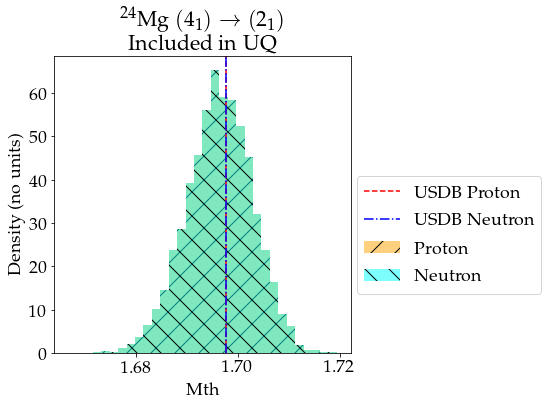

 29%|██▉       | 55/188 [07:23<18:23,  8.30s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
73           81  24      Mg  12  12      4122.889             0.012  4   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
73  22 FS 2       2754.007  ...        160.38505            16.449749   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
73     24Mg  2      4   1   1     True -1.6977 -1.6977  

[1 rows x 36 columns]
INDEX =  82
GlobalIndex                  82
A                            24
Element                      Mg
Z                            12
N                            12
Energy (keV)            4238.24
Energy Unc (keV)           0.03
Ji                            2
Thalf                   41 FS 4
E_gamma (keV)           4237.96
E_gamma Unc (keV)          0.06
I_gamma                   100.0
I_gamma Unc                 0.6
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef U

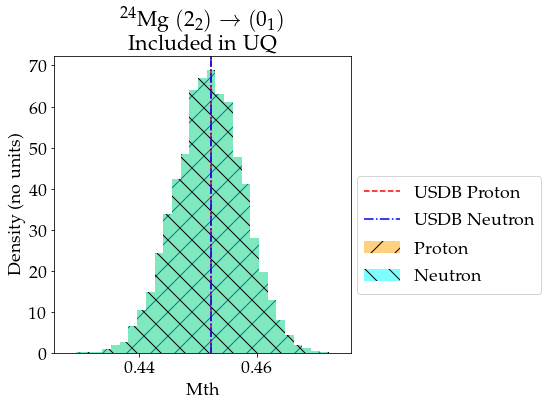

 30%|██▉       | 56/188 [07:30<17:47,  8.09s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
74           82  24      Mg  12  12       4238.24              0.03  2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
74  41 FS 4        4237.96  ...         7.978128             0.781363   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
74     24Mg  0      0   2   1     True  0.4522  0.4522  

[1 rows x 36 columns]
INDEX =  83
GlobalIndex                   83
A                             24
Element                       Mg
Z                             12
N                             12
Energy (keV)              6432.3
Energy Unc (keV)            0.11
Ji                             0
Thalf                    53 FS 8
E_gamma (keV)             2193.4
E_gamma Unc (keV)            0.6
I_gamma                     21.1
I_gamma Unc                  0.9
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                  

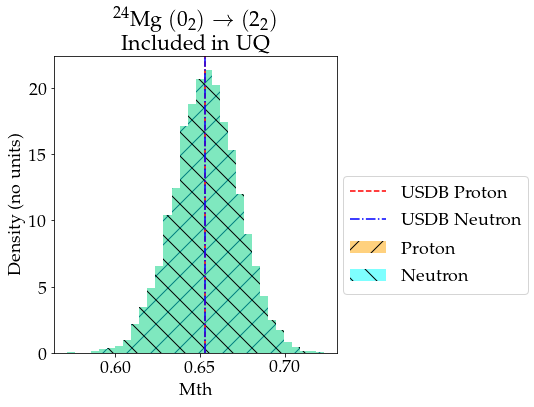

 30%|███       | 57/188 [07:38<17:40,  8.10s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
75           83  24      Mg  12  12        6432.3              0.11  0   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
75  53 FS 8         2193.4  ...        36.600691             5.757412   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
75     24Mg  2      4   2   2     True -0.6526 -0.6526  

[1 rows x 36 columns]
INDEX =  84
GlobalIndex                      84
A                                25
Element                          Mg
Z                                12
N                                13
Energy (keV)                585.045
Energy Unc (keV)              0.021
Ji                              1/2
Thalf                  3.38 NS 0.06
E_gamma (keV)               585.028
E_gamma Unc (keV)              0.03
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                             E2
Mult Ratio                      NaN
Mult Ratio Unc 

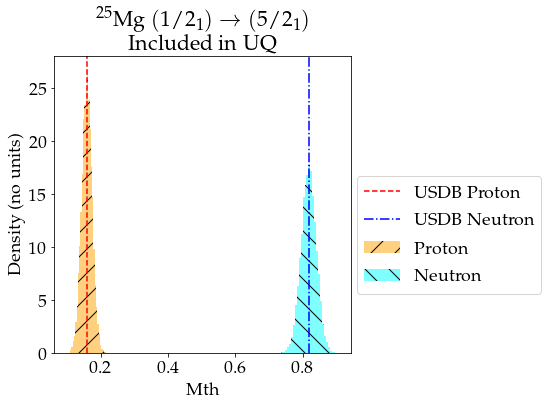

 31%|███       | 58/188 [07:46<17:28,  8.07s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
76           84  25      Mg  12  13       585.045             0.021  1/2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
76  3.38 NS 0.06        585.028  ...         2.444815             0.043425   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
76     25Mg  5/2      5   1   1     True -0.1598 -0.8185  

[1 rows x 36 columns]
INDEX =  85
GlobalIndex                      85
A                                25
Element                          Mg
Z                                12
N                                13
Energy (keV)               1964.624
Energy Unc (keV)              0.023
Ji                              5/2
Thalf                  0.70 PS 0.06
E_gamma (keV)              1379.543
E_gamma Unc (keV)              0.03
I_gamma                       100.0
I_gamma Unc                     2.2
Mult                             E2
Mult Ratio                      N

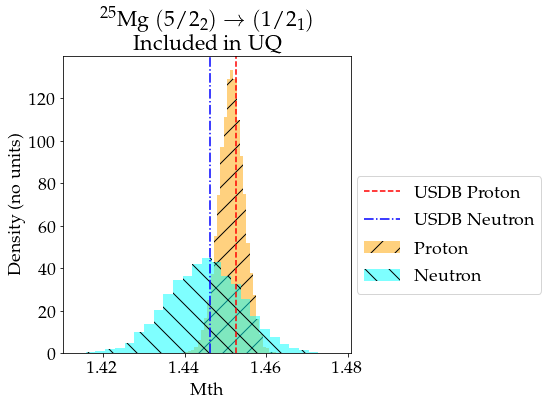

 31%|███▏      | 59/188 [07:54<17:14,  8.02s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
77           85  25      Mg  12  13      1964.624             0.023  5/2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
77  0.70 PS 0.06       1379.543  ...        68.611153             6.079469   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
77     25Mg  1/2      1   2   1     True  1.4525  1.4461  

[1 rows x 36 columns]
INDEX =  86
GlobalIndex                   86
A                             25
Element                       Mg
Z                             12
N                             13
Energy (keV)             2563.36
Energy Unc (keV)            0.05
Ji                           1/2
Thalf                    10 FS 5
E_gamma (keV)             2563.6
E_gamma Unc (keV)            0.4
I_gamma                      5.0
I_gamma Unc                  1.4
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef

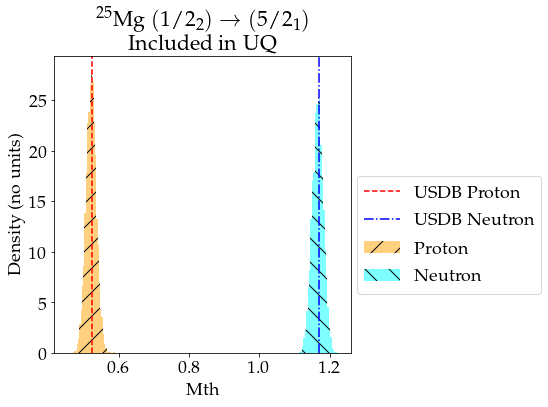

 32%|███▏      | 60/188 [08:02<17:04,  8.01s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
78           86  25      Mg  12  13       2563.36              0.05  1/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
78  10 FS 5         2563.6  ...        17.369912            13.027434   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
78     25Mg  5/2      5   2   1     True -0.5229 -1.168  

[1 rows x 36 columns]
INDEX =  87
GlobalIndex                   87
A                             25
Element                       Mg
Z                             12
N                             13
Energy (keV)              2737.8
Energy Unc (keV)             0.3
Ji                           7/2
Thalf                  290 FS 30
E_gamma (keV)             1763.5
E_gamma Unc (keV)            0.7
I_gamma                    100.0
I_gamma Unc                  2.3
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef            

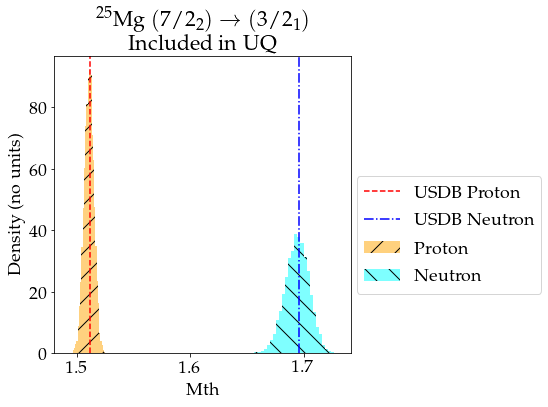

 32%|███▏      | 61/188 [08:11<17:14,  8.15s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
79           87  25      Mg  12  13        2737.8               0.3  7/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
79  290 FS 30         1763.5  ...        99.442747            10.856195   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
79     25Mg  3/2      3   2   1     True  1.5116  1.6961  

[1 rows x 36 columns]
INDEX =  88
GlobalIndex                    88
A                              25
Element                        Mg
Z                              12
N                              13
Energy (keV)              3405.06
Energy Unc (keV)             0.17
Ji                            9/2
Thalf                  7.7 FS 0.7
E_gamma (keV)              3404.7
E_gamma Unc (keV)             0.4
I_gamma                      22.7
I_gamma Unc                   2.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN

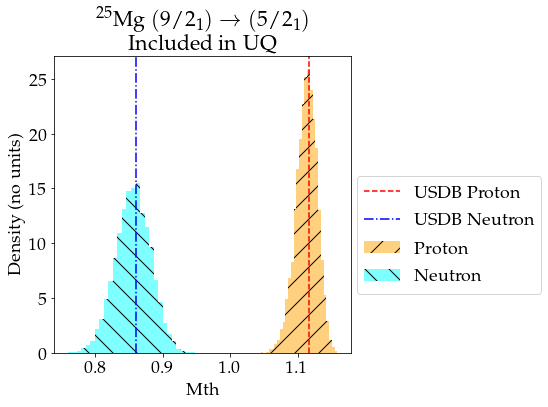

 33%|███▎      | 62/188 [08:19<16:52,  8.03s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
80           88  25      Mg  12  13       3405.06              0.17  9/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
80  7.7 FS 0.7         3404.7  ...        29.528851              3.90823   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
80     25Mg  5/2      5   1   1     True -1.1164 -0.8608  

[1 rows x 36 columns]
INDEX =  89
GlobalIndex                  89
A                            25
Element                      Mg
Z                            12
N                            13
Energy (keV)             4059.6
Energy Unc (keV)            0.3
Ji                          9/2
Thalf                   47 FS 5
E_gamma (keV)            4058.9
E_gamma Unc (keV)           0.5
I_gamma                   100.0
I_gamma Unc                 1.7
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   N

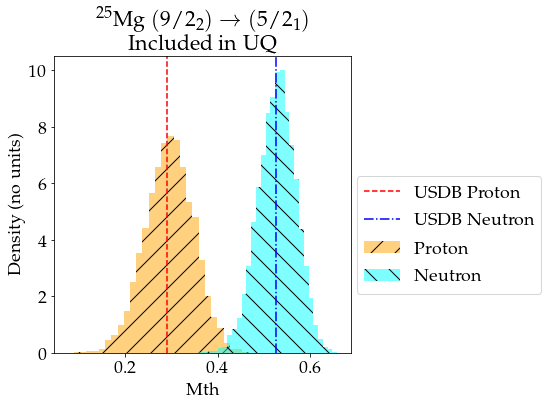

 34%|███▎      | 63/188 [08:26<16:38,  7.99s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
81           89  25      Mg  12  13        4059.6               0.3  9/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
81  47 FS 5         4058.9  ...         6.557142             0.738221   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
81     25Mg  5/2      5   2   1     True -0.2907 -0.5252  

[1 rows x 36 columns]
INDEX =  90
GlobalIndex                    90
A                              25
Element                        Mg
Z                              12
N                              13
Energy (keV)               4711.6
Energy Unc (keV)              0.4
Ji                            9/2
Thalf                     26 FS 3
E_gamma (keV)              2746.9
E_gamma Unc (keV)             0.5
I_gamma                     100.0
I_gamma Unc                   1.1
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Con

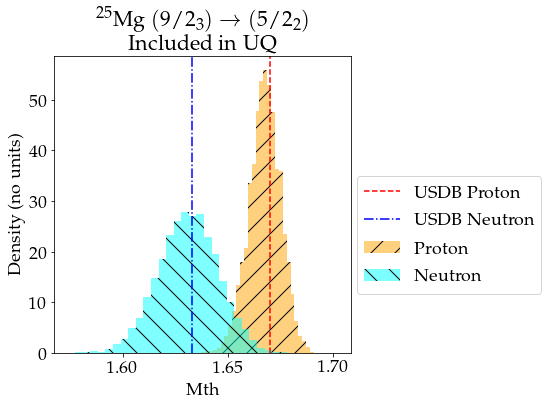

 34%|███▍      | 64/188 [08:35<16:33,  8.02s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
82           90  25      Mg  12  13        4711.6               0.4  9/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
82  26 FS 3         2746.9  ...       130.274342             21.71239   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
82     25Mg  5/2      5   3   2     True  1.6696  1.6328  

[1 rows x 36 columns]
INDEX =  91
GlobalIndex                   91
A                             25
Element                       Mg
Z                             12
N                             13
Energy (keV)             5251.63
Energy Unc (keV)            0.22
Ji                          11/2
Thalf                    15 FS 2
E_gamma (keV)             3639.5
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  3.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef          

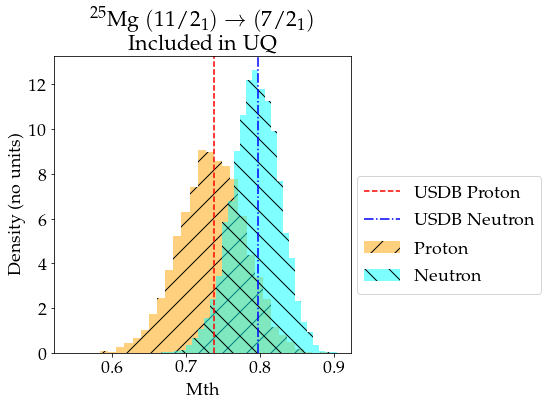

 35%|███▍      | 65/188 [08:43<16:24,  8.00s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
83           91  25      Mg  12  13       5251.63              0.22  11/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
83  15 FS 2         3639.5  ...        22.146638             5.210974   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
83     25Mg  7/2      7   1   1     True  0.7382  0.7964  

[1 rows x 36 columns]
INDEX =  92
GlobalIndex                  92
A                            25
Element                      Mg
Z                            12
N                            13
Energy (keV)            5251.63
Energy Unc (keV)           0.22
Ji                         11/2
Thalf                   15 FS 2
E_gamma (keV)            2515.7
E_gamma Unc (keV)           1.2
I_gamma                    32.0
I_gamma Unc                 3.0
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
C

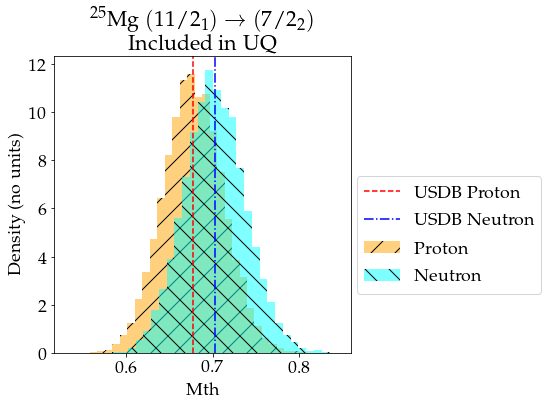

 35%|███▌      | 66/188 [08:50<16:14,  7.99s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
84           92  25      Mg  12  13       5251.63              0.22  11/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
84  15 FS 2         2515.7  ...         45.59602             7.816461   

    Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
84     25Mg  7/2      7   1   2     True -0.6777 -0.7022  

[1 rows x 36 columns]
INDEX =  94
GlobalIndex                   94
A                             25
Element                       Mg
Z                             12
N                             13
Energy (keV)              5533.8
Energy Unc (keV)             0.4
Ji                          11/2
Thalf                     6 FS 2
E_gamma (keV)             3922.0
E_gamma Unc (keV)            1.1
I_gamma                     61.0
I_gamma Unc                  6.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef        

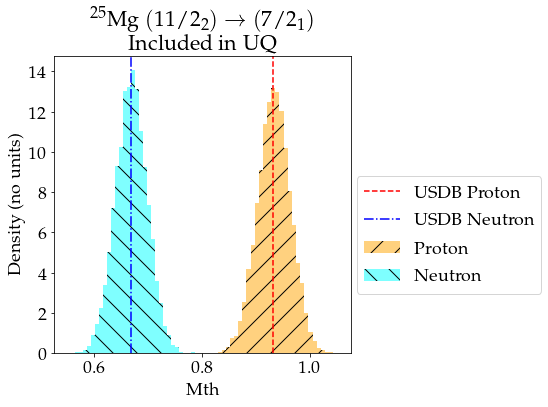

 36%|███▌      | 67/188 [08:59<16:09,  8.01s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
85           94  25      Mg  12  13        5533.8               0.4  11/2   

     Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  Nucleus  \
85  6 FS 2         3922.0  ...        39.082303            17.369912     25Mg   

     Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
85  7/2      7   2   1     True  0.9299  0.6679  

[1 rows x 36 columns]
INDEX =  95
GlobalIndex                   95
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)             1808.74
Energy Unc (keV)            0.04
Ji                             2
Thalf                  476 FS 21
E_gamma (keV)            1808.68
E_gamma Unc (keV)           0.04
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef          

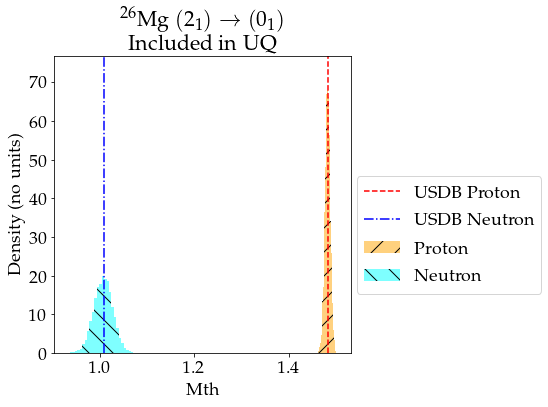

 36%|███▌      | 68/188 [09:06<15:48,  7.90s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
86           95  26      Mg  12  14       1808.74              0.04  2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
86  476 FS 21        1808.68  ...        61.313139             2.745364   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
86     26Mg  0      0   1   1     True  1.4828  1.0093  

[1 rows x 36 columns]
INDEX =  96
GlobalIndex                  96
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)            2938.33
Energy Unc (keV)           0.04
Ji                            2
Thalf                  141 FS 8
E_gamma (keV)           2938.15
E_gamma Unc (keV)          0.05
I_gamma                    10.7
I_gamma Unc                 0.6
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Co

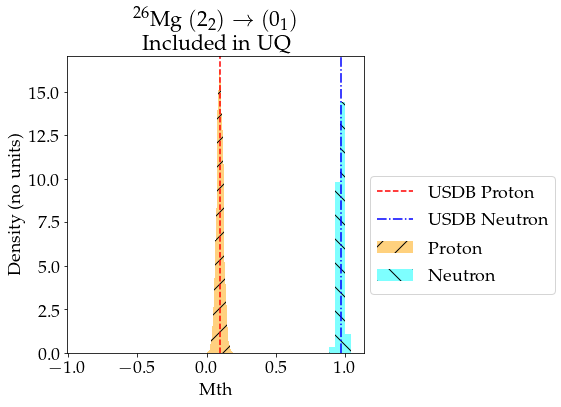

 37%|███▋      | 69/188 [09:14<15:42,  7.92s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
87           96  26      Mg  12  14       2938.33              0.04  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
87  141 FS 8        2938.15  ...         1.784487             0.183024   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
87     26Mg  0      0   2   1     True  0.0962  0.9687  

[1 rows x 36 columns]
INDEX =  97
GlobalIndex                      97
A                                26
Element                          Mg
Z                                12
N                                14
Energy (keV)                3588.56
Energy Unc (keV)               0.09
Ji                                0
Thalf                  6.45 PS 0.48
E_gamma (keV)               1779.74
E_gamma Unc (keV)              0.08
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                             E2
Mult Ratio                      NaN
Mult Ratio Un

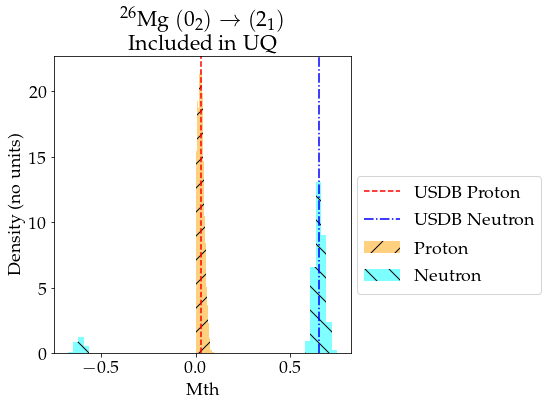

 37%|███▋      | 70/188 [09:22<15:41,  7.98s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
88           97  26      Mg  12  14       3588.56              0.09  0   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
88  6.45 PS 0.48        1779.74  ...           4.8959             0.366049   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
88     26Mg  2      4   2   1     True -0.0268 -0.6559  

[1 rows x 36 columns]
INDEX =  98
GlobalIndex                   98
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)             4318.89
Energy Unc (keV)            0.05
Ji                             4
Thalf                  272 FS 16
E_gamma (keV)            2510.01
E_gamma Unc (keV)           0.05
I_gamma                    100.0
I_gamma Unc                  2.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef        

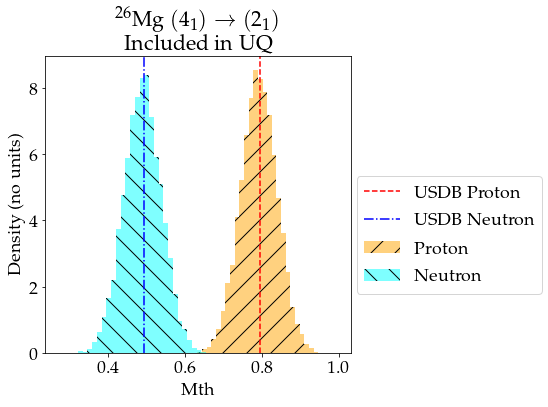

 38%|███▊      | 71/188 [09:30<15:42,  8.05s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
89           98  26      Mg  12  14       4318.89              0.05  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
89  272 FS 16        2510.01  ...        20.590233             1.372682   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
89     26Mg  2      4   1   1     True  0.7941  0.4914  

[1 rows x 36 columns]
INDEX =  99
GlobalIndex                  99
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)            4332.52
Energy Unc (keV)           0.05
Ji                            2
Thalf                   20 FS 3
E_gamma (keV)            4332.2
E_gamma Unc (keV)           0.3
I_gamma                     7.6
I_gamma Unc                 0.8
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Co

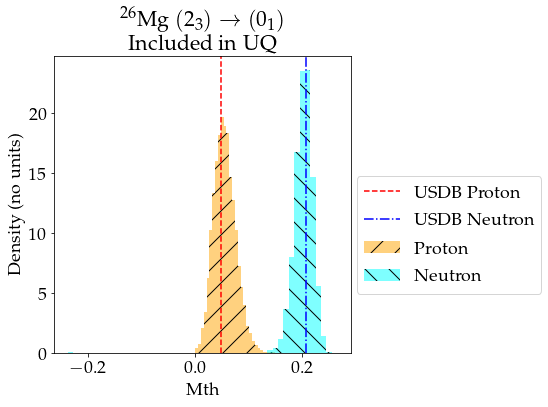

 38%|███▊      | 72/188 [09:38<15:32,  8.04s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
90           99  26      Mg  12  14       4332.52              0.05  2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
90  20 FS 3         4332.2  ...         1.098146              0.22878   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
90     26Mg  0      0   3   1     True  0.0487  0.2075  

[1 rows x 36 columns]
INDEX =  100
GlobalIndex                 100
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)            4835.13
Energy Unc (keV)           0.05
Ji                            2
Thalf                   28 FS 6
E_gamma (keV)           4834.61
E_gamma Unc (keV)          0.18
I_gamma                    10.8
I_gamma Unc                 0.9
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef 

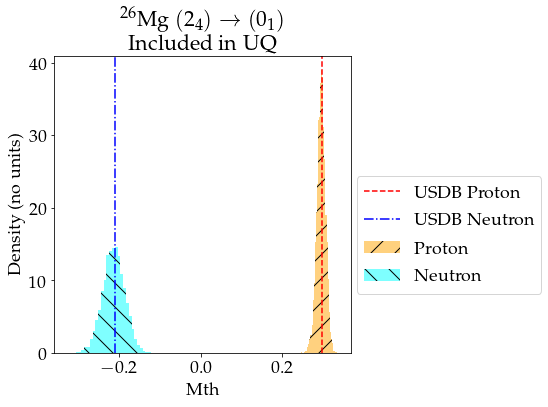

 39%|███▉      | 73/188 [09:46<15:23,  8.03s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
91          100  26      Mg  12  14       4835.13              0.05  2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
91  28 FS 6        4834.61  ...         0.686341             0.183024   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
91     26Mg  0      0   4   1     True  0.2967 -0.211  

[1 rows x 36 columns]
INDEX =  101
GlobalIndex                  101
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)             4901.44
Energy Unc (keV)            0.07
Ji                             4
Thalf                    29 FS 6
E_gamma (keV)            3092.31
E_gamma Unc (keV)           0.11
I_gamma                    100.0
I_gamma Unc                  1.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                   

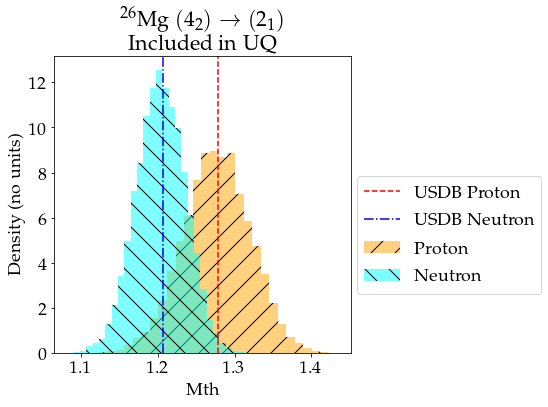

 39%|███▉      | 74/188 [09:55<15:30,  8.16s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
92          101  26      Mg  12  14       4901.44              0.07  4   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
92  29 FS 6        3092.31  ...        64.058503            13.726822   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
92     26Mg  2      4   2   1     True  1.2782  1.2061  

[1 rows x 36 columns]
INDEX =  102
GlobalIndex                  102
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)             4901.44
Energy Unc (keV)            0.07
Ji                             4
Thalf                    29 FS 6
E_gamma (keV)            1962.99
E_gamma Unc (keV)           0.24
I_gamma                     1.89
I_gamma Unc                 0.14
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                 

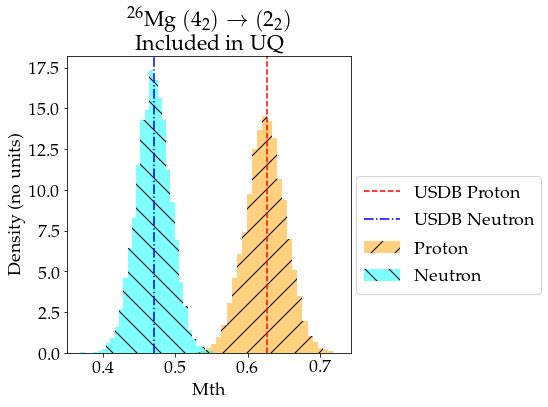

 40%|███▉      | 75/188 [10:03<15:25,  8.19s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
93          102  26      Mg  12  14       4901.44              0.07  4   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
93  29 FS 6        1962.99  ...        11.439018             2.745364   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
93     26Mg  2      4   2   2     True  0.6268  0.4704  

[1 rows x 36 columns]
INDEX =  104
GlobalIndex                  104
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)              4972.3
Energy Unc (keV)            0.13
Ji                             0
Thalf                  446 FS 70
E_gamma (keV)            2033.88
E_gamma Unc (keV)           0.12
I_gamma                    100.0
I_gamma Unc                  4.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                 

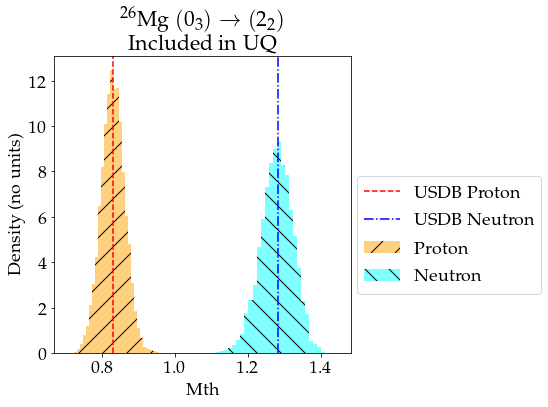

 40%|████      | 76/188 [10:11<15:18,  8.20s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
95          104  26      Mg  12  14        4972.3              0.13  0   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
95  446 FS 70        2033.88  ...        33.859495              5.94829   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
95     26Mg  2      4   3   2     True  0.8289  1.2806  

[1 rows x 36 columns]
INDEX =  105
GlobalIndex                 105
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)            5476.05
Energy Unc (keV)           0.07
Ji                            4
Thalf                   21 FS 6
E_gamma (keV)            3667.4
E_gamma Unc (keV)           0.5
I_gamma                    25.0
I_gamma Unc                 2.0
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv C

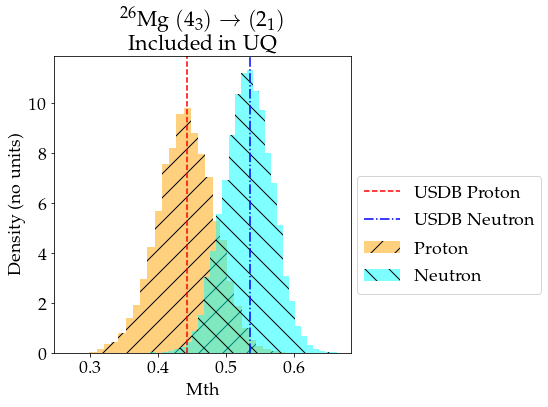

 41%|████      | 77/188 [10:20<15:13,  8.23s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
96          105  26      Mg  12  14       5476.05              0.07  4   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
96  21 FS 6         3667.4  ...         5.033168             1.830243   

    Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
96     26Mg  2      4   3   1     True -0.443 -0.5358  

[1 rows x 36 columns]
INDEX =  106
GlobalIndex                 106
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)            5715.91
Energy Unc (keV)           0.08
Ji                            4
Thalf                  53 FS 16
E_gamma (keV)           2776.82
E_gamma Unc (keV)           0.2
I_gamma                    51.4
I_gamma Unc                 1.4
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef Un

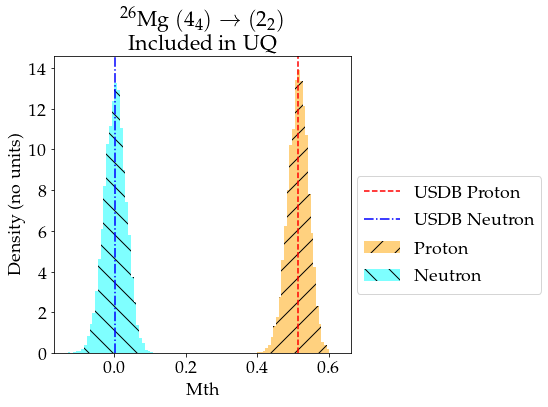

 41%|████▏     | 78/188 [10:28<14:56,  8.15s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
97          106  26      Mg  12  14       5715.91              0.08  4   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
97  53 FS 16        2776.82  ...         7.778533             2.287804   

    Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
97     26Mg  2      4   4   2     True  0.515  0.0008  

[1 rows x 36 columns]
INDEX =  107
GlobalIndex                 107
A                            26
Element                      Mg
Z                            12
N                            14
Energy (keV)             6256.2
Energy Unc (keV)            1.4
Ji                            0
Thalf                  53 FS 31
E_gamma (keV)            4447.1
E_gamma Unc (keV)           0.0
I_gamma                   100.0
I_gamma Unc                 4.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv Coef 

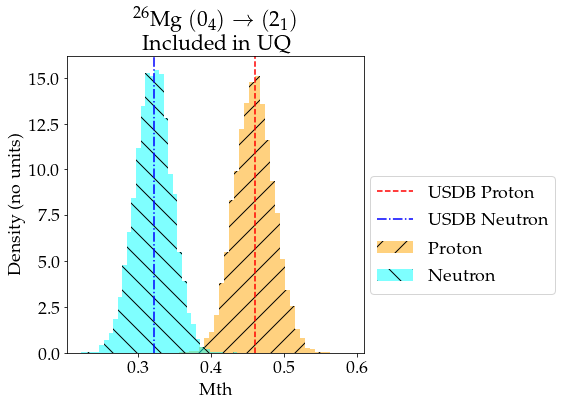

 42%|████▏     | 79/188 [10:36<14:55,  8.21s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
98          107  26      Mg  12  14        6256.2               1.4  0   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
98  53 FS 31         4447.1  ...         5.490729             3.660486   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
98     26Mg  2      4   4   1     True  0.4595  0.3209  

[1 rows x 36 columns]
INDEX =  108
GlobalIndex                  108
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)             6622.94
Energy Unc (keV)            0.14
Ji                             4
Thalf                    19 FS 5
E_gamma (keV)             2290.2
E_gamma Unc (keV)            0.3
I_gamma                     26.2
I_gamma Unc                  1.4
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               

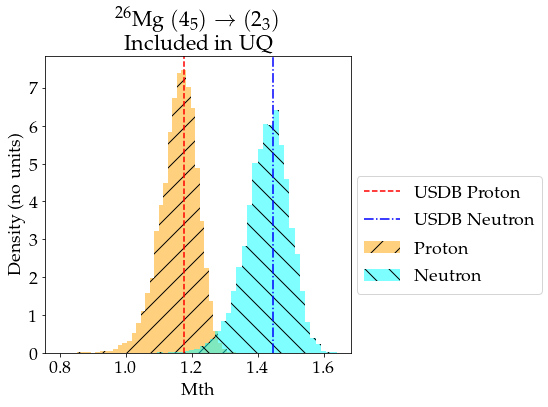

 43%|████▎     | 80/188 [10:44<14:48,  8.22s/it]

    GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
99          108  26      Mg  12  14       6622.94              0.14  4   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
99  19 FS 5         2290.2  ...        54.907289             18.30243   

    Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
99     26Mg  2      4   5   3     True -1.1766 -1.4473  

[1 rows x 36 columns]
INDEX =  109
GlobalIndex                  109
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)              6978.3
Energy Unc (keV)             0.8
Ji                             5
Thalf                    14 FS 5
E_gamma (keV)             3036.5
E_gamma Unc (keV)            0.0
I_gamma                     28.0
I_gamma Unc                  4.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef                 

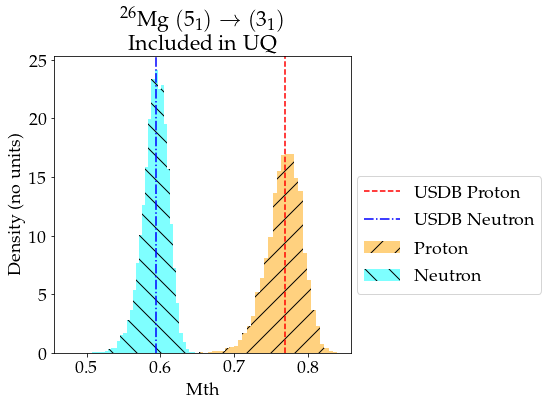

 43%|████▎     | 81/188 [10:53<14:40,  8.23s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
100          109  26      Mg  12  14        6978.3               0.8  5   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
100  14 FS 5         3036.5  ...        21.962915             8.693654   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
100     26Mg  3      6   1   1     True -0.7687 -0.5944  

[1 rows x 36 columns]
INDEX =  110
GlobalIndex                  110
A                             26
Element                       Mg
Z                             12
N                             14
Energy (keV)              6978.3
Energy Unc (keV)             0.8
Ji                             5
Thalf                    14 FS 5
E_gamma (keV)             2628.1
E_gamma Unc (keV)            0.0
I_gamma                      9.0
I_gamma Unc                  2.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

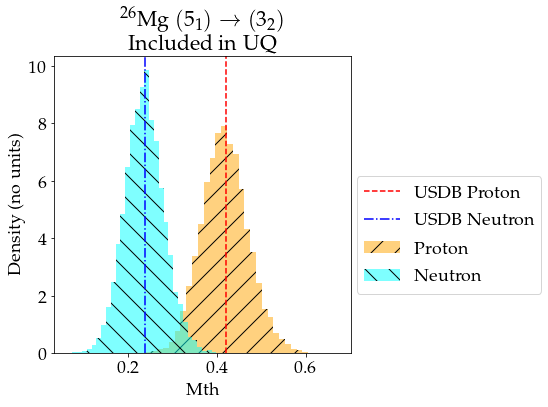

 44%|████▎     | 82/188 [11:01<14:50,  8.40s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
101          110  26      Mg  12  14        6978.3               0.8  5   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
101  14 FS 5         2628.1  ...        14.641944              6.40585   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
101     26Mg  3      6   1   2     True -0.4202 -0.2369  

[1 rows x 36 columns]
INDEX =  111
GlobalIndex                     111
A                                27
Element                          Mg
Z                                12
N                                15
Energy (keV)                1698.52
Energy Unc (keV)               0.08
Ji                              5/2
Thalf                  0.81 PS 0.17
E_gamma (keV)               1698.46
E_gamma Unc (keV)              0.23
I_gamma                       100.0
I_gamma Unc                     6.0
Mult                             E2
Mult Ratio                      NaN
Mult Rat

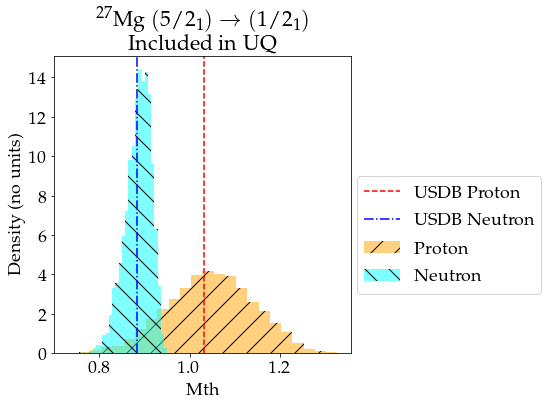

 44%|████▍     | 83/188 [11:10<14:35,  8.34s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
102          111  27      Mg  12  15       1698.52              0.08  5/2   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
102  0.81 PS 0.17        1698.46  ...        48.598629            11.067014   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
102     27Mg  1/2      1   1   1     True  1.0317  0.8847  

[1 rows x 36 columns]
INDEX =  112
GlobalIndex                   112
A                              28
Element                        Mg
Z                              12
N                              16
Energy (keV)              1473.54
Energy Unc (keV)              0.1
Ji                              2
Thalf                  1.2 PS 0.1
E_gamma (keV)              1473.5
E_gamma Unc (keV)             0.1
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc      

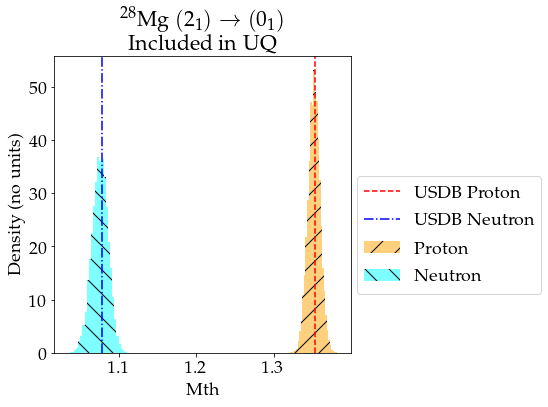

 45%|████▍     | 84/188 [11:18<14:23,  8.30s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
103          112  28      Mg  12  16       1473.54               0.1  2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
103  1.2 PS 0.1         1473.5  ...        67.680952             6.060981   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
103     28Mg  0      0   1   1     True -1.3531 -1.0781  

[1 rows x 36 columns]
INDEX =  113
GlobalIndex                     113
A                                28
Element                          Mg
Z                                12
N                                16
Energy (keV)                3862.15
Energy Unc (keV)               0.14
Ji                                0
Thalf                  0.55 PS 0.07
E_gamma (keV)                2388.5
E_gamma Unc (keV)               0.1
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                             E2
Mult Ratio                      NaN
Mu

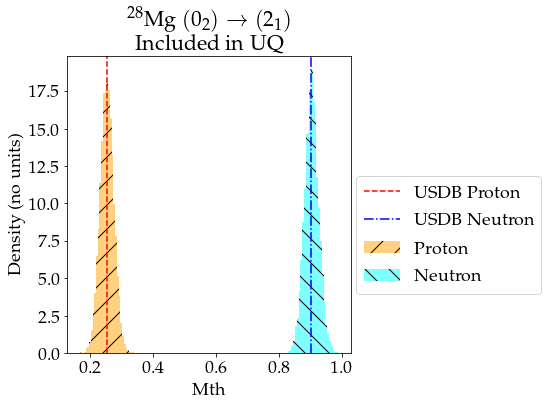

 45%|████▌     | 85/188 [11:26<14:18,  8.33s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
104          113  28      Mg  12  16       3862.15              0.14  0   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
104  0.55 PS 0.07         2388.5  ...        13.132125             2.020327   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
104     28Mg  2      4   2   1     True  0.2528  0.9005  

[1 rows x 36 columns]
INDEX =  114
GlobalIndex                  114
A                             28
Element                       Mg
Z                             12
N                             16
Energy (keV)              4021.0
Energy Unc (keV)             0.5
Ji                             4
Thalf                  105 FS 35
E_gamma (keV)             2547.7
E_gamma Unc (keV)            0.6
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

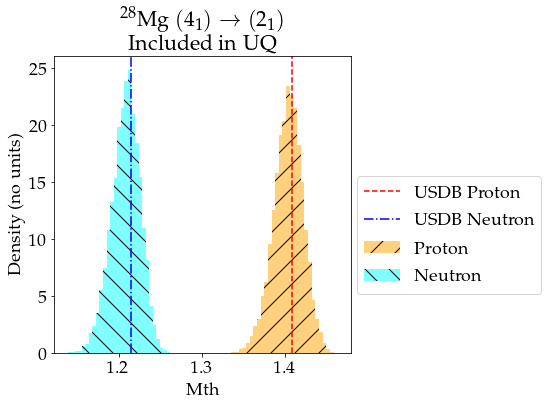

 46%|████▌     | 86/188 [11:34<14:03,  8.27s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
105          114  28      Mg  12  16        4021.0               0.5  4   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
105  105 FS 35         2547.7  ...        50.508173            20.203269   

     Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
105     28Mg  2      4   1   1     True  1.408  1.2146  

[1 rows x 36 columns]
INDEX =  116
GlobalIndex                   116
A                              30
Element                        Mg
Z                              12
N                              18
Energy (keV)               1482.8
Energy Unc (keV)              0.3
Ji                              2
Thalf                  1.5 PS 0.2
E_gamma (keV)              1482.1
E_gamma Unc (keV)             0.5
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Co

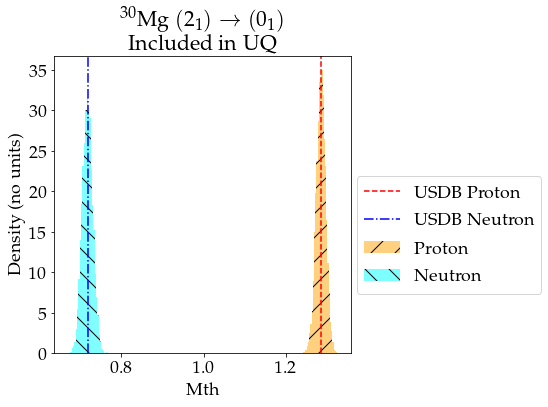

 46%|████▋     | 87/188 [11:43<13:58,  8.30s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
107          116  30      Mg  12  18        1482.8               0.3  2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
107  1.5 PS 0.2         1482.1  ...        52.606115             7.198732   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
107     30Mg  0      0   1   1     True  1.2846  0.7186  

[1 rows x 36 columns]
INDEX =  117
GlobalIndex                   117
A                              30
Element                        Mg
Z                              12
N                              18
Energy (keV)               1788.2
Energy Unc (keV)              0.4
Ji                              0
Thalf                  3.9 NS 0.4
E_gamma (keV)               305.5
E_gamma Unc (keV)             0.3
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                Na

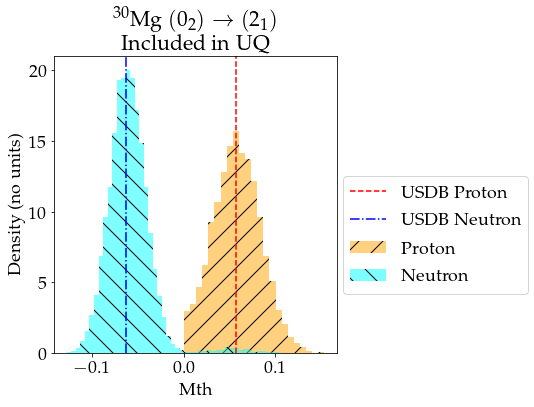

 47%|████▋     | 88/188 [11:51<13:51,  8.32s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
108          117  30      Mg  12  18        1788.2               0.4  0   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
108  3.9 NS 0.4          305.5  ...        54.267361             6.091234   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
108     30Mg  2      4   2   1     True -0.0567  0.063  

[1 rows x 36 columns]
INDEX =  119
GlobalIndex                     119
A                                25
Element                          Al
Z                                13
N                                12
Energy (keV)                  451.7
Energy Unc (keV)                0.5
Ji                              1/2
Thalf                  2.29 NS 0.04
E_gamma (keV)                 451.7
E_gamma Unc (keV)               0.5
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                           [E2]
Mult Ratio                      NaN
Mult

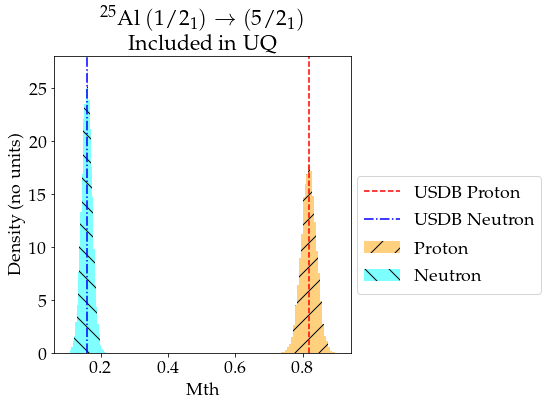

 47%|████▋     | 89/188 [11:59<13:39,  8.27s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
110          119  25      Al  13  12         451.7               0.5  1/2   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
110  2.29 NS 0.04          451.7  ...        13.157709             0.260549   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
110     25Al  5/2      5   1   1     True -0.8185 -0.1598  

[1 rows x 36 columns]
INDEX =  120
GlobalIndex                   120
A                              25
Element                        Al
Z                              13
N                              12
Energy (keV)               3424.2
Energy Unc (keV)              0.8
Ji                            9/2
Thalf                  9.0 FS 1.4
E_gamma (keV)              3423.9
E_gamma Unc (keV)             0.8
I_gamma                      19.0
I_gamma Unc                   5.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc      

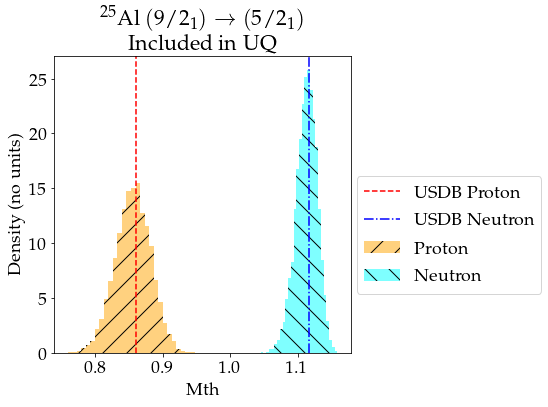

 48%|████▊     | 90/188 [12:07<13:23,  8.20s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
111          120  25      Al  13  12        3424.2               0.8  9/2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
111  9.0 FS 1.4         3423.9  ...        20.843895             6.947965   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
111     25Al  5/2      5   1   1     True -0.8608 -1.1164  

[1 rows x 36 columns]
INDEX =  121
GlobalIndex                     121
A                                26
Element                          Al
Z                                13
N                                13
Energy (keV)                416.852
Energy Unc (keV)              0.003
Ji                                3
Thalf                  1.20 NS 0.01
E_gamma (keV)               416.848
E_gamma Unc (keV)               0.0
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                           [E2]
Mult Ratio                    

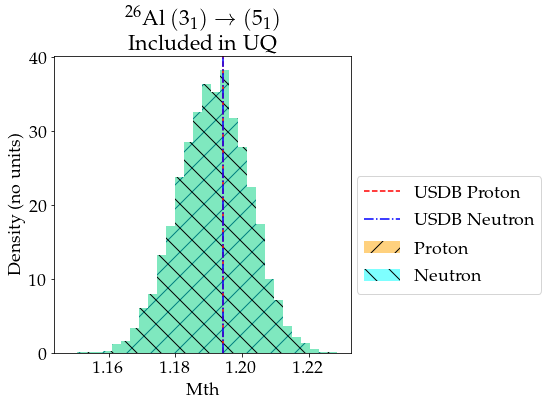

 48%|████▊     | 91/188 [12:15<13:01,  8.05s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
112          121  26      Al  13  13       416.852             0.003  3   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
112  1.20 NS 0.01        416.848  ...        37.474224             0.549073   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
112     26Al  5     10   1   1     True  1.1943  1.1943  

[1 rows x 36 columns]
INDEX =  122
GlobalIndex                  122
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             1850.62
Energy Unc (keV)            0.03
Ji                             1
Thalf                    32 FS 3
E_gamma (keV)            1433.73
E_gamma Unc (keV)            0.0
I_gamma                      0.7
I_gamma Unc                  0.1
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

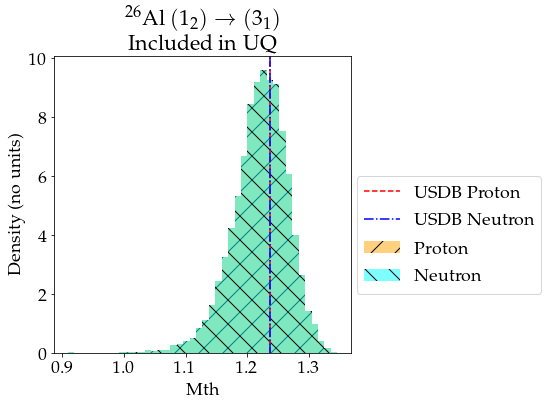

 49%|████▉     | 92/188 [12:23<12:51,  8.03s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
113          122  26      Al  13  13       1850.62              0.03  1   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
113  32 FS 3        1433.73  ...        20.132672             3.660486   

     Nucleus Jf  twoJf  ni  nf  Include  Mth_p  Mth_n  
113     26Al  3      6   2   1     True -1.236 -1.236  

[1 rows x 36 columns]
INDEX =  123
GlobalIndex                  123
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             2069.47
Energy Unc (keV)            0.03
Ji                             2
Thalf                    14 FS 2
E_gamma (keV)            1841.09
E_gamma Unc (keV)            0.0
I_gamma                      4.0
I_gamma Unc                  0.5
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef               

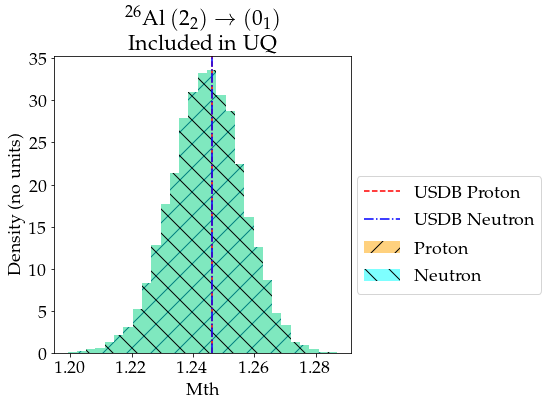

 49%|████▉     | 93/188 [12:31<12:42,  8.03s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
114          123  26      Al  13  13       2069.47              0.03  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
114  14 FS 2        1841.09  ...        57.652653            10.981458   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
114     26Al  0      0   2   1     True -1.2461 -1.2461  

[1 rows x 36 columns]
INDEX =  124
GlobalIndex                  124
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             2071.64
Energy Unc (keV)            0.04
Ji                             1
Thalf                  367 FS 69
E_gamma (keV)            1654.73
E_gamma Unc (keV)            0.0
I_gamma                     11.9
I_gamma Unc                  1.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

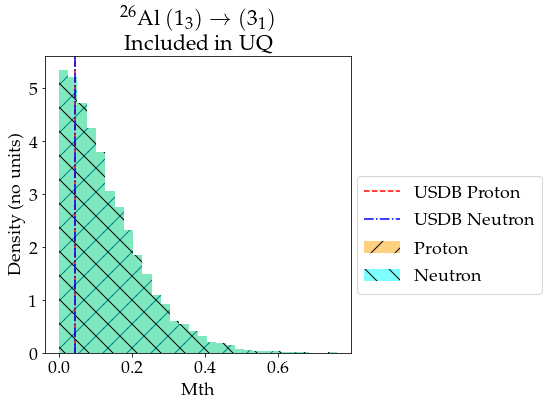

 50%|█████     | 94/188 [12:39<12:33,  8.02s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
115          124  26      Al  13  13       2071.64              0.04  1   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
115  367 FS 69        1654.73  ...        13.269261             2.745364   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
115     26Al  3      6   3   1     True -0.0453 -0.0453  

[1 rows x 36 columns]
INDEX =  125
GlobalIndex                   125
A                              26
Element                        Al
Z                              13
N                              13
Energy (keV)              2365.15
Energy Unc (keV)            0.018
Ji                              3
Thalf                  0.8 PS 0.2
E_gamma (keV)            1307.375
E_gamma Unc (keV)             0.0
I_gamma                      26.9
I_gamma Unc                   0.8
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                NaN


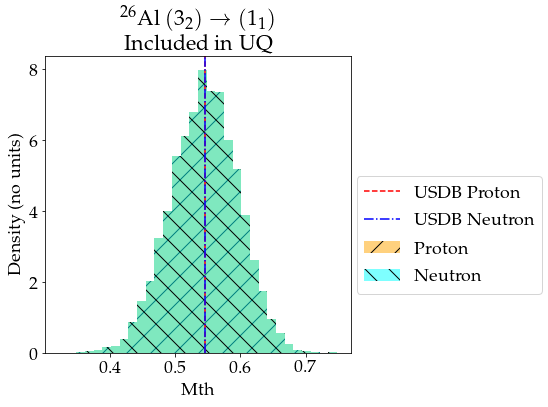

 51%|█████     | 95/188 [12:47<12:15,  7.91s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
116          125  26      Al  13  13       2365.15             0.018  3   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
116  0.8 PS 0.2       1307.375  ...        25.165841              6.40585   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
116     26Al  1      2   2   1     True  0.5454  0.5454  

[1 rows x 36 columns]
INDEX =  128
GlobalIndex                     128
A                                26
Element                          Al
Z                                13
N                                13
Energy (keV)               2545.367
Energy Unc (keV)              0.017
Ji                                3
Thalf                  0.69 PS 0.17
E_gamma (keV)              1487.582
E_gamma Unc (keV)               0.0
I_gamma                         3.7
I_gamma Unc                     0.3
Mult                           [E2]
Mult Ratio                      NaN
Mu

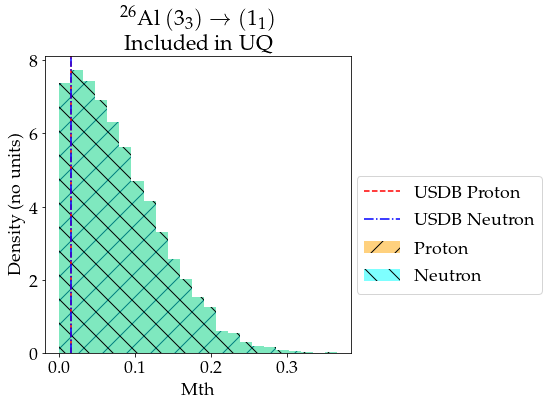

 51%|█████     | 96/188 [12:55<12:10,  7.94s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
119          128  26      Al  13  13      2545.367             0.017  3   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
119  0.69 PS 0.17       1487.582  ...         2.836877             0.732097   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
119     26Al  1      2   3   1     True -0.0152 -0.0152  

[1 rows x 36 columns]
INDEX =  129
GlobalIndex                 129
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            2740.03
Energy Unc (keV)           0.03
Ji                            1
Thalf                   31 FS 3
E_gamma (keV)           2323.07
E_gamma Unc (keV)           0.0
I_gamma                    0.81
I_gamma Unc                 0.2
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                 

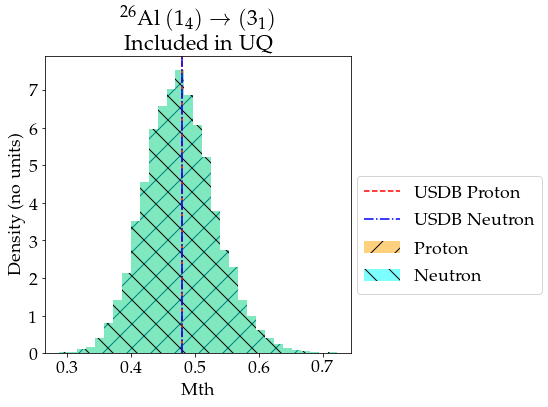

 52%|█████▏    | 97/188 [13:03<12:08,  8.01s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
120          129  26      Al  13  13       2740.03              0.03  1   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
120  31 FS 3        2323.07  ...         2.150535             0.594829   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
120     26Al  3      6   4   1     True  0.4804  0.4804  

[1 rows x 36 columns]
INDEX =  131
GlobalIndex                  131
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3073.63
Energy Unc (keV)            0.04
Ji                             3
Thalf                  194 FS 31
E_gamma (keV)            2015.81
E_gamma Unc (keV)            0.0
I_gamma                     14.7
I_gamma Unc                  0.5
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

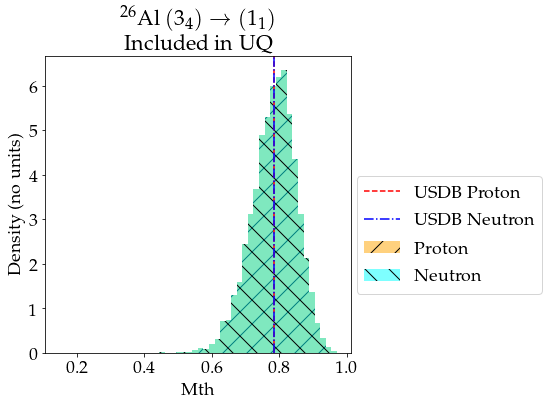

 52%|█████▏    | 98/188 [13:11<12:12,  8.14s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
122          131  26      Al  13  13       3073.63              0.04  3   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
122  194 FS 31        2015.81  ...        10.523897             1.830243   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
122     26Al  1      2   4   1     True -0.7833 -0.7833  

[1 rows x 36 columns]
INDEX =  132
GlobalIndex                  132
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3073.63
Energy Unc (keV)            0.04
Ji                             3
Thalf                  194 FS 31
E_gamma (keV)            1222.98
E_gamma Unc (keV)            0.0
I_gamma                     3.23
I_gamma Unc                  0.1
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

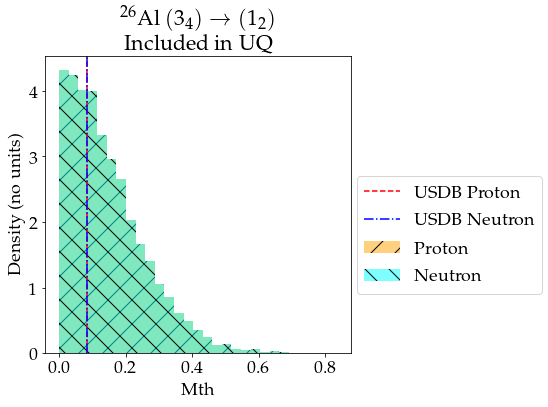

 53%|█████▎    | 99/188 [13:19<12:03,  8.13s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
123          132  26      Al  13  13       3073.63              0.04  3   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
123  194 FS 31        1222.98  ...        28.826326             5.033168   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
123     26Al  1      2   4   2     True -0.0834 -0.0834  

[1 rows x 36 columns]
INDEX =  133
GlobalIndex                   133
A                              26
Element                        Al
Z                              13
N                              13
Energy (keV)             3159.889
Energy Unc (keV)            0.013
Ji                              2
Thalf                  3.5 FS 0.7
E_gamma (keV)            2931.406
E_gamma Unc (keV)             0.0
I_gamma                      0.69
I_gamma Unc                  0.08
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN


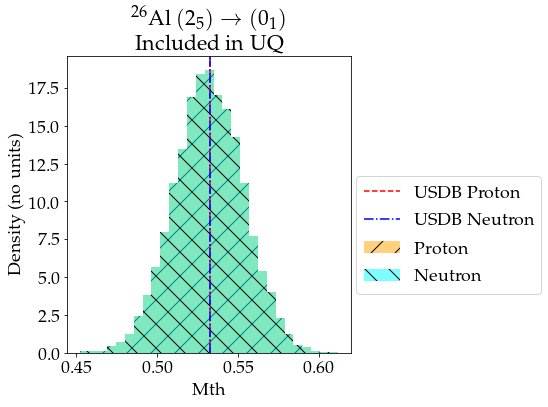

 53%|█████▎    | 100/188 [13:28<11:58,  8.16s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
124          133  26      Al  13  13      3159.889             0.013  2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
124  3.5 FS 0.7       2931.406  ...         3.294437             0.777853   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
124     26Al  0      0   5   1     True -0.5325 -0.5325  

[1 rows x 36 columns]
INDEX =  134
GlobalIndex                  134
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3402.65
Energy Unc (keV)            0.06
Ji                             5
Thalf                   67 FS 12
E_gamma (keV)            1037.48
E_gamma Unc (keV)            0.0
I_gamma                     0.84
I_gamma Unc                 0.11
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef     

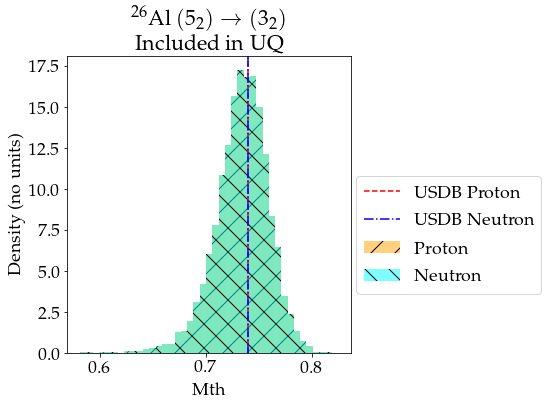

 54%|█████▎    | 101/188 [13:36<11:56,  8.24s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
125          134  26      Al  13  13       3402.65              0.06  5   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
125  67 FS 12        1037.48  ...        33.859495             7.778533   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
125     26Al  3      6   2   2     True -0.7395 -0.7395  

[1 rows x 36 columns]
INDEX =  135
GlobalIndex                  135
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3402.65
Energy Unc (keV)            0.06
Ji                             5
Thalf                   67 FS 12
E_gamma (keV)            2985.61
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  1.8
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef         

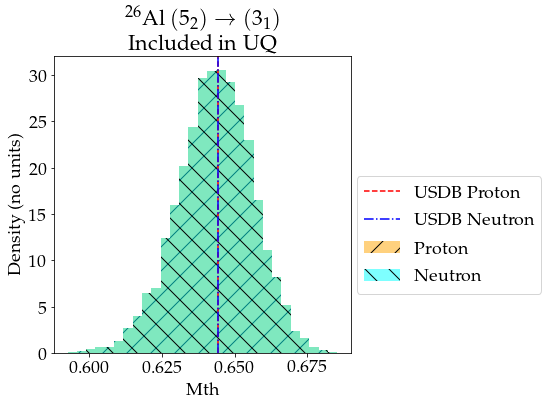

 54%|█████▍    | 102/188 [13:44<11:38,  8.12s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
126          135  26      Al  13  13       3402.65              0.06  5   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
126  67 FS 12        2985.61  ...        20.132672             3.660486   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
126     26Al  3      6   2   1     True  0.6443  0.6443  

[1 rows x 36 columns]
INDEX =  137
GlobalIndex                 137
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            3596.34
Energy Unc (keV)           0.04
Ji                            3
Thalf                   18 FS 3
E_gamma (keV)           3596.07
E_gamma Unc (keV)           0.0
I_gamma                    4.02
I_gamma Unc                0.22
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Co

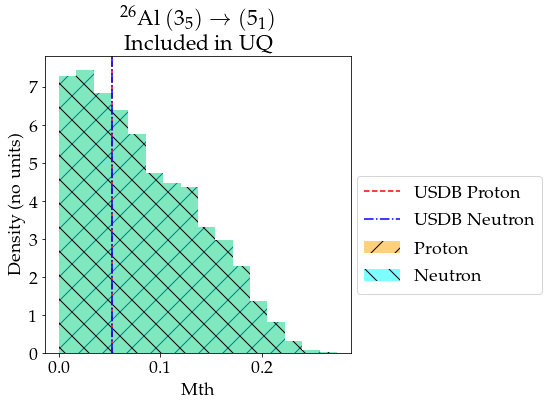

 55%|█████▍    | 103/188 [13:52<11:26,  8.07s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
127          137  26      Al  13  13       3596.34              0.04  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
127  18 FS 3        3596.07  ...         1.921755             0.366049   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
127     26Al  5     10   5   1     True -0.0523 -0.0523  

[1 rows x 36 columns]
INDEX =  138
GlobalIndex                 138
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            3596.34
Energy Unc (keV)           0.04
Ji                            3
Thalf                   18 FS 3
E_gamma (keV)           2538.47
E_gamma Unc (keV)           0.0
I_gamma                    3.48
I_gamma Unc                0.11
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv

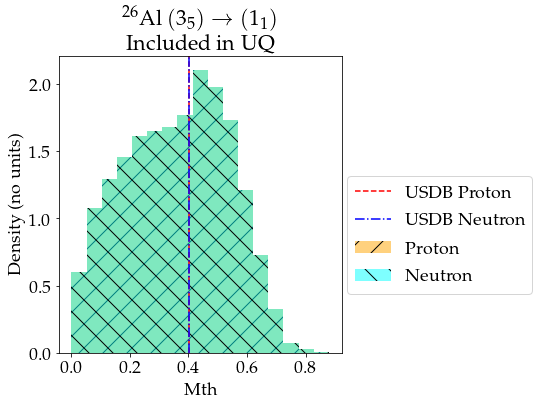

 55%|█████▌    | 104/188 [14:00<11:18,  8.08s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
128          138  26      Al  13  13       3596.34              0.04  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
128  18 FS 3        2538.47  ...         9.608775             1.830243   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
128     26Al  1      2   5   1     True  0.4027  0.4027  

[1 rows x 36 columns]
INDEX =  139
GlobalIndex                  139
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3596.34
Energy Unc (keV)            0.04
Ji                             3
Thalf                    18 FS 3
E_gamma (keV)            1745.66
E_gamma Unc (keV)            0.0
I_gamma                     1.07
I_gamma Unc                 0.07
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

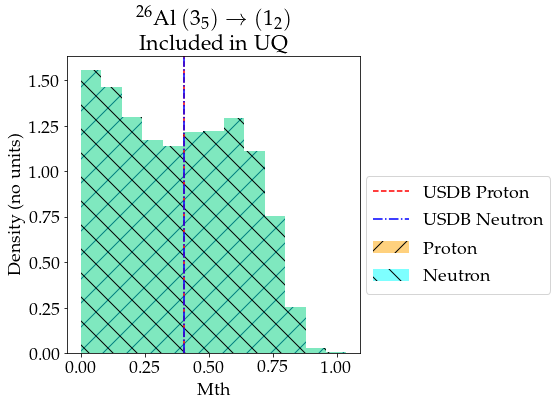

 56%|█████▌    | 105/188 [14:08<11:07,  8.05s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
129          139  26      Al  13  13       3596.34              0.04  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
129  18 FS 3        1745.66  ...        19.217551             3.660486   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
129     26Al  1      2   5   2     True -0.4043 -0.4043  

[1 rows x 36 columns]
INDEX =  140
GlobalIndex                  140
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3674.92
Energy Unc (keV)            0.05
Ji                             4
Thalf                  155 FS 20
E_gamma (keV)            1915.81
E_gamma Unc (keV)            0.0
I_gamma                     48.0
I_gamma Unc                  1.4
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

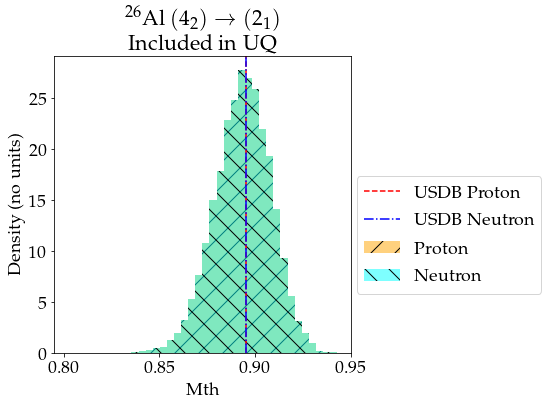

 56%|█████▋    | 106/188 [14:16<10:50,  7.93s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
130          140  26      Al  13  13       3674.92              0.05  4   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
130  155 FS 20        1915.81  ...        38.892663             5.490729   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
130     26Al  2      4   2   1     True  0.8953  0.8953  

[1 rows x 36 columns]
INDEX =  141
GlobalIndex                   141
A                              26
Element                        Al
Z                              13
N                              13
Energy (keV)              3680.68
Energy Unc (keV)             0.06
Ji                              3
Thalf                  8.3 FS 1.4
E_gamma (keV)              3680.4
E_gamma Unc (keV)             0.0
I_gamma                      0.77
I_gamma Unc                  0.08
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                NaN


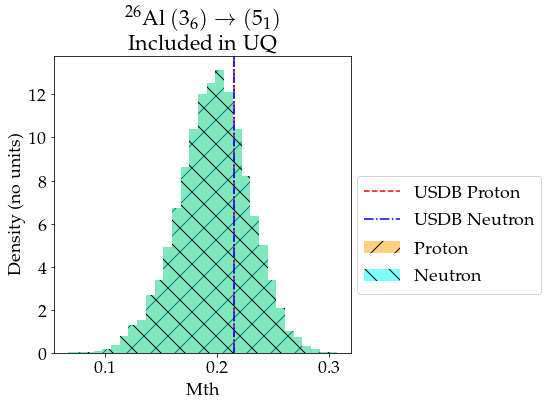

 57%|█████▋    | 107/188 [14:24<10:47,  8.00s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
131          141  26      Al  13  13       3680.68              0.06  3   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
131  8.3 FS 1.4         3680.4  ...         0.732097             0.183024   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
131     26Al  5     10   6   1     True  0.2151  0.2151  

[1 rows x 36 columns]
INDEX =  142
GlobalIndex                   142
A                              26
Element                        Al
Z                              13
N                              13
Energy (keV)              3680.68
Energy Unc (keV)             0.06
Ji                              3
Thalf                  8.3 FS 1.4
E_gamma (keV)              2622.8
E_gamma Unc (keV)             0.0
I_gamma                      2.79
I_gamma Unc                  0.21
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                Na

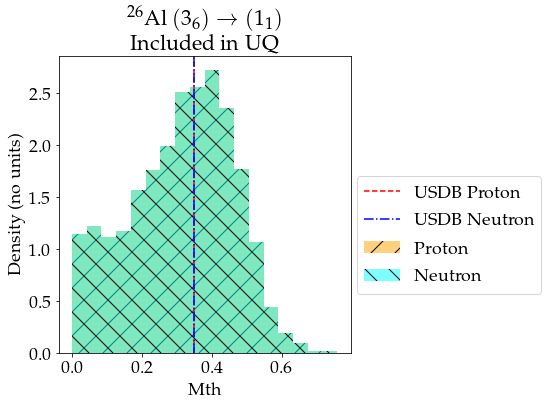

 57%|█████▋    | 108/188 [14:32<10:36,  7.95s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
132          142  26      Al  13  13       3680.68              0.06  3   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
132  8.3 FS 1.4         2622.8  ...        14.184383             2.745364   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
132     26Al  1      2   6   1     True  0.3499  0.3499  

[1 rows x 36 columns]
INDEX =  143
GlobalIndex                   143
A                              26
Element                        Al
Z                              13
N                              13
Energy (keV)              3680.68
Energy Unc (keV)             0.06
Ji                              3
Thalf                  8.3 FS 1.4
E_gamma (keV)             1829.99
E_gamma Unc (keV)             0.0
I_gamma                      0.19
I_gamma Unc                  0.04
Mult                         [E2]
Mult Ratio                    NaN
Mult Ratio Unc                Na

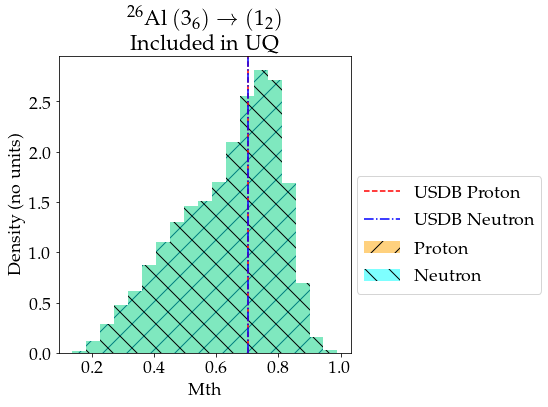

 58%|█████▊    | 109/188 [14:39<10:25,  7.92s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
133          143  26      Al  13  13       3680.68              0.06  3   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
133  8.3 FS 1.4        1829.99  ...          5.94829             1.830243   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
133     26Al  1      2   6   2     True -0.7023 -0.7023  

[1 rows x 36 columns]
INDEX =  144
GlobalIndex                 144
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            3962.83
Energy Unc (keV)           0.05
Ji                            3
Thalf                   37 FS 5
E_gamma (keV)            3962.5
E_gamma Unc (keV)           0.0
I_gamma                     7.9
I_gamma Unc                 0.4
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   Na

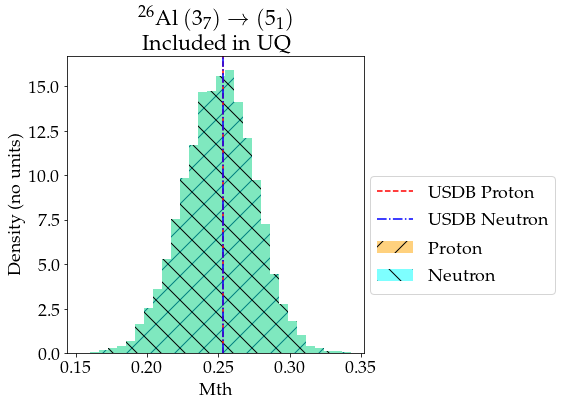

 59%|█████▊    | 110/188 [14:48<10:23,  7.99s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
134          144  26      Al  13  13       3962.83              0.05  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
134  37 FS 5         3962.5  ...         0.869365             0.137268   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
134     26Al  5     10   7   1     True -0.2534 -0.2534  

[1 rows x 36 columns]
INDEX =  145
GlobalIndex                 145
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            3962.83
Energy Unc (keV)           0.05
Ji                            3
Thalf                   37 FS 5
E_gamma (keV)           2904.92
E_gamma Unc (keV)           0.0
I_gamma                    15.9
I_gamma Unc                 0.6
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv

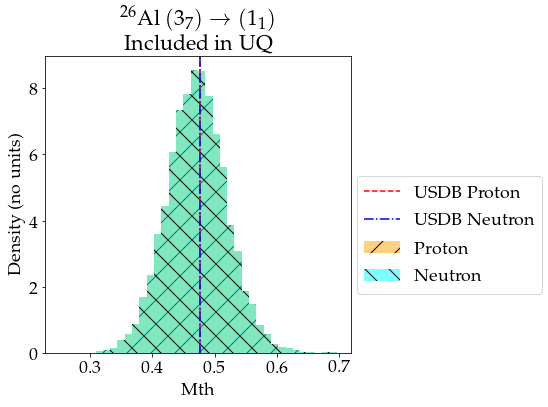

 59%|█████▉    | 111/188 [14:55<10:07,  7.89s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
135          145  26      Al  13  13       3962.83              0.05  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
135  37 FS 5        2904.92  ...         8.236093             1.372682   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
135     26Al  1      2   7   1     True  0.4769  0.4769  

[1 rows x 36 columns]
INDEX =  146
GlobalIndex                 146
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            3962.83
Energy Unc (keV)           0.05
Ji                            3
Thalf                   37 FS 5
E_gamma (keV)           2112.12
E_gamma Unc (keV)           0.0
I_gamma                     2.3
I_gamma Unc                 0.3
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv

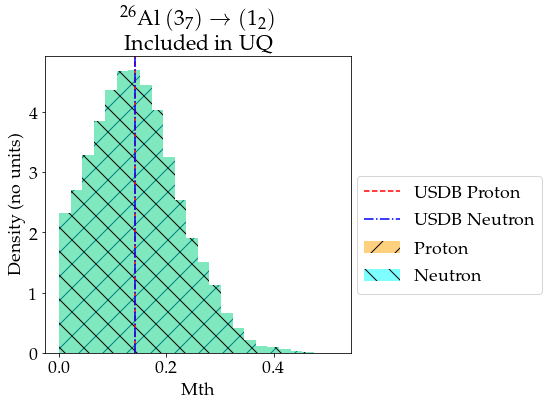

 60%|█████▉    | 112/188 [15:03<10:07,  8.00s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
136          146  26      Al  13  13       3962.83              0.05  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
136  37 FS 5        2112.12  ...         5.856777             1.143902   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
136     26Al  1      2   7   2     True -0.1412 -0.1412  

[1 rows x 36 columns]
INDEX =  147
GlobalIndex                  147
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             3962.83
Energy Unc (keV)            0.05
Ji                             3
Thalf                    37 FS 5
E_gamma (keV)            1222.77
E_gamma Unc (keV)            0.0
I_gamma                      0.7
I_gamma Unc                  0.3
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

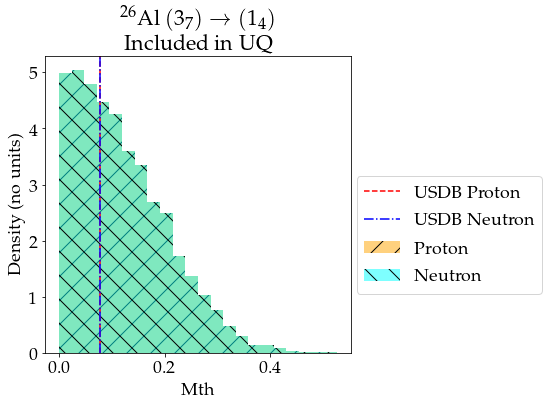

 60%|██████    | 113/188 [15:12<10:13,  8.18s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
137          147  26      Al  13  13       3962.83              0.05  3   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
137  37 FS 5        1222.77  ...        27.453644            13.726822   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
137     26Al  1      2   7   4     True -0.0775 -0.0775  

[1 rows x 36 columns]
INDEX =  149
GlobalIndex                 149
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            4205.86
Energy Unc (keV)           0.05
Ji                            4
Thalf                  62 FS 10
E_gamma (keV)            2446.7
E_gamma Unc (keV)           0.0
I_gamma                    1.67
I_gamma Unc                0.11
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv

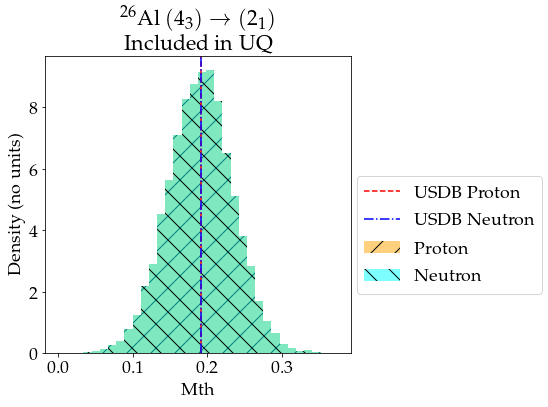

 61%|██████    | 114/188 [15:21<10:12,  8.28s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
139          149  26      Al  13  13       4205.86              0.05  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
139  62 FS 10         2446.7  ...         1.143902              0.22878   

     Nucleus Jf  twoJf  ni  nf  Include  Mth_p  Mth_n  
139     26Al  2      4   3   1     True  0.192  0.192  

[1 rows x 36 columns]
INDEX =  150
GlobalIndex                  150
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             4205.86
Energy Unc (keV)            0.05
Ji                             4
Thalf                   62 FS 10
E_gamma (keV)            1544.89
E_gamma Unc (keV)            0.0
I_gamma                     12.3
I_gamma Unc                  0.8
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef             

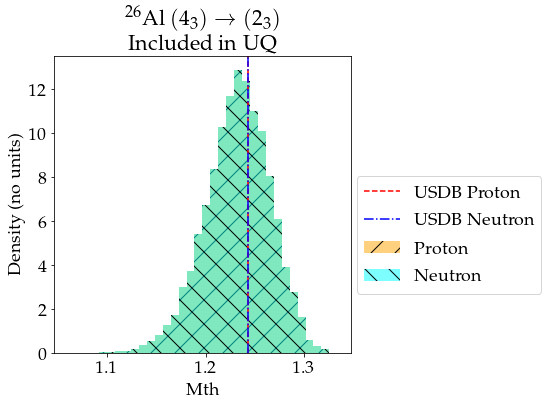

 61%|██████    | 115/188 [15:29<09:59,  8.21s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
140          150  26      Al  13  13       4205.86              0.05  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
140  62 FS 10        1544.89  ...        82.360933             18.30243   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
140     26Al  2      4   3   3     True -1.2427 -1.2427  

[1 rows x 36 columns]
INDEX =  151
GlobalIndex                  151
A                             26
Element                       Al
Z                             13
N                             13
Energy (keV)             4205.86
Energy Unc (keV)            0.05
Ji                             4
Thalf                   62 FS 10
E_gamma (keV)            1292.43
E_gamma Unc (keV)            0.0
I_gamma                     0.95
I_gamma Unc                 0.08
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef         

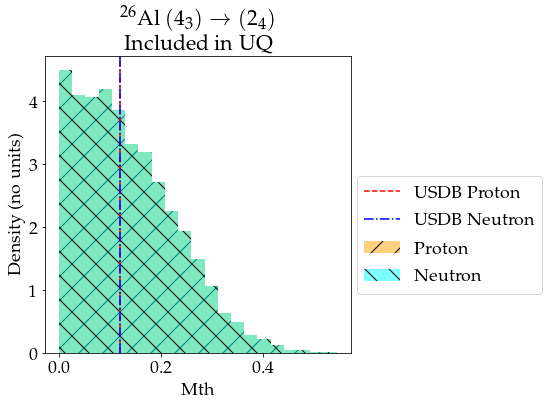

 62%|██████▏   | 116/188 [15:37<09:58,  8.31s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
141          151  26      Al  13  13       4205.86              0.05  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
141  62 FS 10        1292.43  ...        16.014626             3.202925   

     Nucleus Jf  twoJf  ni  nf  Include  Mth_p  Mth_n  
141     26Al  2      4   3   4     True  0.119  0.119  

[1 rows x 36 columns]
INDEX =  152
GlobalIndex                 152
A                            26
Element                      Al
Z                            13
N                            13
Energy (keV)            4349.34
Energy Unc (keV)           0.07
Ji                            3
Thalf                    9 FS 3
E_gamma (keV)           3291.38
E_gamma Unc (keV)           0.0
I_gamma                     1.9
I_gamma Unc                 0.2
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv C

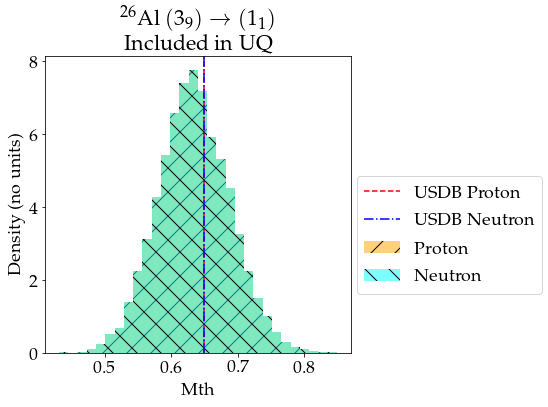

 62%|██████▏   | 117/188 [15:45<09:48,  8.28s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
142          152  26      Al  13  13       4349.34              0.07  3   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
142  9 FS 3        3291.38  ...         2.928389              1.05239   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
142     26Al  1      2   9   1     True  0.6488  0.6488  

[1 rows x 36 columns]
INDEX =  174
GlobalIndex                  174
A                             27
Element                       Al
Z                             13
N                             14
Energy (keV)              843.76
Energy Unc (keV)            0.09
Ji                           1/2
Thalf                    35 PS 1
E_gamma (keV)             843.76
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef             

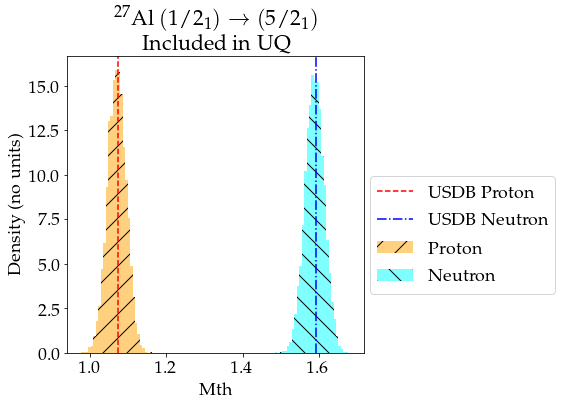

 63%|██████▎   | 118/188 [15:54<09:42,  8.32s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
144          174  27      Al  13  14        843.76              0.09  1/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
144  35 PS 1         843.76  ...        37.820319             1.106701   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
144     27Al  5/2      5   1   1     True -1.0727 -1.5943  

[1 rows x 36 columns]
INDEX =  175
GlobalIndex                  175
A                             27
Element                       Al
Z                             13
N                             14
Energy (keV)              3004.2
Energy Unc (keV)             0.8
Ji                           9/2
Thalf                    59 FS 3
E_gamma (keV)             3004.0
E_gamma Unc (keV)            0.9
I_gamma                    100.0
I_gamma Unc                  2.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

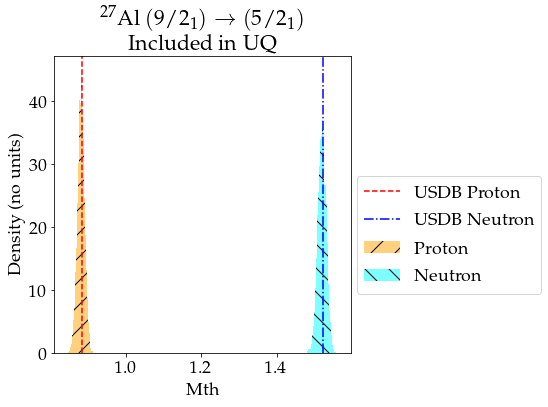

 63%|██████▎   | 119/188 [16:02<09:39,  8.40s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
145          175  27      Al  13  14        3004.2               0.8  9/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
145  59 FS 3         3004.0  ...        34.163392             1.924698   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
145     27Al  5/2      5   1   1     True -0.8822 -1.5238  

[1 rows x 36 columns]
INDEX =  176
GlobalIndex                  176
A                             27
Element                       Al
Z                             13
N                             14
Energy (keV)              4510.3
Energy Unc (keV)             0.5
Ji                          11/2
Thalf                  222 FS 14
E_gamma (keV)             2299.0
E_gamma Unc (keV)            0.8
I_gamma                    100.0
I_gamma Unc                  3.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

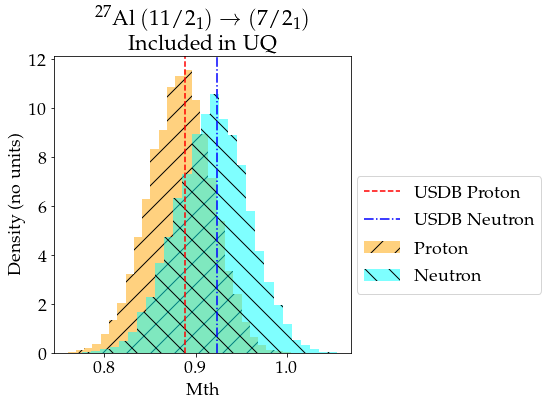

 64%|██████▍   | 120/188 [16:11<09:30,  8.39s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
146          176  27      Al  13  14        4510.3               0.5  11/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
146  222 FS 14         2299.0  ...        26.945774             3.368222   

     Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
146     27Al  7/2      7   1   1     True  0.888  0.9235  

[1 rows x 36 columns]
INDEX =  178
GlobalIndex                 178
A                            28
Element                      Al
Z                            13
N                            15
Energy (keV)             972.35
Energy Unc (keV)           0.03
Ji                            0
Thalf                   33 PS 2
E_gamma (keV)            941.79
E_gamma Unc (keV)          0.06
I_gamma                   100.0
I_gamma Unc                 0.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef               

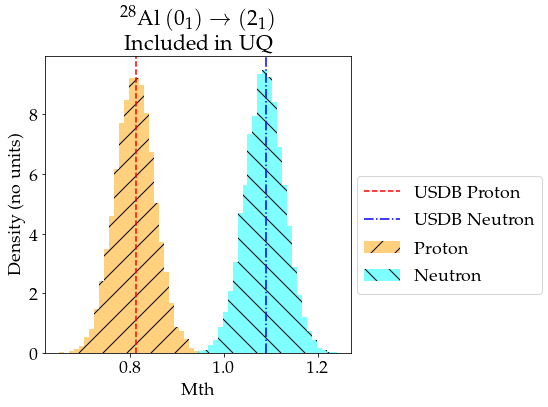

 64%|██████▍   | 121/188 [16:19<09:13,  8.27s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
147          178  28      Al  13  15        972.35              0.03  0   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
147  33 PS 2         941.79  ...         23.23376             1.515245   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
147     28Al  2      4   1   1     True -0.8132 -1.0888  

[1 rows x 36 columns]
INDEX =  179
GlobalIndex                  179
A                             28
Element                       Al
Z                             13
N                             15
Energy (keV)            1372.917
Energy Unc (keV)            0.02
Ji                             1
Thalf                  223 FS 35
E_gamma (keV)             1372.8
E_gamma Unc (keV)            0.2
I_gamma                     15.0
I_gamma Unc                  8.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

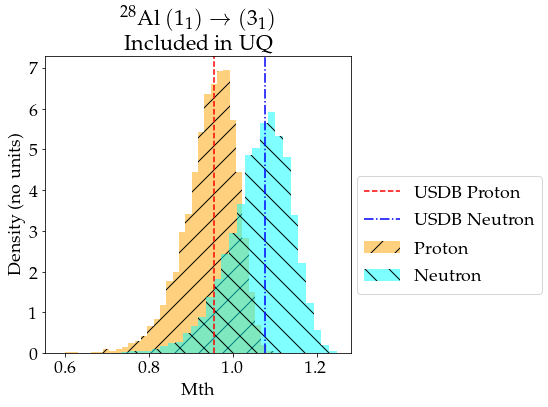

 65%|██████▍   | 122/188 [16:27<09:11,  8.35s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
148          179  28      Al  13  15      1372.917              0.02  1   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
148  223 FS 35         1372.8  ...        45.457356            25.254087   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
148     28Al  3      6   1   1     True  0.9564  1.0774  

[1 rows x 36 columns]
INDEX =  180
GlobalIndex                  180
A                             28
Element                       Al
Z                             13
N                             15
Energy (keV)             2581.81
Energy Unc (keV)            0.22
Ji                             5
Thalf                  313 FS 25
E_gamma (keV)             2582.2
E_gamma Unc (keV)            0.5
I_gamma                    100.0
I_gamma Unc                  2.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

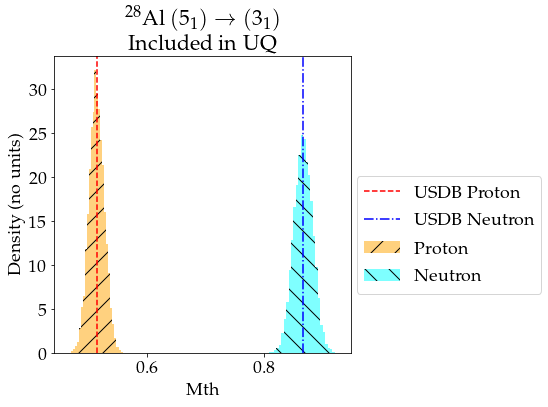

 65%|██████▌   | 123/188 [16:35<08:53,  8.21s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
149          180  28      Al  13  15       2581.81              0.22  5   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
149  313 FS 25         2582.2  ...         14.64737             1.515245   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
149     28Al  3      6   1   1     True  0.5146  0.8672  

[1 rows x 36 columns]
INDEX =  181
GlobalIndex                   181
A                              29
Element                        Al
Z                              13
N                              16
Energy (keV)              1398.05
Energy Unc (keV)             0.16
Ji                            1/2
Thalf                  4.5 PS 0.3
E_gamma (keV)              1398.0
E_gamma Unc (keV)             0.2
I_gamma                     100.0
I_gamma Unc                   0.0
Mult                         (E2)
Mult Ratio                    NaN
Mult Ratio Unc                NaN


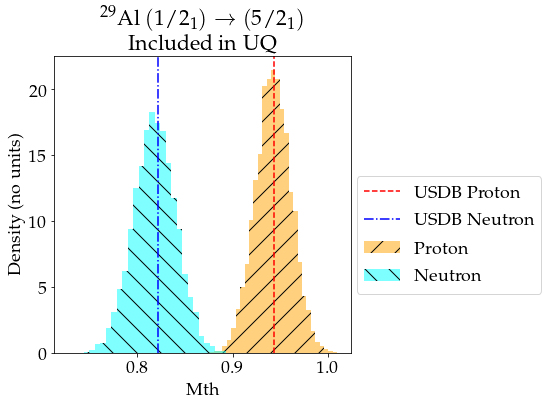

 66%|██████▌   | 124/188 [16:43<08:40,  8.14s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
150          181  29      Al  13  16       1398.05              0.16  1/2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
150  4.5 PS 0.3         1398.0  ...        23.288113             1.587826   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
150     29Al  5/2      5   1   1     True  0.9436  0.8223  

[1 rows x 36 columns]
INDEX =  182
GlobalIndex                  182
A                             26
Element                       Si
Z                             14
N                             12
Energy (keV)              1797.3
Energy Unc (keV)             0.1
Ji                             2
Thalf                  440 FS 40
E_gamma (keV)             1797.2
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv C

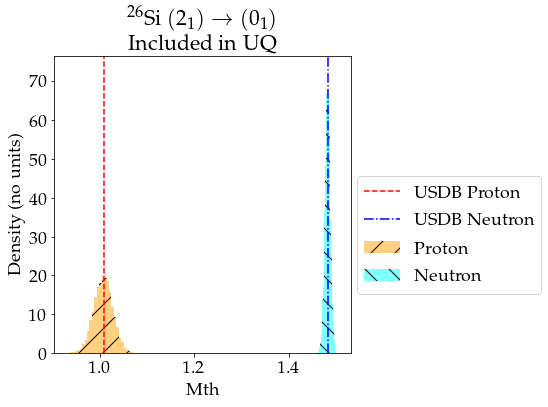

 66%|██████▋   | 125/188 [16:51<08:30,  8.10s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
151          182  26      Si  14  12        1797.3               0.1  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
151  440 FS 40         1797.2  ...        70.006793             6.863411   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
151     26Si  0      0   1   1     True -1.0093 -1.4828  

[1 rows x 36 columns]
INDEX =  183
GlobalIndex                  183
A                             26
Element                       Si
Z                             14
N                             12
Energy (keV)             2787.05
Energy Unc (keV)            0.13
Ji                             2
Thalf                  146 FS 35
E_gamma (keV)             2787.0
E_gamma Unc (keV)            0.2
I_gamma                     48.9
I_gamma Unc                  2.7
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

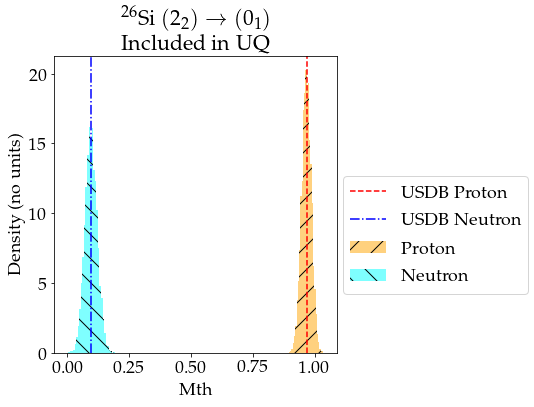

 67%|██████▋   | 126/188 [16:59<08:19,  8.06s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
152          183  26      Si  14  12       2787.05              0.13  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
152  146 FS 35         2787.0  ...         7.778533             1.830243   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
152     26Si  0      0   2   1     True -0.9687 -0.0962  

[1 rows x 36 columns]
INDEX =  184
GlobalIndex                     184
A                                26
Element                          Si
Z                                14
N                                12
Energy (keV)                3336.35
Energy Unc (keV)               0.22
Ji                                0
Thalf                  1.52 PS 0.48
E_gamma (keV)                1539.0
E_gamma Unc (keV)               0.2
I_gamma                       100.0
I_gamma Unc                    19.0
Mult                             E2
Mult Ratio                      NaN
Mult

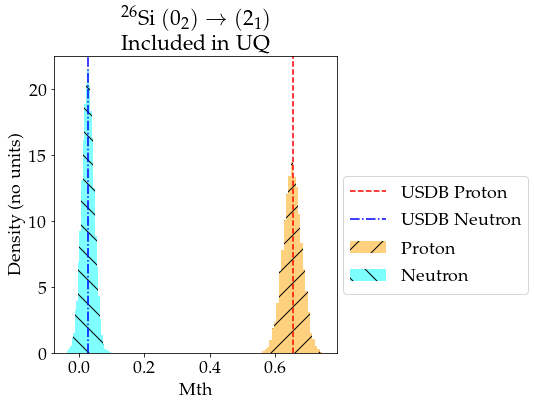

 68%|██████▊   | 127/188 [17:07<08:13,  8.09s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
153          184  26      Si  14  12       3336.35              0.22  0   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
153  1.52 PS 0.48         1539.0  ...        45.756074            22.878037   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
153     26Si  2      4   2   1     True  0.6559  0.0268  

[1 rows x 36 columns]
INDEX =  185
GlobalIndex                 185
A                            26
Element                      Si
Z                            14
N                            12
Energy (keV)            4139.06
Energy Unc (keV)            0.2
Ji                            2
Thalf                   35 FS 3
E_gamma (keV)            4141.0
E_gamma Unc (keV)           3.0
I_gamma                    11.8
I_gamma Unc                 5.9
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                 

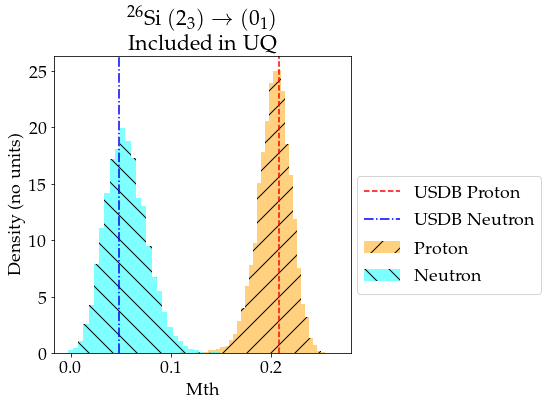

 68%|██████▊   | 128/188 [17:15<08:08,  8.15s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
154          185  26      Si  14  12       4139.06               0.2  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
154  35 FS 3         4141.0  ...          1.28117             0.686341   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
154     26Si  0      0   3   1     True -0.2075 -0.0487  

[1 rows x 36 columns]
INDEX =  186
GlobalIndex                  186
A                             27
Element                       Si
Z                             14
N                             13
Energy (keV)              2647.6
Energy Unc (keV)             0.3
Ji                           5/2
Thalf                    17 FS 2
E_gamma (keV)             1866.6
E_gamma Unc (keV)            0.0
I_gamma                      3.9
I_gamma Unc                  1.3
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

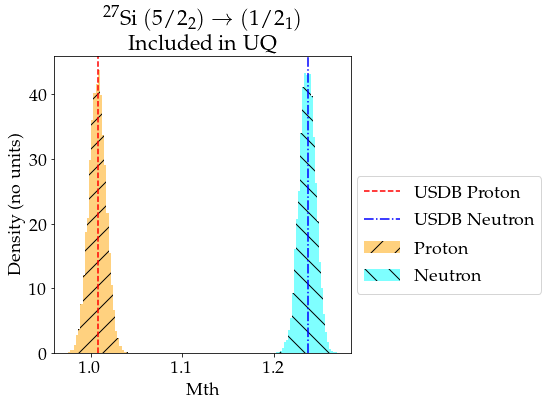

 69%|██████▊   | 129/188 [17:24<08:00,  8.14s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
155          186  27      Si  14  13        2647.6               0.3  5/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
155  17 FS 2         1866.6  ...        43.305709            14.435236   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
155     27Si  1/2      1   2   1     True -1.0085 -1.2372  

[1 rows x 36 columns]
INDEX =  187
GlobalIndex                  187
A                             27
Element                       Si
Z                             14
N                             13
Energy (keV)              4447.3
Energy Unc (keV)             0.5
Ji                          11/2
Thalf                  390 FS 40
E_gamma (keV)             2283.5
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  2.3
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

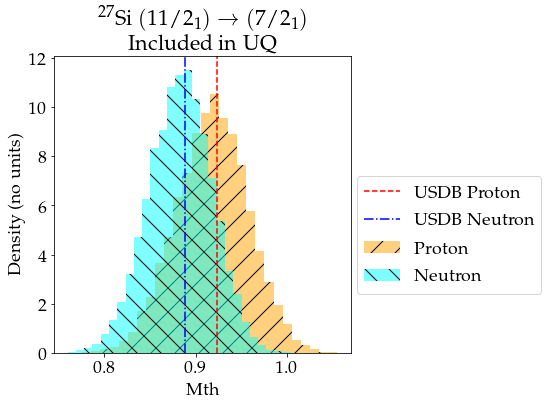

 69%|██████▉   | 130/188 [17:32<07:53,  8.17s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)    Ji  \
156          187  27      Si  14  13        4447.3               0.5  11/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
156  390 FS 40         2283.5  ...        20.209331             2.405873   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
156     27Si  7/2      7   1   1     True -0.9235 -0.888  

[1 rows x 36 columns]
INDEX =  188
GlobalIndex                  188
A                             28
Element                       Si
Z                             14
N                             14
Energy (keV)             1779.03
Energy Unc (keV)           0.011
Ji                             2
Thalf                  475 FS 17
E_gamma (keV)           1778.969
E_gamma Unc (keV)          0.011
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coe

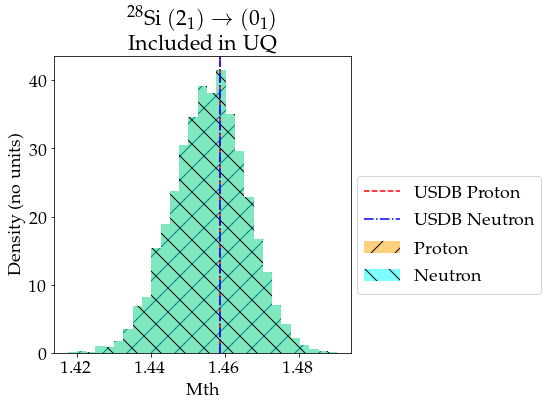

 70%|██████▉   | 131/188 [17:40<07:40,  8.09s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
157          188  28      Si  14  14       1779.03             0.011  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
157  475 FS 17       1778.969  ...        66.670789             2.525409   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
157     28Si  0      0   1   1     True -1.4587 -1.4587  

[1 rows x 36 columns]
INDEX =  189
GlobalIndex                  189
A                             28
Element                       Si
Z                             14
N                             14
Energy (keV)             4617.86
Energy Unc (keV)            0.04
Ji                             4
Thalf                    37 FS 4
E_gamma (keV)            2838.29
E_gamma Unc (keV)           0.15
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

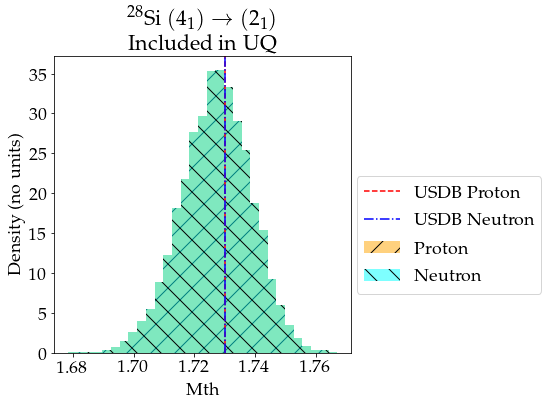

 70%|███████   | 132/188 [17:48<07:36,  8.16s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
158          189  28      Si  14  14       4617.86              0.04  4   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
158  37 FS 4        2838.29  ...        82.833404             9.091471   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
158     28Si  2      4   1   1     True  1.7302  1.7302  

[1 rows x 36 columns]
INDEX =  190
GlobalIndex                  190
A                             28
Element                       Si
Z                             14
N                             14
Energy (keV)             4979.92
Energy Unc (keV)            0.08
Ji                             0
Thalf                    35 FS 2
E_gamma (keV)             3200.7
E_gamma Unc (keV)            0.5
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

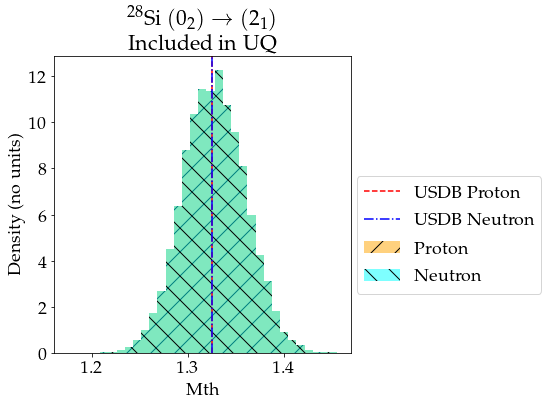

 71%|███████   | 133/188 [17:56<07:28,  8.16s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
159          190  28      Si  14  14       4979.92              0.08  0   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
159  35 FS 2         3200.7  ...        47.982765              3.03049   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
159     28Si  2      4   2   1     True  1.3248  1.3248  

[1 rows x 36 columns]
INDEX =  191
GlobalIndex                  191
A                             28
Element                       Si
Z                             14
N                             14
Energy (keV)             6690.74
Energy Unc (keV)            0.15
Ji                             0
Thalf                  147 FS 10
E_gamma (keV)             4910.8
E_gamma Unc (keV)            0.5
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

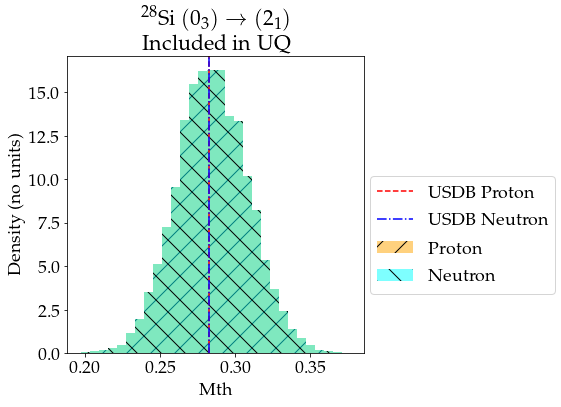

 71%|███████▏  | 134/188 [18:05<07:25,  8.24s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
160          191  28      Si  14  14       6690.74              0.15  0   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
160  147 FS 10         4910.8  ...         1.348568             0.095966   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
160     28Si  2      4   3   1     True -0.2823 -0.2823  

[1 rows x 36 columns]
INDEX =  192
GlobalIndex                 192
A                            28
Element                      Si
Z                            14
N                            14
Energy (keV)            7380.59
Energy Unc (keV)           0.09
Ji                            2
Thalf                    5 FS 2
E_gamma (keV)            2400.5
E_gamma Unc (keV)           0.0
I_gamma                    0.47
I_gamma Unc                0.16
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN


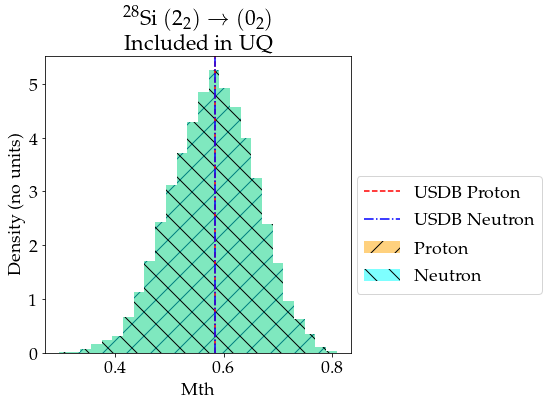

 72%|███████▏  | 135/188 [18:13<07:20,  8.30s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
161          192  28      Si  14  14       7380.59              0.09  2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
161  5 FS 2         2400.5  ...         4.040654             2.525409   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
161     28Si  0      0   2   2     True -0.5832 -0.5832  

[1 rows x 36 columns]
INDEX =  193
GlobalIndex                 193
A                            28
Element                      Si
Z                            14
N                            14
Energy (keV)            7933.45
Energy Unc (keV)            0.1
Ji                            2
Thalf                   11 FS 2
E_gamma (keV)            3315.2
E_gamma Unc (keV)           0.0
I_gamma                    5.65
I_gamma Unc                0.24
Mult                       (E2)
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv C

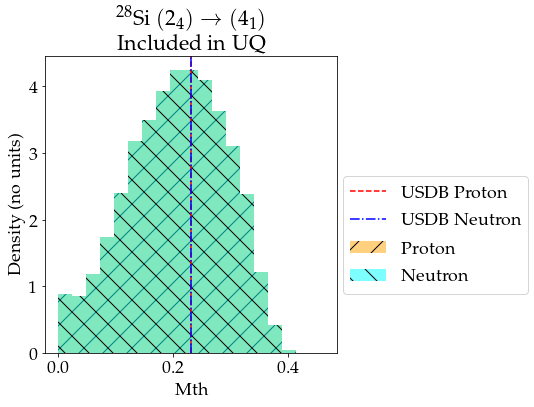

 72%|███████▏  | 136/188 [18:21<07:06,  8.21s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
162          193  28      Si  14  14       7933.45               0.1  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
162  11 FS 2         3315.2  ...         6.060981             1.161688   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
162     28Si  4      8   4   1     True -0.2312 -0.2312  

[1 rows x 36 columns]
INDEX =  194
GlobalIndex                 194
A                            28
Element                      Si
Z                            14
N                            14
Energy (keV)            7933.45
Energy Unc (keV)            0.1
Ji                            2
Thalf                   11 FS 2
E_gamma (keV)            2953.2
E_gamma Unc (keV)           0.0
I_gamma                    4.81
I_gamma Unc                0.24
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv

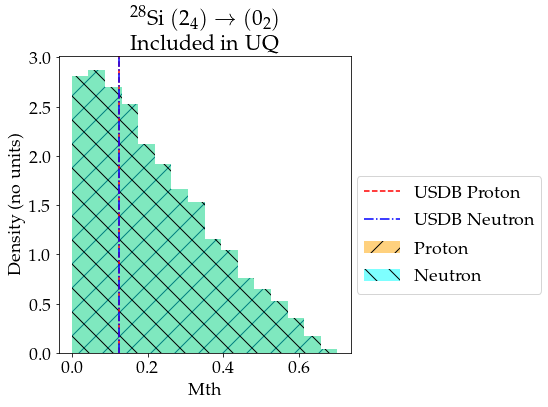

 73%|███████▎  | 137/188 [18:29<06:58,  8.21s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
163          194  28      Si  14  14       7933.45               0.1  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
163  11 FS 2         2953.2  ...         9.091471             2.020327   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
163     28Si  0      0   4   2     True -0.1254 -0.1254  

[1 rows x 36 columns]
INDEX =  195
GlobalIndex                  195
A                             28
Element                       Si
Z                             14
N                             14
Energy (keV)             8258.74
Energy Unc (keV)             0.1
Ji                             2
Thalf                    10 FS 2
E_gamma (keV)             3278.4
E_gamma Unc (keV)            0.0
I_gamma                     24.3
I_gamma Unc                  1.5
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

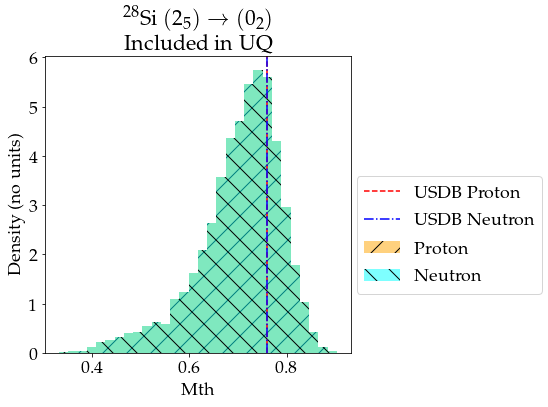

 73%|███████▎  | 138/188 [18:38<06:52,  8.25s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
164          195  28      Si  14  14       8258.74               0.1  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
164  10 FS 2         3278.4  ...        25.254087             5.555899   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
164     28Si  0      0   5   2     True -0.7592 -0.7592  

[1 rows x 36 columns]
INDEX =  196
GlobalIndex                 196
A                            28
Element                      Si
Z                            14
N                            14
Energy (keV)            8258.74
Energy Unc (keV)            0.1
Ji                            2
Thalf                   10 FS 2
E_gamma (keV)            3640.4
E_gamma Unc (keV)           0.0
I_gamma                     5.7
I_gamma Unc                 1.5
Mult                       (E2)
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv

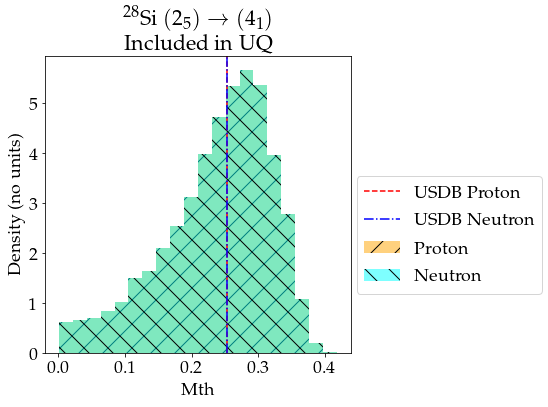

 74%|███████▍  | 139/188 [18:46<06:44,  8.25s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
165          196  28      Si  14  14       8258.74               0.1  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
165  10 FS 2         3640.4  ...         3.535572             1.212196   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
165     28Si  4      8   5   1     True -0.2532 -0.2532  

[1 rows x 36 columns]
INDEX =  197
GlobalIndex                  197
A                             28
Element                       Si
Z                             14
N                             14
Energy (keV)             8543.56
Energy Unc (keV)             0.2
Ji                             6
Thalf                  11.4 FS 1
E_gamma (keV)             3925.1
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

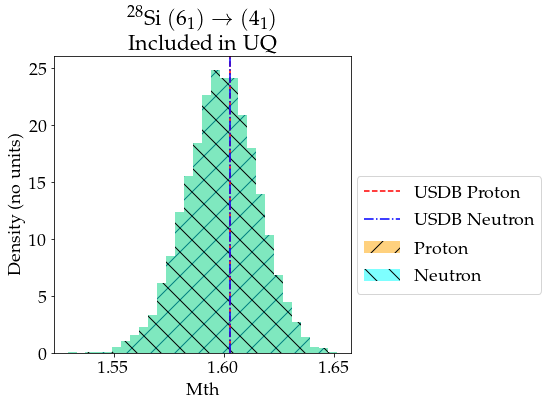

 74%|███████▍  | 140/188 [18:54<06:34,  8.22s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
166          197  28      Si  14  14       8543.56               0.2  6   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
166  11.4 FS 1         3925.1  ...        53.538664             5.050817   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
166     28Si  4      8   1   1     True -1.6025 -1.6025  

[1 rows x 36 columns]
INDEX =  211
GlobalIndex                  211
A                             29
Element                       Si
Z                             14
N                             15
Energy (keV)              4079.9
Energy Unc (keV)             0.3
Ji                           7/2
Thalf                   44 FS 12
E_gamma (keV)             2806.3
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  6.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

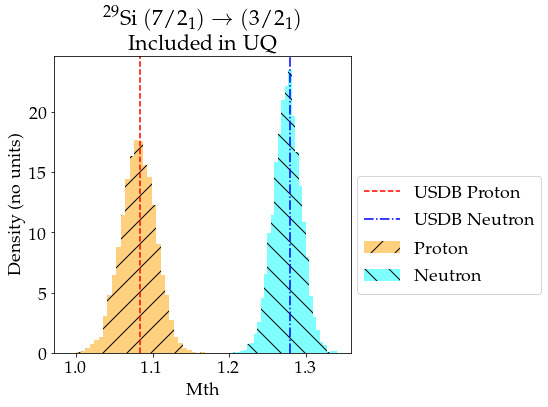

 75%|███████▌  | 141/188 [19:02<06:25,  8.20s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
167          211  29      Si  14  15        4079.9               0.3  7/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
167  44 FS 12         2806.3  ...        39.695647            11.644056   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
167     29Si  3/2      3   1   1     True  1.0841  1.2787  

[1 rows x 36 columns]
INDEX =  212
GlobalIndex                   212
A                              29
Element                        Si
Z                              14
N                              15
Energy (keV)               4741.1
Energy Unc (keV)              0.3
Ji                            9/2
Thalf                     36 FS 7
E_gamma (keV)              2712.8
E_gamma Unc (keV)             0.3
I_gamma                     100.0
I_gamma Unc                   1.1
Mult                         (E2)
Mult Ratio                    NaN
Mult Ratio Unc              

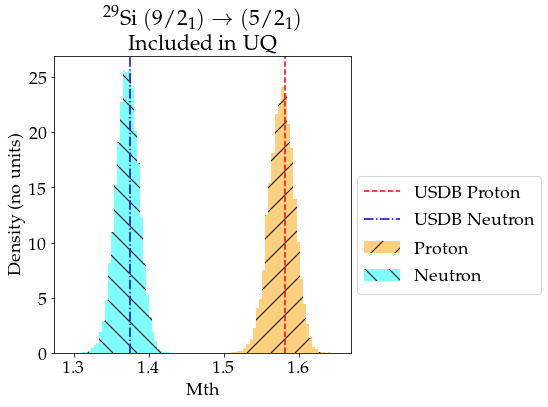

 76%|███████▌  | 142/188 [19:11<06:19,  8.25s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
168          212  29      Si  14  15        4741.1               0.3  9/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
168  36 FS 7         2712.8  ...       100.562305            21.171012   

     Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
168     29Si  5/2      5   1   1     True -1.581 -1.3748  

[1 rows x 36 columns]
INDEX =  213
GlobalIndex                 213
A                            29
Element                      Si
Z                            14
N                            15
Energy (keV)             4895.2
Energy Unc (keV)            0.4
Ji                          5/2
Thalf                   12 FS 5
E_gamma (keV)            4893.8
E_gamma Unc (keV)           1.2
I_gamma                    33.0
I_gamma Unc                 4.0
Mult                       (E2)
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   Na

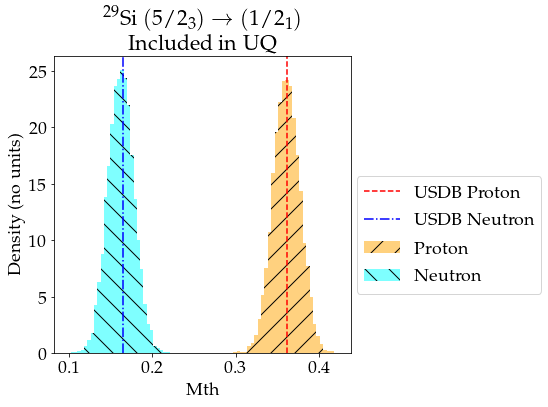

 76%|███████▌  | 143/188 [19:19<06:11,  8.25s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
169          213  29      Si  14  15        4895.2               0.4  5/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
169  12 FS 5         4893.8  ...         3.175652             1.587826   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
169     29Si  1/2      1   3   1     True  0.3614  0.1651  

[1 rows x 36 columns]
INDEX =  214
GlobalIndex                  214
A                             30
Element                       Si
Z                             14
N                             16
Energy (keV)            2235.322
Energy Unc (keV)           0.018
Ji                             2
Thalf                  215 FS 28
E_gamma (keV)            2235.23
E_gamma Unc (keV)           0.02
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

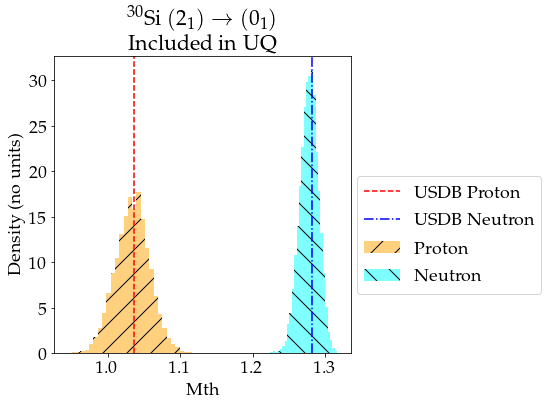

 77%|███████▋  | 144/188 [19:28<06:09,  8.39s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
170          214  30      Si  14  16      2235.322             0.018  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
170  215 FS 28        2235.23  ...        47.068629             6.091234   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
170     30Si  0      0   1   1     True  1.0358  1.2827  

[1 rows x 36 columns]
INDEX =  215
GlobalIndex                 215
A                            30
Element                      Si
Z                            14
N                            16
Energy (keV)            3498.49
Energy Unc (keV)           0.03
Ji                            2
Thalf                  58 FS 17
E_gamma (keV)           3498.33
E_gamma Unc (keV)          0.05
I_gamma                    98.0
I_gamma Unc                 3.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef              0.000994


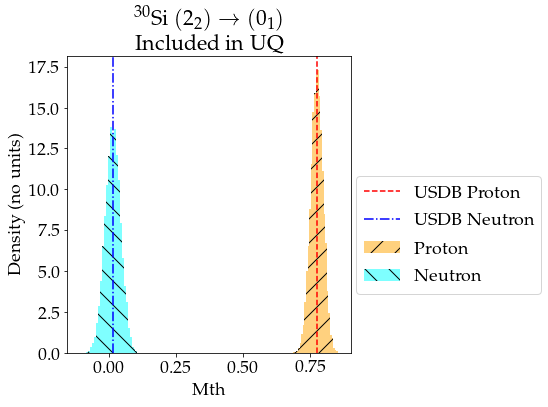

 77%|███████▋  | 145/188 [19:36<06:02,  8.42s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
171          215  30      Si  14  16       3498.49              0.03  2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
171  58 FS 17        3498.33  ...         9.413726             2.768743   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
171     30Si  0      0   2   1     True  0.7765  0.0166  

[1 rows x 36 columns]
INDEX =  216
GlobalIndex                  216
A                             30
Element                       Si
Z                             14
N                             16
Energy (keV)             4810.31
Energy Unc (keV)            0.11
Ji                             2
Thalf                  104 FS 15
E_gamma (keV)             4810.0
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  7.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef         

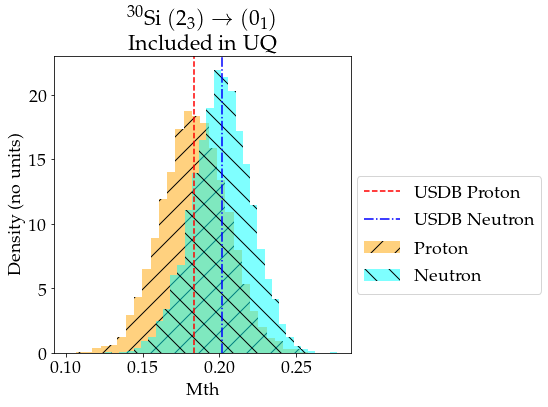

 78%|███████▊  | 146/188 [19:44<05:47,  8.27s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
172          216  30      Si  14  16       4810.31              0.11  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
172  104 FS 15         4810.0  ...         0.941373             0.166125   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
172     30Si  0      0   3   1     True -0.1837 -0.2015  

[1 rows x 36 columns]
INDEX =  217
GlobalIndex                  217
A                             30
Element                       Si
Z                             14
N                             16
Energy (keV)             5279.37
Energy Unc (keV)            0.14
Ji                             4
Thalf                   83 FS 22
E_gamma (keV)             3043.2
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  0.3
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

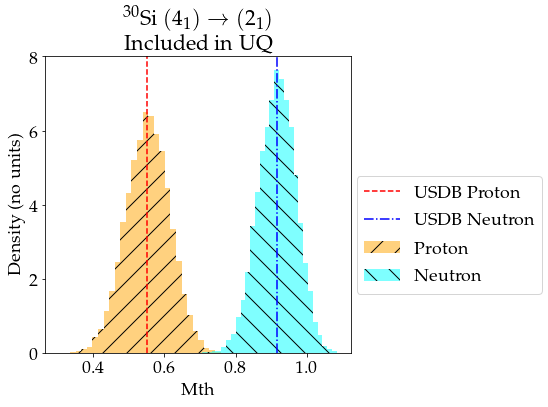

 78%|███████▊  | 147/188 [19:52<05:39,  8.28s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
173          217  30      Si  14  16       5279.37              0.14  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
173  83 FS 22         3043.2  ...        26.026183             7.198732   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
173     30Si  2      4   1   1     True  0.5512  0.916  

[1 rows x 36 columns]
INDEX =  218
GlobalIndex                  218
A                             30
Element                       Si
Z                             14
N                             16
Energy (keV)              5372.2
Energy Unc (keV)             0.6
Ji                             0
Thalf                   59 FS 21
E_gamma (keV)             3136.6
E_gamma Unc (keV)            0.7
I_gamma                    100.0
I_gamma Unc                 27.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

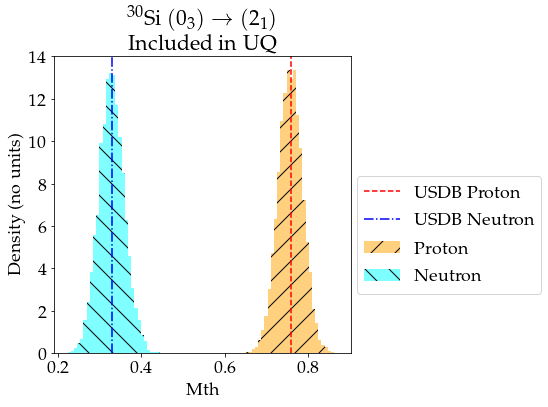

 79%|███████▊  | 148/188 [20:00<05:29,  8.25s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
174          218  30      Si  14  16        5372.2               0.6  0   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
174  59 FS 21         3136.6  ...        18.827452             9.413726   

     Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
174     30Si  2      4   3   1     True -0.758 -0.3305  

[1 rows x 36 columns]
INDEX =  219
GlobalIndex                  219
A                             30
Element                       Si
Z                             14
N                             16
Energy (keV)             5950.73
Energy Unc (keV)            0.15
Ji                             4
Thalf                    15 FS 8
E_gamma (keV)             3714.9
E_gamma Unc (keV)            0.2
I_gamma                    100.0
I_gamma Unc                  3.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef           

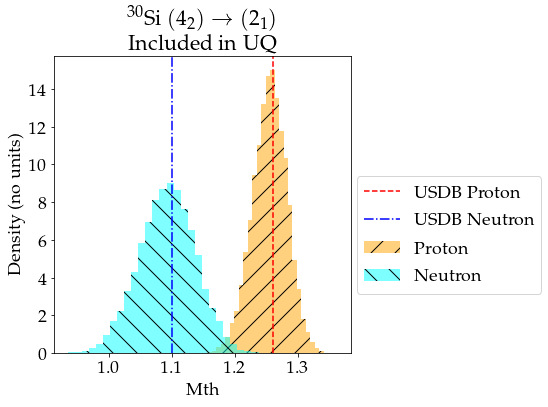

 79%|███████▉  | 149/188 [20:09<05:21,  8.23s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
175          219  30      Si  14  16       5950.73              0.15  4   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
175  15 FS 8         3714.9  ...        49.837372            27.687429   

     Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
175     30Si  2      4   2   1     True  -1.26 -1.1003  

[1 rows x 36 columns]
INDEX =  220
GlobalIndex                  220
A                             30
Element                       Si
Z                             14
N                             16
Energy (keV)             5950.73
Energy Unc (keV)            0.15
Ji                             4
Thalf                    15 FS 8
E_gamma (keV)             2452.6
E_gamma Unc (keV)            1.3
I_gamma                      5.0
I_gamma Unc                  3.0
Mult                        (E2)
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef             

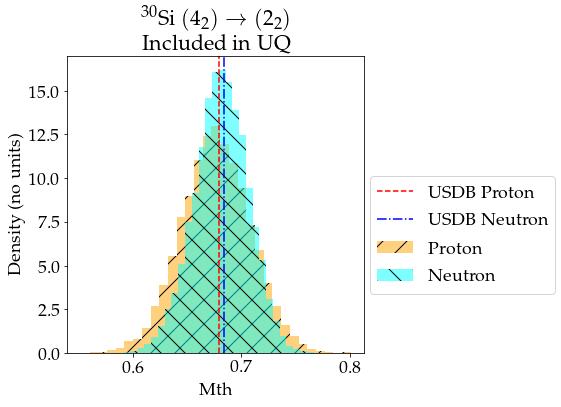

 80%|███████▉  | 150/188 [20:17<05:15,  8.30s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
176          220  30      Si  14  16       5950.73              0.15  4   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
176  15 FS 8         2452.6  ...        22.149943            16.612457   

     Nucleus Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
176     30Si  2      4   2   2     True -0.679 -0.6844  

[1 rows x 36 columns]
INDEX =  221
GlobalIndex                     221
A                                32
Element                          Si
Z                                14
N                                18
Energy (keV)                 1941.4
Energy Unc (keV)                0.3
Ji                                2
Thalf                  0.78 PS 0.22
E_gamma (keV)                1941.4
E_gamma Unc (keV)               0.3
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                             E2
Mult Ratio                      NaN
Mult Ratio

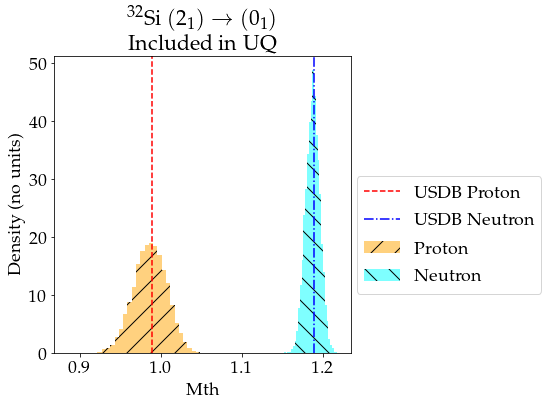

 80%|████████  | 151/188 [20:25<05:04,  8.22s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
177          221  32      Si  14  18        1941.4               0.3  2   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
177  0.78 PS 0.22         1941.4  ...        26.554427             7.845626   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
177     32Si  0      0   1   1     True  0.9891  1.1888  

[1 rows x 36 columns]
INDEX =  222
GlobalIndex                     222
A                                32
Element                          Si
Z                                14
N                                18
Energy (keV)                 4230.8
Energy Unc (keV)                0.8
Ji                                2
Thalf                  0.26 PS 0.09
E_gamma (keV)                4230.0
E_gamma Unc (keV)               1.5
I_gamma                       100.0
I_gamma Unc                     5.0
Mult                           [E2]
Mult Ratio                      Na

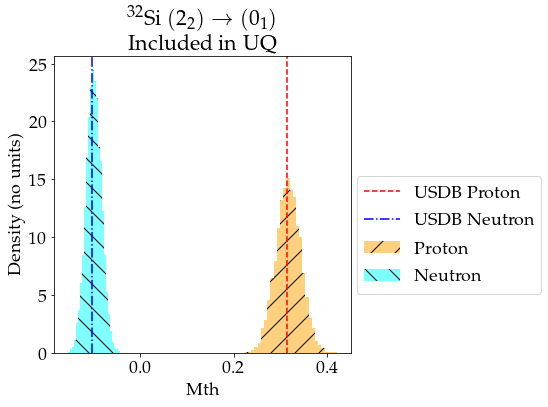

 81%|████████  | 152/188 [20:33<04:54,  8.19s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
178          222  32      Si  14  18        4230.8               0.8  2   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
178  0.26 PS 0.09         4230.0  ...         1.025966             0.362106   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
178     32Si  0      0   2   1     True -0.3143  0.1019  

[1 rows x 36 columns]
INDEX =  224
GlobalIndex                  224
A                             31
Element                        P
Z                             15
N                             16
Energy (keV)              2233.6
Energy Unc (keV)             0.1
Ji                           5/2
Thalf                  269 FS 18
E_gamma (keV)             2233.6
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

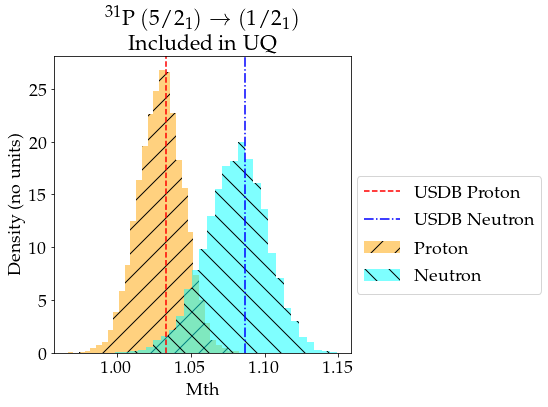

 81%|████████▏ | 153/188 [20:42<04:48,  8.25s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
180          224  31       P  15  16        2233.6               0.1  5/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
180  269 FS 18         2233.6  ...        37.023703             2.892477   

     Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
180      31P  1/2      1   1   1     True  1.033  1.0869  

[1 rows x 36 columns]
INDEX =  226
GlobalIndex                  226
A                             31
Element                        P
Z                             15
N                             16
Energy (keV)              3414.6
Energy Unc (keV)             0.3
Ji                           7/2
Thalf                  219 FS 17
E_gamma (keV)             2148.4
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  0.6
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

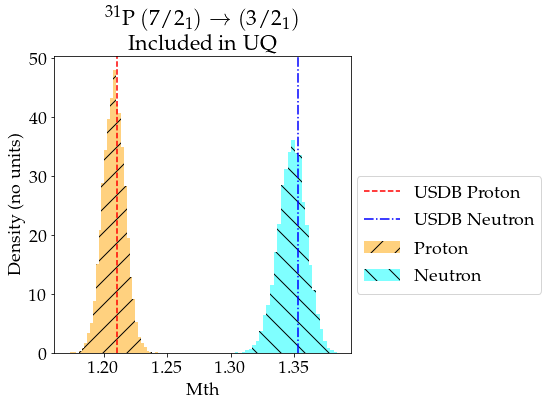

 82%|████████▏ | 154/188 [20:50<04:39,  8.23s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
182          226  31       P  15  16        3414.6               0.3  7/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
182  219 FS 17         2148.4  ...        54.957059             4.627963   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
182      31P  3/2      3   1   1     True  1.2105  1.3526  

[1 rows x 36 columns]
INDEX =  227
GlobalIndex                 227
A                            31
Element                       P
Z                            15
N                            16
Energy (keV)             4634.2
Energy Unc (keV)            0.8
Ji                          7/2
Thalf                  68 FS 10
E_gamma (keV)            3367.6
E_gamma Unc (keV)           0.7
I_gamma                     9.0
I_gamma Unc                 3.0
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef               

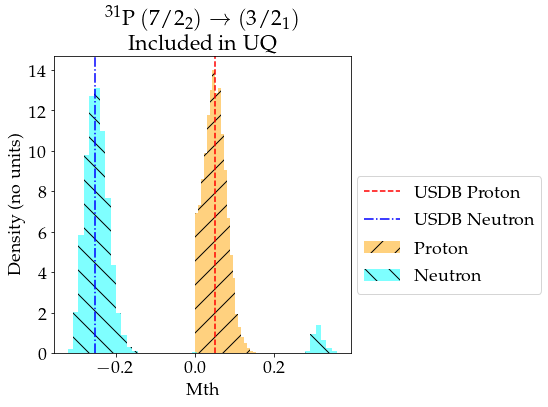

 82%|████████▏ | 155/188 [20:58<04:31,  8.22s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
183          227  31       P  15  16        4634.2               0.8  7/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
183  68 FS 10         3367.6  ...         0.578495             0.231398   

     Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
183      31P  3/2      3   2   1     True  0.049 -0.2522  

[1 rows x 36 columns]
INDEX =  228
GlobalIndex                   228
A                              31
Element                         P
Z                              15
N                              16
Energy (keV)               4783.4
Energy Unc (keV)              1.1
Ji                            5/2
Thalf                  6.9 FS 2.8
E_gamma (keV)              4783.4
E_gamma Unc (keV)             0.0
I_gamma                     100.0
I_gamma Unc                   4.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                

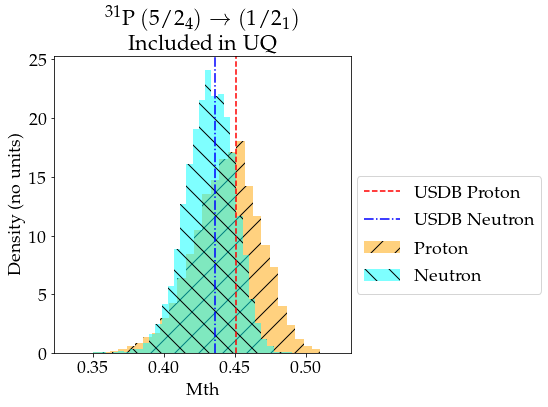

 83%|████████▎ | 156/188 [21:06<04:20,  8.15s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
184          228  31       P  15  16        4783.4               1.1  5/2   

          Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
184  6.9 FS 2.8         4783.4  ...        13.883889             5.784954   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
184      31P  1/2      1   4   1     True  0.4511  0.4362  

[1 rows x 36 columns]
INDEX =  229
GlobalIndex                 229
A                            31
Element                       P
Z                            15
N                            16
Energy (keV)             5342.9
Energy Unc (keV)            1.5
Ji                          9/2
Thalf                   36 FS 8
E_gamma (keV)            3109.4
E_gamma Unc (keV)           0.6
I_gamma                    19.0
I_gamma Unc                 2.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef             

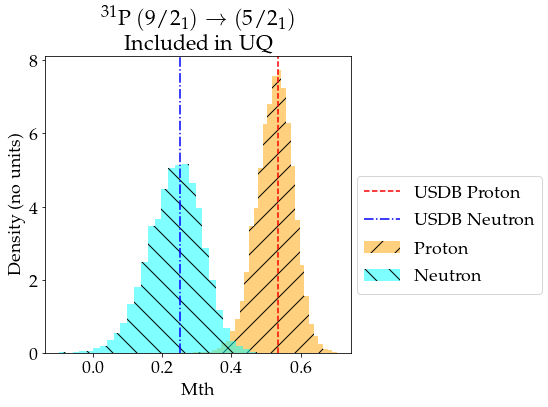

 84%|████████▎ | 157/188 [21:14<04:12,  8.15s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
185          229  31       P  15  16        5342.9               1.5  9/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
185  36 FS 8         3109.4  ...         8.098935             2.313981   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
185      31P  5/2      5   1   1     True -0.5345 -0.2525  

[1 rows x 36 columns]
INDEX =  230
GlobalIndex                  230
A                             31
Element                        P
Z                             15
N                             16
Energy (keV)              5342.9
Energy Unc (keV)             1.5
Ji                           9/2
Thalf                    36 FS 8
E_gamma (keV)             2048.3
E_gamma Unc (keV)            0.4
I_gamma                      4.9
I_gamma Unc                  1.3
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

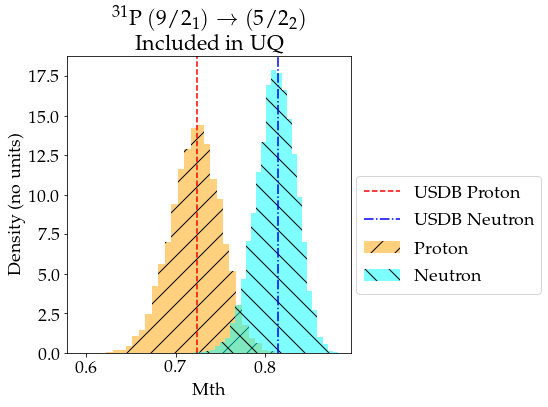

 84%|████████▍ | 158/188 [21:22<04:05,  8.17s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
186          230  31       P  15  16        5342.9               1.5  9/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
186  36 FS 8         2048.3  ...        16.776365             5.784954   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
186      31P  5/2      5   1   2     True -0.7241 -0.8147  

[1 rows x 36 columns]
INDEX =  231
GlobalIndex                 231
A                            31
Element                       P
Z                            15
N                            16
Energy (keV)             5773.5
Energy Unc (keV)            1.6
Ji                          7/2
Thalf                   22 FS 7
E_gamma (keV)            4507.0
E_gamma Unc (keV)           0.0
I_gamma                    57.0
I_gamma Unc                14.0
Mult                       [E2]
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   

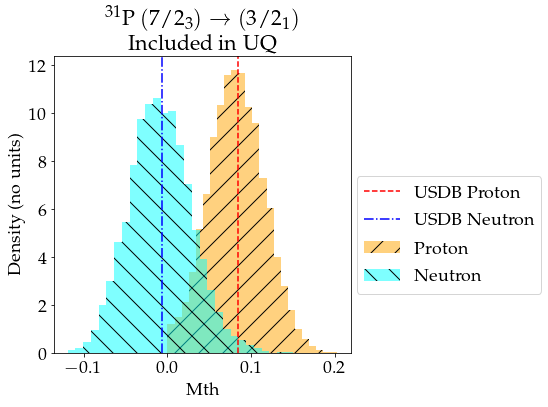

 85%|████████▍ | 159/188 [21:31<03:58,  8.21s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
187          231  31       P  15  16        5773.5               1.6  7/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
187  22 FS 7         4507.0  ...          2.48753             1.041292   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
187      31P  3/2      3   3   1     True -0.0839  0.0059  

[1 rows x 36 columns]
INDEX =  232
GlobalIndex                  232
A                             31
Element                        P
Z                             15
N                             16
Energy (keV)              5891.9
Energy Unc (keV)             2.0
Ji                           9/2
Thalf                    23 FS 6
E_gamma (keV)             3658.2
E_gamma Unc (keV)            0.5
I_gamma                    100.0
I_gamma Unc                  3.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

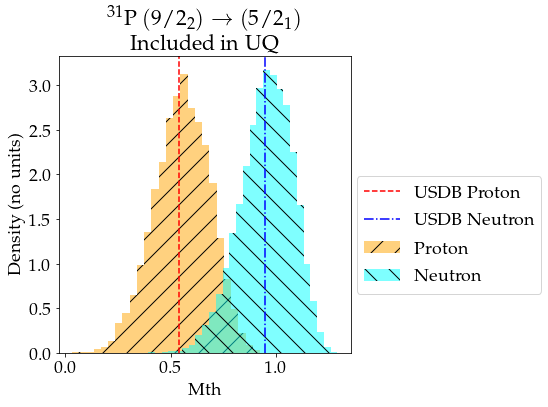

 85%|████████▌ | 160/188 [21:39<03:49,  8.20s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
188          232  31       P  15  16        5891.9               2.0  9/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
188  23 FS 6         3658.2  ...        31.238749              8.67743   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
188      31P  5/2      5   2   1     True -0.5382 -0.9445  

[1 rows x 36 columns]
INDEX =  233
GlobalIndex                  233
A                             31
Element                        P
Z                             15
N                             16
Energy (keV)              6078.1
Energy Unc (keV)             1.8
Ji                           9/2
Thalf                   22 FS 10
E_gamma (keV)             3844.6
E_gamma Unc (keV)            0.1
I_gamma                    100.0
I_gamma Unc                  9.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

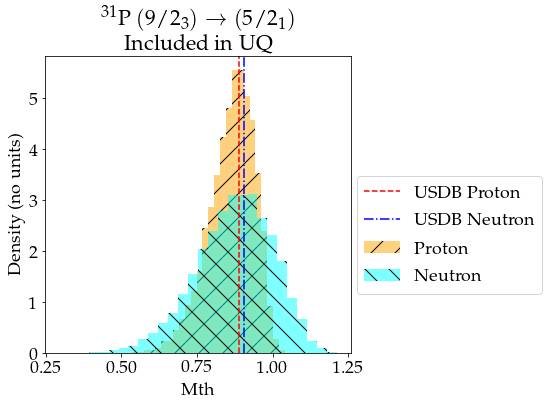

 86%|████████▌ | 161/188 [21:47<03:41,  8.20s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
189          233  31       P  15  16        6078.1               1.8  9/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
189  22 FS 10         3844.6  ...        19.090347             9.255926   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
189      31P  5/2      5   3   1     True -0.8879 -0.9051  

[1 rows x 36 columns]
INDEX =  238
GlobalIndex                  238
A                             33
Element                        P
Z                             15
N                             18
Energy (keV)              4193.4
Energy Unc (keV)             1.2
Ji                           5/2
Thalf                  104 FS 35
E_gamma (keV)             4193.5
E_gamma Unc (keV)            2.5
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

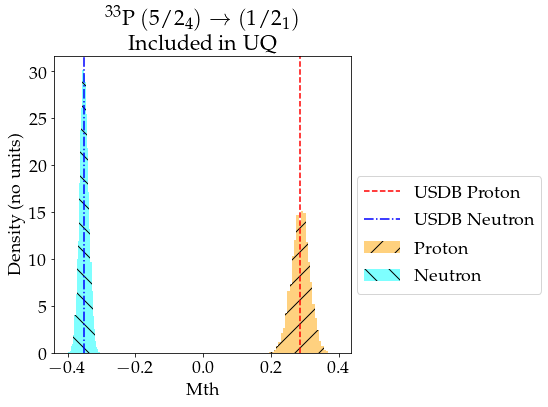

 86%|████████▌ | 162/188 [21:55<03:31,  8.15s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
191          238  33       P  15  18        4193.4               1.2  5/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
191  104 FS 35         4193.5  ...          4.02423             1.383329   

     Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
191      33P  1/2      1   4   1     True -0.287  0.3502  

[1 rows x 36 columns]
INDEX =  239
GlobalIndex                  239
A                             31
Element                        S
Z                             16
N                             15
Energy (keV)             2234.29
Energy Unc (keV)            0.14
Ji                           5/2
Thalf                  222 FS 55
E_gamma (keV)             2234.2
E_gamma Unc (keV)            0.2
I_gamma                    100.0
I_gamma Unc                  1.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

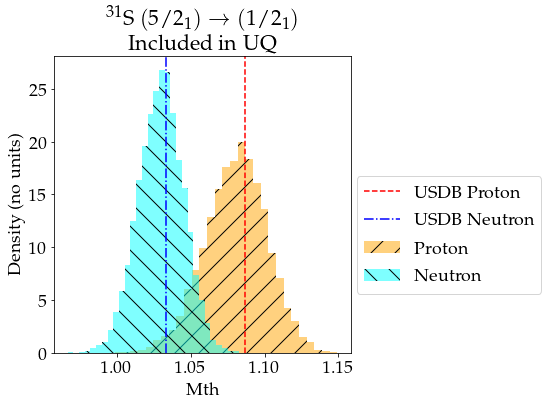

 87%|████████▋ | 163/188 [22:03<03:23,  8.15s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
192          239  31       S  16  15       2234.29              0.14  5/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
192  222 FS 55         2234.2  ...        45.122638            12.726898   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
192      31S  1/2      1   1   1     True  1.0869  1.033  

[1 rows x 36 columns]
INDEX =  240
GlobalIndex                     240
A                                32
Element                           S
Z                                16
N                                16
Energy (keV)                 3778.4
Energy Unc (keV)                1.0
Ji                                0
Thalf                  0.89 PS 0.09
E_gamma (keV)                1548.8
E_gamma Unc (keV)               1.5
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                           [E2]
Mult Ratio                      Na

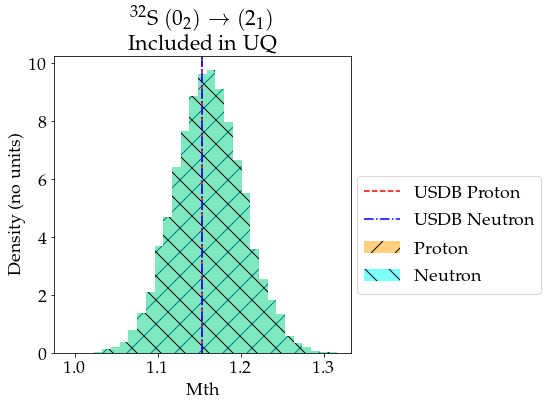

 87%|████████▋ | 164/188 [22:11<03:16,  8.17s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
193          240  32       S  16  16        3778.4               1.0  0   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
193  0.89 PS 0.09         1548.8  ...        71.214145             7.242116   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
193      32S  2      4   2   1     True  1.1536  1.1536  

[1 rows x 36 columns]
INDEX =  241
GlobalIndex                  241
A                             32
Element                        S
Z                             16
N                             16
Energy (keV)              4459.1
Energy Unc (keV)             0.8
Ji                             4
Thalf                  124 FS 27
E_gamma (keV)             2229.4
E_gamma Unc (keV)            1.2
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

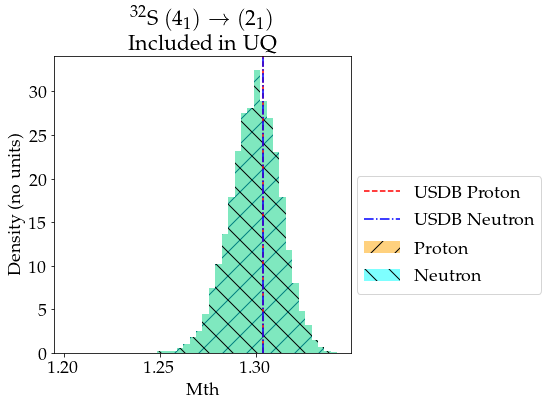

 88%|████████▊ | 165/188 [22:20<03:10,  8.27s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
194          241  32       S  16  16        4459.1               0.8  4   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
194  124 FS 27         2229.4  ...        84.491359            18.105291   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
194      32S  2      4   1   1     True -1.3039 -1.3039  

[1 rows x 36 columns]
INDEX =  242
GlobalIndex                  242
A                             32
Element                        S
Z                             16
N                             16
Energy (keV)              6851.5
Energy Unc (keV)             1.5
Ji                             4
Thalf                   66 FS 17
E_gamma (keV)             2570.8
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                 13.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

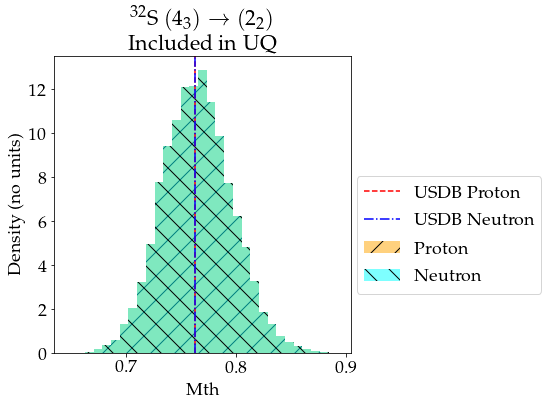

 88%|████████▊ | 166/188 [22:28<03:00,  8.21s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
195          242  32       S  16  16        6851.5               1.5  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
195  66 FS 17         2570.8  ...        48.280776            18.105291   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
195      32S  2      4   3   2     True -0.7628 -0.7628  

[1 rows x 36 columns]
INDEX =  243
GlobalIndex                   243
A                              33
Element                         S
Z                              16
N                              17
Energy (keV)              1967.19
Energy Unc (keV)             0.03
Ji                            5/2
Thalf                    94 FS 14
E_gamma (keV)              1126.0
E_gamma Unc (keV)             0.6
I_gamma                       7.5
I_gamma Unc                   1.1
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                NaN
Co

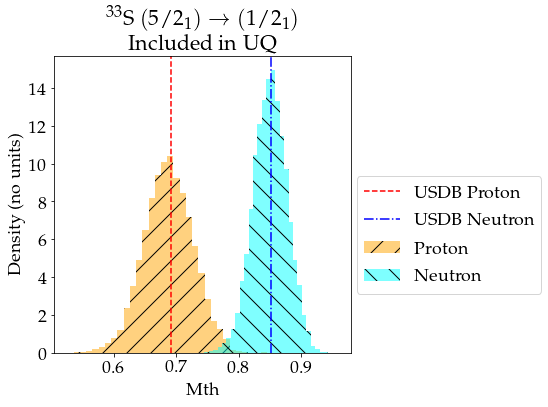

 89%|████████▉ | 167/188 [22:36<02:50,  8.10s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
196          243  33       S  16  17       1967.19              0.03  5/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
196  94 FS 14         1126.0  ...       232.650826            50.302881   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
196      33S  1/2      1   1   1     True -0.6913 -0.852  

[1 rows x 36 columns]
INDEX =  244
GlobalIndex                    244
A                               33
Element                          S
Z                               16
N                               17
Energy (keV)              2867.626
Energy Unc (keV)              0.02
Ji                             5/2
Thalf                  10.8 FS 3.5
E_gamma (keV)               2026.6
E_gamma Unc (keV)              0.0
I_gamma                        1.5
I_gamma Unc                    0.2
Mult                            E2
Mult Ratio                     NaN
Mult Ratio Unc 

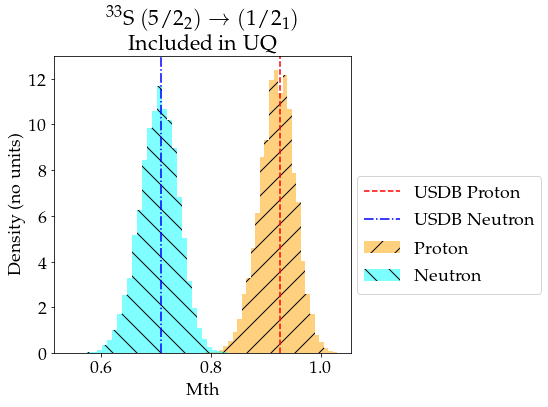

 89%|████████▉ | 168/188 [22:44<02:44,  8.21s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
197          244  33       S  16  17      2867.626              0.02  5/2   

           Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
197  10.8 FS 3.5         2026.6  ...        22.636297             8.174218   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
197      33S  1/2      1   2   1     True  0.9258  0.7094  

[1 rows x 36 columns]
INDEX =  246
GlobalIndex                  246
A                             34
Element                        S
Z                             16
N                             18
Energy (keV)            2127.564
Energy Unc (keV)           0.013
Ji                             2
Thalf                   318 FS 8
E_gamma (keV)           2127.499
E_gamma Unc (keV)           0.02
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv

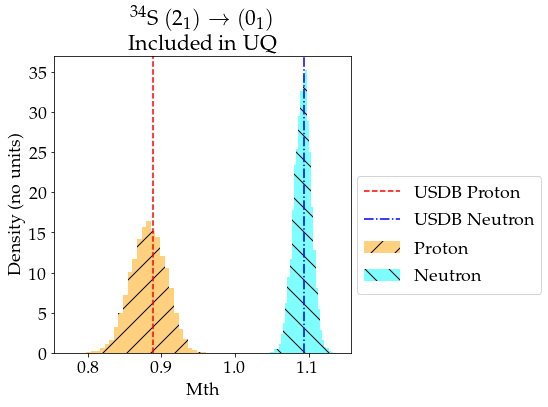

 90%|████████▉ | 169/188 [22:53<02:36,  8.26s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
199          246  34       S  16  18      2127.564             0.013  2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
199  318 FS 8       2127.499  ...        40.829504              1.04691   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
199      34S  0      0   1   1     True -0.8888 -1.0931  

[1 rows x 36 columns]
INDEX =  247
GlobalIndex                 247
A                            34
Element                       S
Z                            16
N                            18
Energy (keV)           3304.212
Energy Unc (keV)          0.013
Ji                            2
Thalf                  136 FS 7
E_gamma (keV)          3304.031
E_gamma Unc (keV)          0.02
I_gamma                    87.2
I_gamma Unc                 0.9
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Co

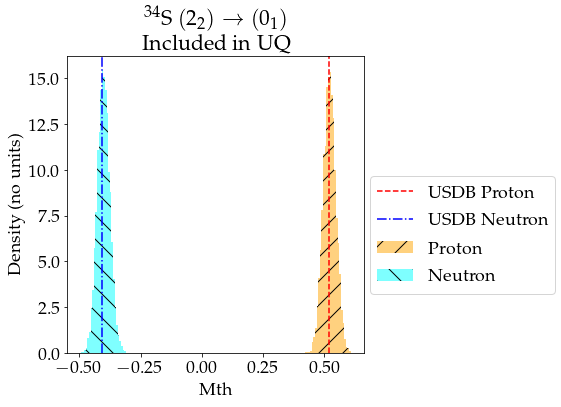

 90%|█████████ | 170/188 [23:01<02:30,  8.34s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
200          247  34       S  16  18      3304.212             0.013  2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
200  136 FS 7       3304.031  ...         4.907392             0.261728   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
200      34S  0      0   2   1     True -0.5177  0.4066  

[1 rows x 36 columns]
INDEX =  248
GlobalIndex                     248
A                                34
Element                           S
Z                                16
N                                18
Energy (keV)               3916.408
Energy Unc (keV)              0.021
Ji                                0
Thalf                  1.12 PS 0.09
E_gamma (keV)              1788.794
E_gamma Unc (keV)              0.02
I_gamma                       100.0
I_gamma Unc                    10.0
Mult                             E2
Mult Ratio                      NaN
Mult R

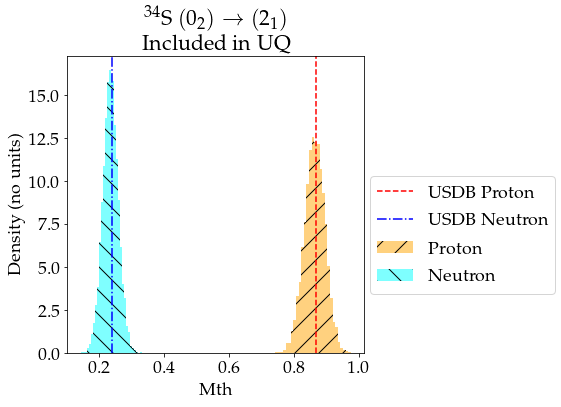

 91%|█████████ | 171/188 [23:09<02:20,  8.27s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
201          248  34       S  16  18      3916.408             0.021  0   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
201  1.12 PS 0.09       1788.794  ...        27.481397             4.580233   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
201      34S  2      4   2   1     True  0.8682  0.2393  

[1 rows x 36 columns]
INDEX =  249
GlobalIndex                 249
A                            34
Element                       S
Z                            16
N                            18
Energy (keV)           4114.813
Energy Unc (keV)          0.023
Ji                            2
Thalf                   73 FS 6
E_gamma (keV)           4114.52
E_gamma Unc (keV)          0.04
I_gamma                   100.0
I_gamma Unc                10.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                 

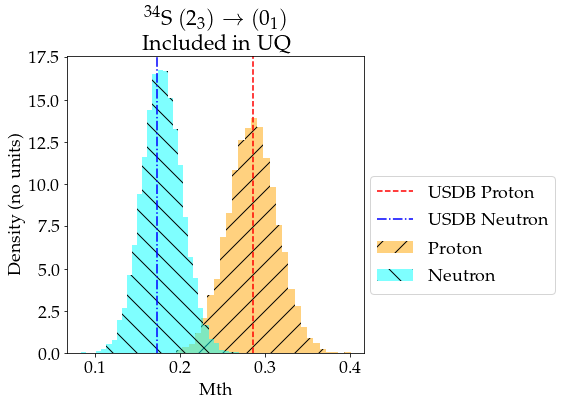

 91%|█████████▏| 172/188 [23:18<02:13,  8.36s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
202          249  34       S  16  18      4114.813             0.023  2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
202  73 FS 6        4114.52  ...         3.729618             0.588887   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
202      34S  0      0   3   1     True -0.2856 -0.173  

[1 rows x 36 columns]
INDEX =  250
GlobalIndex                  250
A                             34
Element                        S
Z                             16
N                             18
Energy (keV)             4688.98
Energy Unc (keV)            0.05
Ji                             4
Thalf                    88 FS 4
E_gamma (keV)            2561.36
E_gamma Unc (keV)           0.05
I_gamma                    100.0
I_gamma Unc                 11.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef             

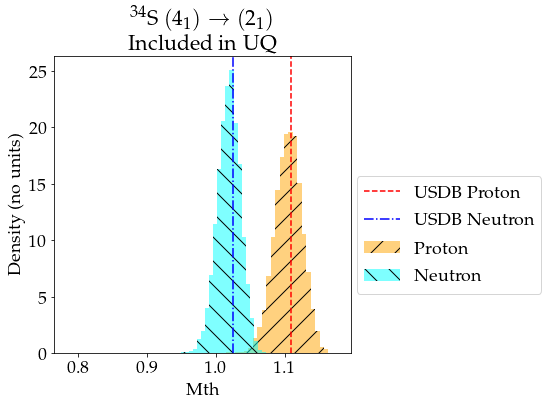

 92%|█████████▏| 173/188 [23:26<02:04,  8.30s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
203          250  34       S  16  18       4688.98              0.05  4   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
203  88 FS 4        2561.36  ...        53.654155             9.160466   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
203      34S  2      4   1   1     True  1.1094  1.0248  

[1 rows x 36 columns]
INDEX =  251
GlobalIndex                 251
A                            34
Element                       S
Z                            16
N                            18
Energy (keV)           4889.756
Energy Unc (keV)          0.022
Ji                            2
Thalf                  29 FS 10
E_gamma (keV)            4889.3
E_gamma Unc (keV)          0.08
I_gamma                    90.0
I_gamma Unc                10.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Conv

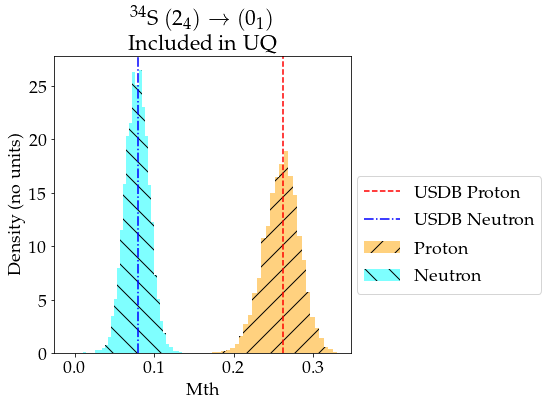

 93%|█████████▎| 174/188 [23:34<01:56,  8.30s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
204          251  34       S  16  18      4889.756             0.022  2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
204  29 FS 10         4889.3  ...         2.290116             0.850615   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
204      34S  0      0   4   1     True -0.2617 -0.0795  

[1 rows x 36 columns]
INDEX =  256
GlobalIndex                  256
A                             33
Element                       Cl
Z                             17
N                             16
Energy (keV)              2839.0
Energy Unc (keV)             0.3
Ji                           5/2
Thalf                     3 FS 1
E_gamma (keV)             2028.4
E_gamma Unc (keV)            0.0
I_gamma                      1.0
I_gamma Unc                  0.4
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef         

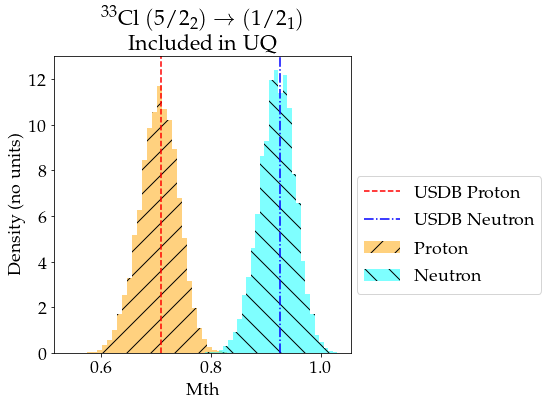

 93%|█████████▎| 175/188 [23:42<01:46,  8.17s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
206          256  33      Cl  17  16        2839.0               0.3  5/2   

      Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
206  3 FS 1         2028.4  ...        56.590741            31.439301   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
206     33Cl  1/2      1   2   1     True -0.7094 -0.9258  

[1 rows x 36 columns]
INDEX =  257
GlobalIndex                   257
A                              34
Element                        Cl
Z                              17
N                              17
Energy (keV)               2376.5
Energy Unc (keV)              0.4
Ji                              4
Thalf                   150 FS 17
E_gamma (keV)              1146.3
E_gamma Unc (keV)             0.0
I_gamma                      11.0
I_gamma Unc                   8.0
Mult                           E2
Mult Ratio                    NaN
Mult Ratio Unc                Na

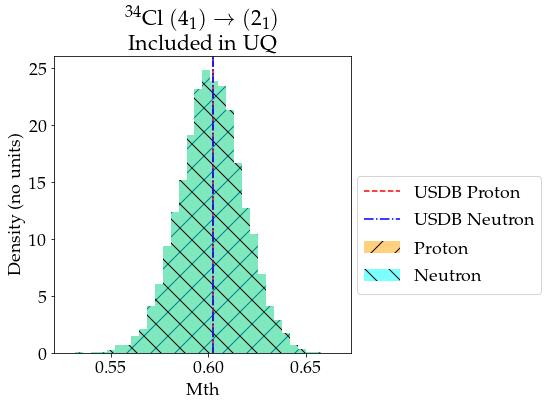

 94%|█████████▎| 176/188 [23:50<01:37,  8.14s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
207          257  34      Cl  17  17        2376.5               0.4  4   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
207  150 FS 17         1146.3  ...       130.863794           104.691035   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
207     34Cl  2      4   1   1     True  0.6023  0.6023  

[1 rows x 36 columns]
INDEX =  261
GlobalIndex                  261
A                             35
Element                       Cl
Z                             17
N                             18
Energy (keV)             2645.74
Energy Unc (keV)            0.08
Ji                           7/2
Thalf                  159 FS 21
E_gamma (keV)             2645.7
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  1.1
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

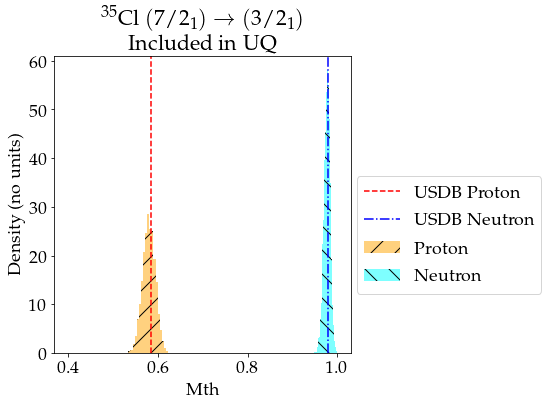

 94%|█████████▍| 177/188 [23:58<01:29,  8.15s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
210          261  35      Cl  17  18       2645.74              0.08  7/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
210  159 FS 21         2645.7  ...         25.16383             3.400518   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p  Mth_n  
210     35Cl  3/2      3   1   1     True -0.5837  -0.98  

[1 rows x 36 columns]
INDEX =  262
GlobalIndex                  262
A                             35
Element                       Cl
Z                             17
N                             18
Energy (keV)              3002.3
Energy Unc (keV)            0.13
Ji                           5/2
Thalf                    21 FS 4
E_gamma (keV)             1782.9
E_gamma Unc (keV)            0.0
I_gamma                      3.4
I_gamma Unc                  1.1
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

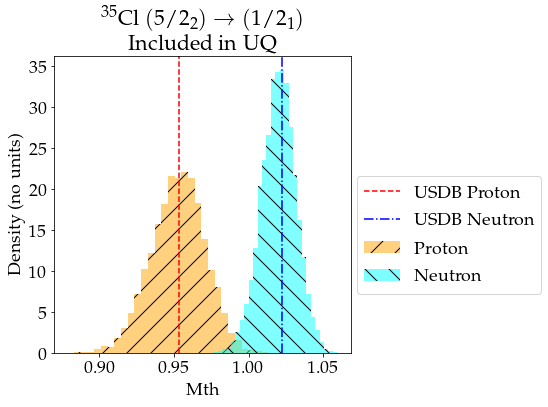

 95%|█████████▍| 178/188 [24:06<01:20,  8.03s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
211          262  35      Cl  17  18        3002.3              0.13  5/2   

       Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
211  21 FS 4         1782.9  ...        47.607245            20.403105   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
211     35Cl  1/2      1   2   1     True  0.9536  1.0221  

[1 rows x 36 columns]
INDEX =  263
GlobalIndex                  263
A                             35
Element                       Cl
Z                             17
N                             18
Energy (keV)             3943.82
Energy Unc (keV)            0.25
Ji                           9/2
Thalf                  205 FS 35
E_gamma (keV)             2180.0
E_gamma Unc (keV)            1.0
I_gamma                    100.0
I_gamma Unc                  2.2
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef   

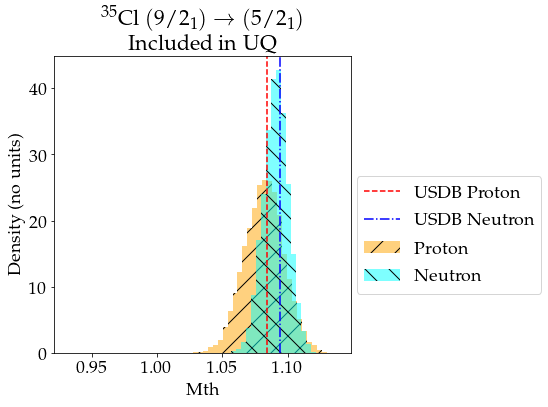

 95%|█████████▌| 179/188 [24:14<01:11,  7.99s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
212          263  35      Cl  17  18       3943.82              0.25  9/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
212  205 FS 35         2180.0  ...        48.287349             8.841346   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
212     35Cl  5/2      5   1   1     True  1.0842  1.0937  

[1 rows x 36 columns]
INDEX =  264
GlobalIndex                 264
A                            35
Element                      Cl
Z                            17
N                            18
Energy (keV)            4111.98
Energy Unc (keV)           0.24
Ji                          7/2
Thalf                  49 FS 11
E_gamma (keV)            4111.7
E_gamma Unc (keV)           0.0
I_gamma                   100.0
I_gamma Unc                 6.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef               

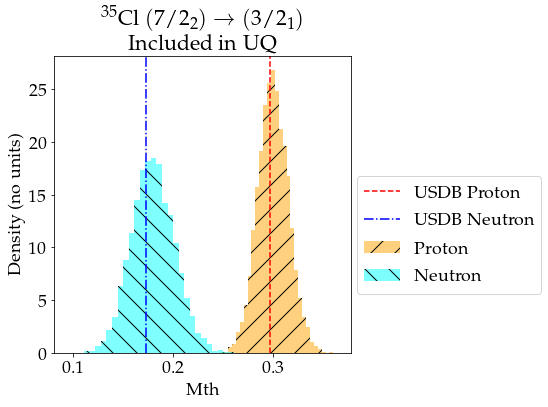

 96%|█████████▌| 180/188 [24:22<01:03,  7.98s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
213          264  35      Cl  17  18       4111.98              0.24  7/2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
213  49 FS 11         4111.7  ...         4.896745             1.224186   

     Nucleus   Jf  twoJf  ni  nf  Include  Mth_p   Mth_n  
213     35Cl  3/2      3   2   1     True  0.297  0.1733  

[1 rows x 36 columns]
INDEX =  265
GlobalIndex                     265
A                                32
Element                          Ar
Z                                18
N                                14
Energy (keV)                 1867.0
Energy Unc (keV)                8.0
Ji                                2
Thalf                  0.46 PS 0.12
E_gamma (keV)                1867.0
E_gamma Unc (keV)               8.0
I_gamma                       100.0
I_gamma Unc                     0.0
Mult                           [E2]
Mult Ratio                      NaN


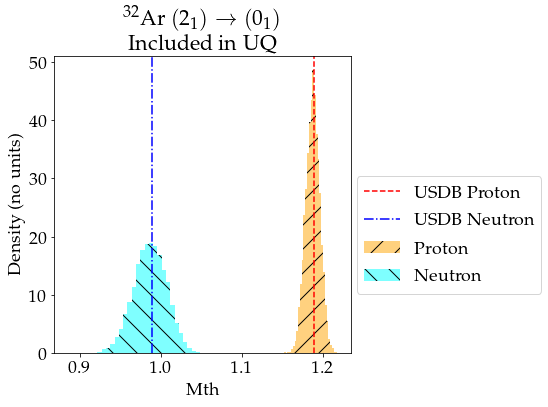

 96%|█████████▋| 181/188 [24:30<00:55,  8.00s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
214          265  32      Ar  18  14        1867.0               8.0  2   

            Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
214  0.46 PS 0.12         1867.0  ...        53.712364            13.880723   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
214     32Ar  0      0   1   1     True  1.1888  0.9891  

[1 rows x 36 columns]
INDEX =  266
GlobalIndex                  266
A                             34
Element                       Ar
Z                             18
N                             16
Energy (keV)              2091.1
Energy Unc (keV)             0.3
Ji                             2
Thalf                  319 FS 42
E_gamma (keV)             2091.1
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef 

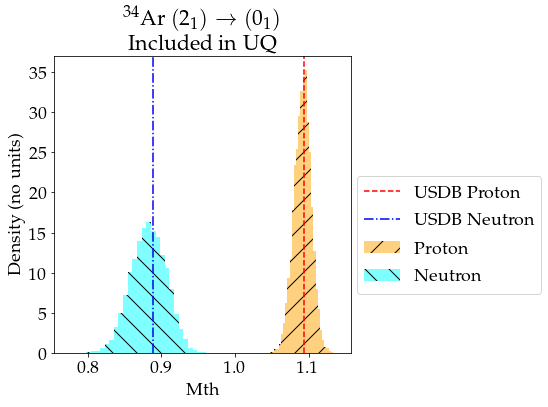

 97%|█████████▋| 182/188 [24:38<00:47,  7.98s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
215          266  34      Ar  18  16        2091.1               0.3  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
215  319 FS 42         2091.1  ...         44.49369             5.888871   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
215     34Ar  0      0   1   1     True -1.0931 -0.8888  

[1 rows x 36 columns]
INDEX =  267
GlobalIndex                  267
A                             34
Element                       Ar
Z                             18
N                             16
Energy (keV)              3287.7
Energy Unc (keV)             0.5
Ji                             2
Thalf                  194 FS 35
E_gamma (keV)             3286.0
E_gamma Unc (keV)            4.0
I_gamma                      9.0
I_gamma Unc                  6.0
Mult                        [E2]
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

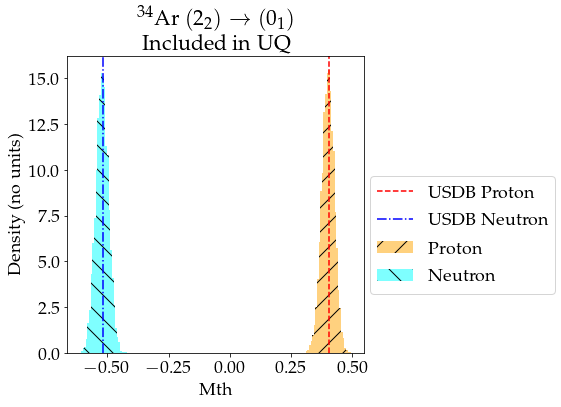

 97%|█████████▋| 183/188 [24:46<00:39,  7.86s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
216          267  34      Ar  18  16        3287.7               0.5  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
216  194 FS 35         3286.0  ...         0.654319             0.458023   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
216     34Ar  0      0   2   1     True  0.4066 -0.5177  

[1 rows x 36 columns]
INDEX =  268
GlobalIndex                  268
A                             36
Element                       Ar
Z                             18
N                             18
Energy (keV)             1970.38
Energy Unc (keV)            0.05
Ji                             2
Thalf                  328 FS 20
E_gamma (keV)             1970.3
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

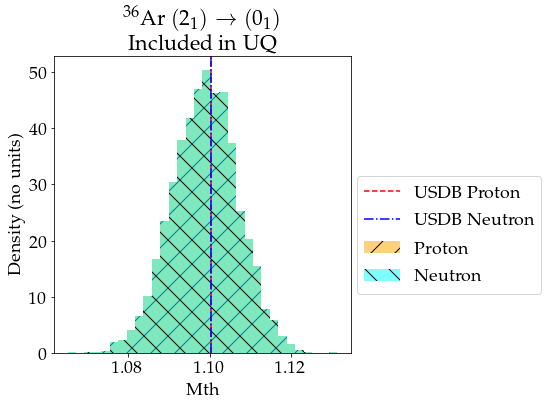

 98%|█████████▊| 184/188 [24:54<00:31,  7.91s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
217          268  36      Ar  18  18       1970.38              0.05  2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
217  328 FS 20         1970.3  ...        57.903055             3.530674   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
217     36Ar  0      0   1   1     True  1.1004  1.1004  

[1 rows x 36 columns]
INDEX =  269
GlobalIndex                  269
A                             36
Element                       Ar
Z                             18
N                             18
Energy (keV)              4414.4
Energy Unc (keV)            0.16
Ji                             4
Thalf                   76 FS 10
E_gamma (keV)             2443.9
E_gamma Unc (keV)            0.0
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef       

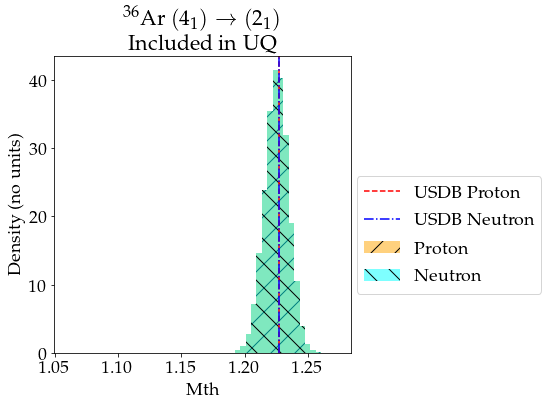

 98%|█████████▊| 185/188 [25:02<00:23,  7.94s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
218          269  36      Ar  18  18        4414.4              0.16  4   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
218  76 FS 10         2443.9  ...        84.736177            11.298157   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
218     36Ar  2      4   1   1     True  1.2273  1.2273  

[1 rows x 36 columns]
INDEX =  270
GlobalIndex                 270
A                            36
Element                      Ar
Z                            18
N                            18
Energy (keV)            4440.11
Energy Unc (keV)           0.19
Ji                            2
Thalf                  76 FS 14
E_gamma (keV)            4439.8
E_gamma Unc (keV)           0.0
I_gamma                   100.0
I_gamma Unc                 3.0
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Co

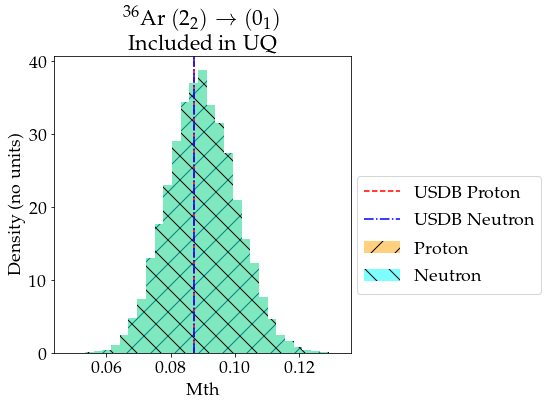

 99%|█████████▉| 186/188 [25:10<00:15,  7.96s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
219          270  36      Ar  18  18       4440.11              0.19  2   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
219  76 FS 14         4439.8  ...         2.753926             0.564908   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
219     36Ar  0      0   2   1     True  0.0872  0.0872  

[1 rows x 36 columns]
INDEX =  272
GlobalIndex                 272
A                            36
Element                      Ar
Z                            18
N                            18
Energy (keV)             7767.0
Energy Unc (keV)            0.4
Ji                            6
Thalf                  76 FS 11
E_gamma (keV)            3352.5
E_gamma Unc (keV)           0.8
I_gamma                    42.9
I_gamma Unc                 1.7
Mult                         E2
Mult Ratio                  NaN
Mult Ratio Unc              NaN
Conv Coef                   NaN
Co

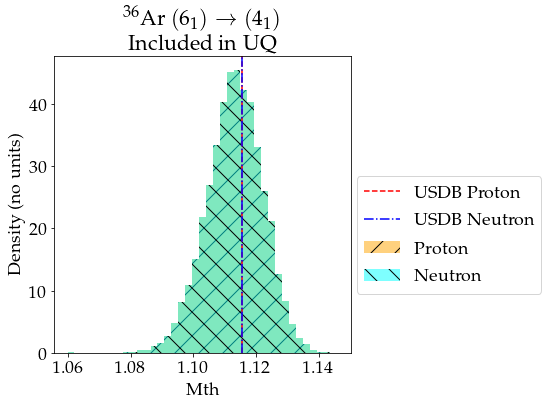

 99%|█████████▉| 187/188 [25:18<00:08,  8.04s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV) Ji  \
221          272  36      Ar  18  18        7767.0               0.4  6   

        Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
221  76 FS 11         3352.5  ...         5.296011             0.847362   

     Nucleus Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
221     36Ar  4      8   1   1     True  1.1156  1.1156  

[1 rows x 36 columns]
INDEX =  273
GlobalIndex                  273
A                             37
Element                       Ar
Z                             18
N                             19
Energy (keV)              2217.0
Energy Unc (keV)            0.23
Ji                           7/2
Thalf                  283 FS 22
E_gamma (keV)             2217.1
E_gamma Unc (keV)            0.3
I_gamma                    100.0
I_gamma Unc                  0.0
Mult                          E2
Mult Ratio                   NaN
Mult Ratio Unc               NaN
Conv Coef         

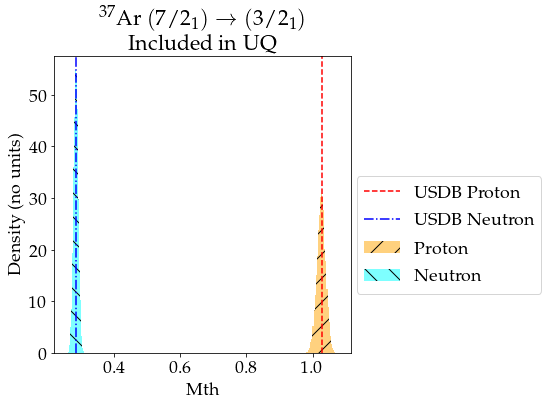

100%|██████████| 188/188 [25:26<00:00,  8.12s/it]

     GlobalIndex   A Element   Z   N  Energy (keV)  Energy Unc (keV)   Ji  \
222          273  37      Ar  18  19        2217.0              0.23  7/2   

         Thalf  E_gamma (keV)  ...  B_exp (e^2fm^4)  B_exp Unc (e^2fm^4)  \
222  283 FS 22         2217.1  ...        33.690781             3.662041   

     Nucleus   Jf  twoJf  ni  nf  Include   Mth_p   Mth_n  
222     37Ar  3/2      3   1   1     True -1.0278 -0.2851  

[1 rows x 36 columns]


In [30]:
# fn_data_for_model = 'e2_data_for_model_050222.pkl'
fn_data_for_model = 'e2_data_for_model_020422.pkl'

collect_data = True

ti_list = list(df_usdb['GlobalIndex'])
if collect_data:
    nuc_dict_list = []
    Mth_p_usdb_list = []
    Mth_n_usdb_list = []
    Mth_p_vec_list = []
    Mth_n_vec_list = []
    title_string_list = []
    Bexp_e2fm4_list = []
    Bexp_unc_e2fm4_list = []
    Bexp_Wu_list = []
    Bexp_unc_Wu_list = []

    for index in tqdm(ti_list):
#         with HiddenPrints():
        t_usdb = df_usdb[df_usdb['GlobalIndex']==index]
        nuc_dict, Mth_p_usdb, Mth_n_usdb, Mth_p_vec, Mth_n_vec, title_string = matrix_element_distributions(index,plot=True,debug=True, fake_run=False)
        print(t_usdb)
        if t_usdb['Include'].iloc[0]==False:
            print('EXCLUDED TRANSITION:',nuc_dict)
            continue
        nuc_dict_list.append(nuc_dict)
        Mth_p_usdb_list.append(Mth_p_usdb)
        Mth_n_usdb_list.append(Mth_n_usdb)
        Mth_p_vec_list.append(Mth_p_vec)
        Mth_n_vec_list.append(Mth_n_vec)
        title_string_list.append(title_string)
        Bexp_e2fm4_list.append(t_usdb['B_exp (e^2fm^4)'])
        Bexp_unc_e2fm4_list.append(t_usdb['B_exp Unc (e^2fm^4)'])
        Bexp_Wu_list.append(t_usdb['B_exp (W.u.)'])
        Bexp_unc_Wu_list.append(t_usdb['B_exp Unc (W.u.)'])

    with open(fn_data_for_model,'wb') as fh:
        data_to_dump = [nuc_dict_list,
                    Mth_p_usdb_list,
                    Mth_n_usdb_list,
                    Mth_p_vec_list,
                    Mth_n_vec_list,
                    title_string_list,
                    Bexp_e2fm4_list,
                    Bexp_unc_e2fm4_list,
                    Bexp_Wu_list,
                    Bexp_unc_Wu_list,
                       ]
        pkl.dump(data_to_dump,fh)
        
else:
    with open(fn_data_for_model,'rb') as fh:
        [nuc_dict_list, Mth_p_usdb_list,Mth_n_usdb_list,Mth_p_vec_list,Mth_n_vec_list,title_string_list, Bexp_e2fm4_list, Bexp_unc_e2fm4_list, Bexp_Wu_list, Bexp_unc_Wu_list] = pkl.load(fh)

In [36]:
# each list is actually a df with 1 element. this gets that element
Bexp_e2fm4_list = [x.iloc[0] for x in Bexp_e2fm4_list]
Bexp_unc_e2fm4_list = [x.iloc[0] for x in Bexp_unc_e2fm4_list]
Bexp_Wu_list = [x.iloc[0] for x in Bexp_Wu_list]
Bexp_unc_Wu_list = [x.iloc[0] for x in Bexp_unc_Wu_list]

AttributeError: 'numpy.float64' object has no attribute 'iloc'

In [38]:
A_vec = np.array([nuc_dict['A'] for nuc_dict in nuc_dict_list])
Bexp_e2fm4_vec = np.array(Bexp_e2fm4_list)
Bexp_unc_e2fm4_vec = np.array(Bexp_unc_e2fm4_list) 
Bexp_Wu_vec = np.array(Bexp_Wu_list)
Bexp_unc_Wu_vec = np.array(Bexp_unc_Wu_list) 

In [39]:
Mth_p_array = np.array(Mth_p_vec_list)
Mth_n_array = np.array(Mth_n_vec_list)
n_transitions, n_samples = Mth_p_array.shape
print(f'n_samples = {n_samples}')
print(f'n_transitions = {n_transitions}')

n_samples = 9965
n_transitions = 188


In [40]:
e_p_opt, e_n_opt = 1.41, 0.41
b_mu, b_beta = 0.48, 1.91
b_sqr_vec = b_mu*A_vec**(1/3) + b_beta
single_particle_estimates = Bweisskopf(2,A_vec)

def Bth_model_v1(theta,Mth_p_vec,Mth_n_vec):
    e_p,e_n = theta
    Bth_vec = b_sqr_vec**2 * ( e_p * np.array(Mth_p_vec) + e_n * np.array(Mth_n_vec))**2
    return Bth_vec

def Bth_model_Wu_v1(theta,Mth_p_vec,Mth_n_vec):
    e_p,e_n = theta
    Bth_vec = b_sqr_vec**2 * ( e_p * np.array(Mth_p_vec) + e_n * np.array(Mth_n_vec))**2
    return Bth_vec / single_particle_estimates

In [43]:
Mth_n_array.shape

(188, 9965)

In [44]:
n_samples == Mth_p_array.shape[1]

True

In [76]:
def cumulative_mean(A,axis=0):
    na,nb = A.shape
    if axis==0:
        norm = np.arange(1,na+1)
        cm = np.cumsum(A,axis=0) / np.tile(norm,nb).reshape((na,nb))
    elif axis==1:
        norm = np.arange(1,nb+1)
        cm = np.cumsum(A,axis=1) / np.tile(norm,na).reshape((na,nb))
    return cm

In [85]:
Mth_p_means = cumulative_mean(Mth_p_array,axis=1)
Mth_n_means = cumulative_mean(Mth_n_array,axis=1)

In [100]:
Bth_means = np.array([ Bth_model_Wu_v1([e_p_opt,e_n_opt],Mth_p_array[:,i],Mth_n_array[:,i]) for i in range(n_samples) ]).T
Bth_means = cumulative_mean(Bth_means,axis=1)

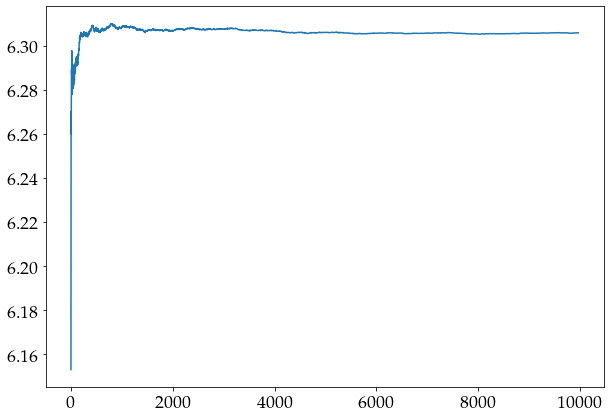

In [101]:
iB = 0
domain = np.arange(n_samples)
plt.figure(figsize=(10,7))
plt.plot(domain,Bth_means[iB])
plt.show()

/usr/workspace/fox39/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


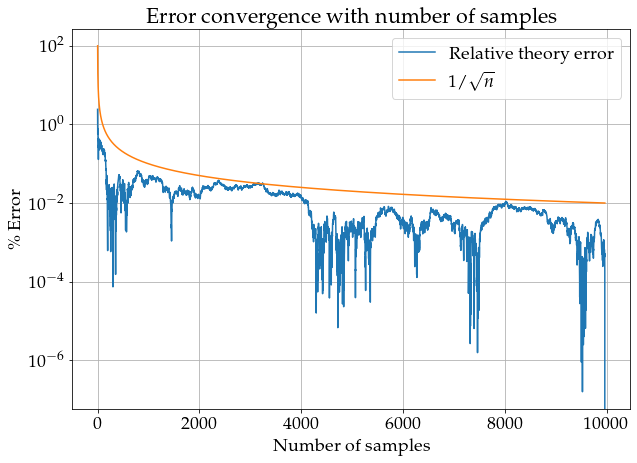

In [110]:
iB = 0
domain = np.arange(n_samples)
B = Bth_means[iB,-1]
sq_err = np.abs((B - Bth_means[iB]) / B ) 
plt.figure(figsize=(10,7))
plt.semilogy(domain,100*sq_err,label='Relative theory error')
plt.semilogy(domain,100/domain,label=r'$ 1/\sqrt{n} $')
plt.legend()
plt.title('Error convergence with number of samples')
plt.xlabel('Number of samples')
plt.ylabel("\% Error")
plt.grid()
plt.show()

/usr/workspace/fox39/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


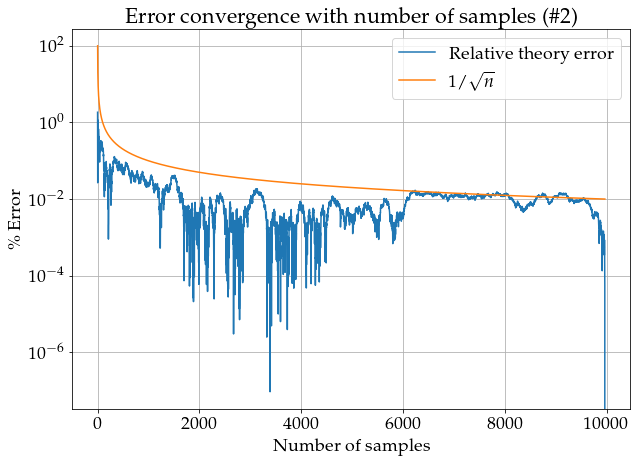

/usr/workspace/fox39/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


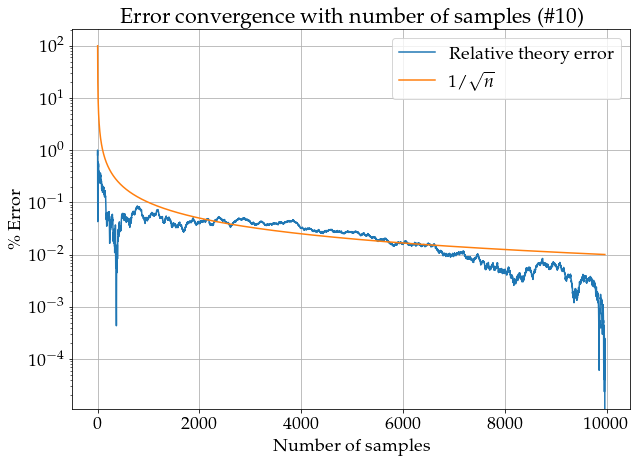

/usr/workspace/fox39/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


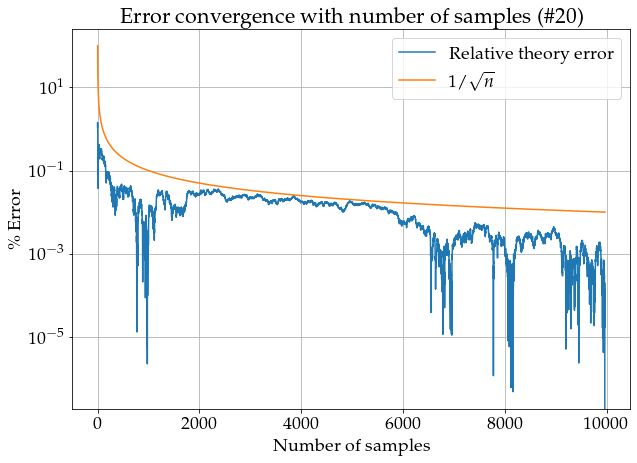

/usr/workspace/fox39/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


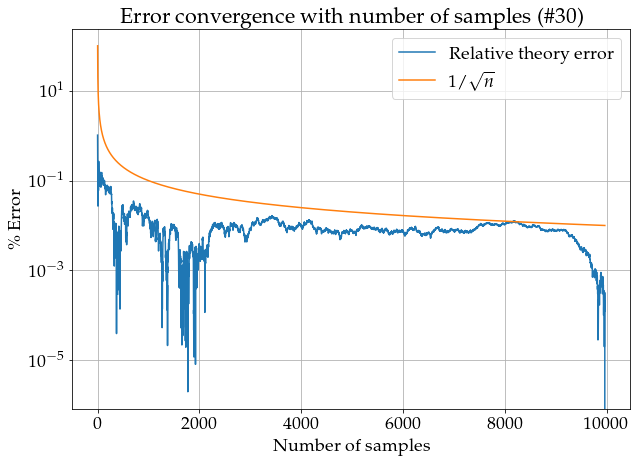

/usr/workspace/fox39/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


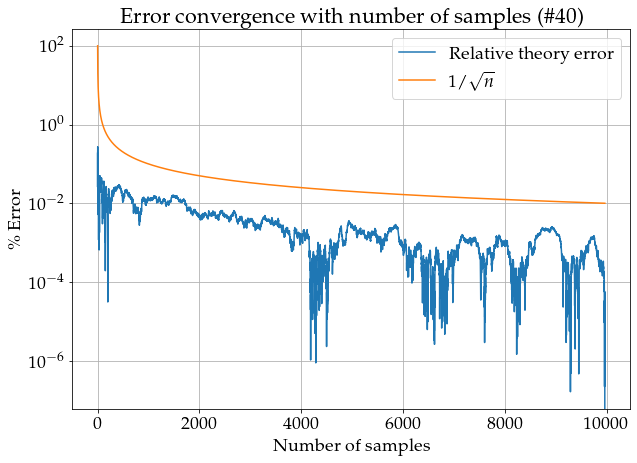

/usr/workspace/fox39/anaconda3/envs/uq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


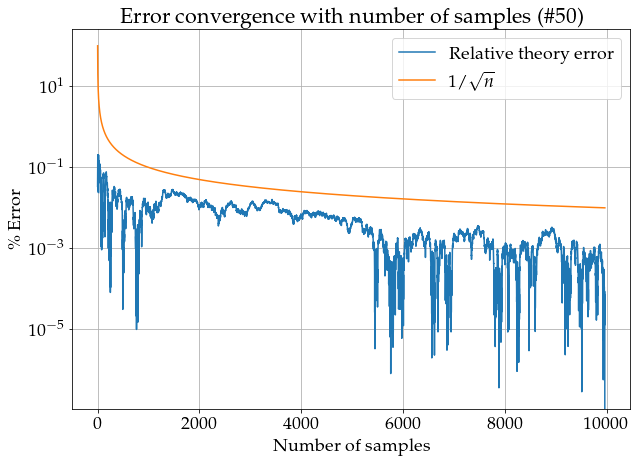

In [114]:
domain = np.arange(n_samples)
for iB in [2,10,20,30,40,50]:
    B = Bth_means[iB,-1]
    sq_err = np.abs((B - Bth_means[iB]) / B ) 
    plt.figure(figsize=(10,7))
    plt.semilogy(domain,100*sq_err,label='Relative theory error')
    plt.semilogy(domain,100/domain,label=r'$ 1/\sqrt{n} $')
    plt.legend()
    plt.title(f"Error convergence with number of samples (\#{iB})")
    plt.xlabel('Number of samples')
    plt.ylabel("\% Error")
    plt.grid()
    plt.show()